# Models 

This notebook contains the examples of attempted models and approaches employed towards finding solution to the ACMG classification problem. This particular version is concerned with custom parsing - related notebook EDA - Custom Parsing

## Imports

In [1]:
from utils.EDA_utils import *
from utils.utils import get_dataset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
import dalex as dx
from sklearn.model_selection import LeaveOneOut
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
df = get_dataset("data/", samples=["EE_015", "EE_050", "EE_069"], file_type="both", option_csq="potential", 
            options_genotype=["potential", "all"], with_default=True)

In [3]:
df.head()

#CHROM     POS REF ALT QUAL  FILTER_slippage  FILTER_strand_bias  \
0   chr1   15820   G   T    .                0                   0   
1   chr1   17385   G   A    .                0                   0   
2   chr1   17697   G   C    .                0                   0   
3   chr1  133129   G   A    .                0                   0   
4   chr1  183629   G   A    .                0                   0   

   FILTER_base_qual  FILTER_clustered_events  FILTER_map_qual  ...  \
0                 0                        0                0  ...   
1                 0                        0                0  ...   
2                 0                        0                0  ...   
3                 0                        0                0  ...   
4                 0                        0                0  ...   

   Existing_variation_CI  Existing_variation_CS  Existing_variation_rs  \
0                      0                      0                      1   
1                      0                      0                      1   
2                      0                      0                      1   
3                      0                      0                      1   
4                      0                      0                      1   

   Existing_variation_CX  FLAGS_start  PUBMED_exist SIFT_class  SIFT_pred  \
0                      0            0             0        NaN        NaN   
1                      0            0             0        NaN        NaN   
2                      0            0             0        NaN        NaN   
3                      0            0             0        NaN        NaN   
4                      0            0             0        NaN        NaN   

   PolyPhen_class  PolyPhen_pred  
0             NaN            NaN  
1             NaN            NaN  
2             NaN            NaN  
3             NaN            NaN  
4             NaN            NaN  

[5 rows x 117 columns]

In [4]:
custom_mapping = {
    'Benign': 0,
    'Likely%40Benign': 1,
    'Uncertain%40Significance': 2,
    'Likely%40Pathogenic': 3,
    'Pathogenic': 4
}

target_column = "ACMG_class"


df = df.loc[:, ~df.columns.duplicated()]
preprocessed_df1 = preprocess(df)
preprocessed_df2 = preprocess(df, fill_median=True)
preprocessed_df3 = preprocess(df, one_hot_nans = False)

encoded_df1, encoders1, target_mapping1 = encode(preprocessed_df1, target_column, custom_mapping)
encoded_df2, encoders2, target_mapping2 = encode(preprocessed_df2, target_column, custom_mapping)
encoded_df3, encoders3, target_mapping3 = encode(preprocessed_df3, target_column, custom_mapping)

In [5]:
encoded_df1.head()

#CHROM     POS   REF   ALT  QUAL  FILTER_slippage  FILTER_strand_bias  \
0       0   15820  1773  2117     0                0                   0   
1       0   17385  1773     0     0                0                   0   
2       0   17697  1773   721     0                0                   0   
3       0  133129  1773     0     0                0                   0   
4       0  183629  1773     0     0                0                   0   

   FILTER_base_qual  FILTER_clustered_events  FILTER_map_qual  ...  \
0                 0                        0                0  ...   
1                 0                        0                0  ...   
2                 0                        0                0  ...   
3                 0                        0                0  ...   
4                 0                        0                0  ...   

   SpliceAI_pred_DS_AL_is_nan  SpliceAI_pred_DS_DG_is_nan  \
0                           1                           1   
1                           1                           1   
2                           1                           1   
3                           1                           1   
4                           1                           1   

   SpliceAI_pred_DS_DL_is_nan  SpliceAI_pred_SYMBOL_is_nan  LOEUF_is_nan  \
0                           1                            1             1   
1                           1                            1             1   
2                           1                            1             1   
3                           1                            1             1   
4                           1                            1             1   

   NMD_is_nan  SIFT_class_is_nan  SIFT_pred_is_nan  PolyPhen_class_is_nan  \
0           1                  1                 1                      1   
1           1                  1                 1                      1   
2           1                  1                 1                      1   
3           1                  1                 1                      1   
4           1                  1                 1                      1   

   PolyPhen_pred_is_nan  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1  

[5 rows x 173 columns]

In [6]:
encoded_df2.head()

#CHROM     POS   REF   ALT  QUAL  FILTER_slippage  FILTER_strand_bias  \
0       0   15820  1773  2117     0                0                   0   
1       0   17385  1773     0     0                0                   0   
2       0   17697  1773   721     0                0                   0   
3       0  133129  1773     0     0                0                   0   
4       0  183629  1773     0     0                0                   0   

   FILTER_base_qual  FILTER_clustered_events  FILTER_map_qual  ...  \
0                 0                        0                0  ...   
1                 0                        0                0  ...   
2                 0                        0                0  ...   
3                 0                        0                0  ...   
4                 0                        0                0  ...   

   SpliceAI_pred_DS_AL_is_nan  SpliceAI_pred_DS_DG_is_nan  \
0                           1                           1   
1                           1                           1   
2                           1                           1   
3                           1                           1   
4                           1                           1   

   SpliceAI_pred_DS_DL_is_nan  SpliceAI_pred_SYMBOL_is_nan  LOEUF_is_nan  \
0                           1                            1             1   
1                           1                            1             1   
2                           1                            1             1   
3                           1                            1             1   
4                           1                            1             1   

   NMD_is_nan  SIFT_class_is_nan  SIFT_pred_is_nan  PolyPhen_class_is_nan  \
0           1                  1                 1                      1   
1           1                  1                 1                      1   
2           1                  1                 1                      1   
3           1                  1                 1                      1   
4           1                  1                 1                      1   

   PolyPhen_pred_is_nan  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1  

[5 rows x 173 columns]

In [7]:
encoded_df3.head()

#CHROM     POS   REF   ALT  QUAL  FILTER_slippage  FILTER_strand_bias  \
0       0   15820  1773  2117     0                0                   0   
1       0   17385  1773     0     0                0                   0   
2       0   17697  1773   721     0                0                   0   
3       0  133129  1773     0     0                0                   0   
4       0  183629  1773     0     0                0                   0   

   FILTER_base_qual  FILTER_clustered_events  FILTER_map_qual  ...  \
0                 0                        0                0  ...   
1                 0                        0                0  ...   
2                 0                        0                0  ...   
3                 0                        0                0  ...   
4                 0                        0                0  ...   

   Existing_variation_CI  Existing_variation_CS  Existing_variation_rs  \
0                      0                      0                      1   
1                      0                      0                      1   
2                      0                      0                      1   
3                      0                      0                      1   
4                      0                      0                      1   

   Existing_variation_CX  FLAGS_start  PUBMED_exist  SIFT_class  SIFT_pred  \
0                      0            0             0           0       -1.0   
1                      0            0             0           0       -1.0   
2                      0            0             0           0       -1.0   
3                      0            0             0           0       -1.0   
4                      0            0             0           0       -1.0   

   PolyPhen_class  PolyPhen_pred  
0               0           -1.0  
1               0           -1.0  
2               0           -1.0  
3               0           -1.0  
4               0           -1.0  

[5 rows x 117 columns]

## Model Training

In [8]:
def invert_dict(original_dict):
    inverted_dict = {v: k for k, v in original_dict.items()}
    return inverted_dict

In [9]:
inverted_mapping = invert_dict(target_mapping1)

Example model training

In [10]:
X = encoded_df1.drop(columns=['ACMG_class'])
y = encoded_df1['ACMG_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
clf = RandomForestClassifier(class_weight=dict(enumerate(class_weights)))

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     76922
           1       0.75      0.62      0.68      5151
           2       0.84      0.62      0.71      6781
           3       0.67      0.16      0.26        25
           4       0.50      0.10      0.17        10

    accuracy                           0.94     88889
   macro avg       0.74      0.50      0.56     88889
weighted avg       0.94      0.94      0.94     88889



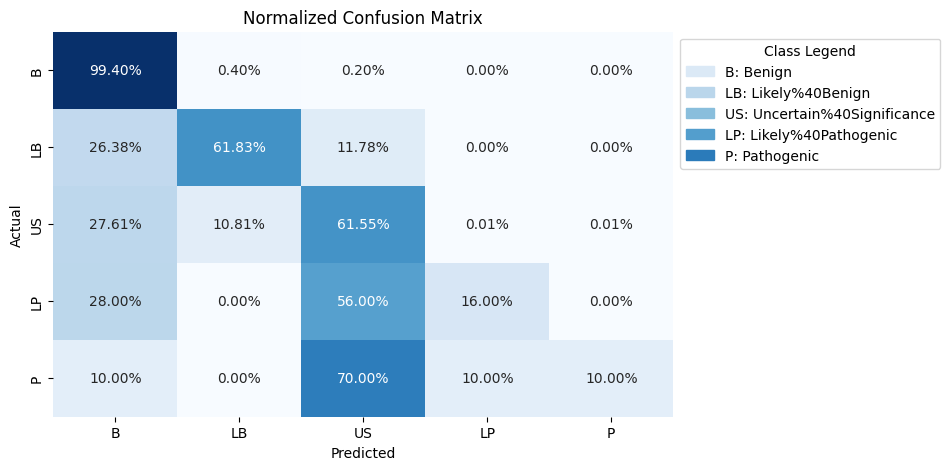

In [11]:
get_confusion_matrix_plot(y_test, y_pred, inverted_mapping)

### Pipeline for Trying multiple different models in sklearn

This pipeline compares the performance of different models implemented in sklearn: Random Forrest, AdaBoost, Decision Tree, Logistic Regression, Bagging.
The results are shown in the form of a confusion matrix. The most promissing model appears to be AdaBoost.
Good performance on majority class is often balanced by bad performance minority class and vice-verse, as such ensamble models might be a good idea.

Classification report for Random Forest with dataset Encoded - OneHot Nans, Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     76922
           1       0.75      0.62      0.68      5151
           2       0.84      0.62      0.71      6781
           3       0.83      0.20      0.32        25
           4       0.50      0.10      0.17        10

    accuracy                           0.94     88889
   macro avg       0.78      0.51      0.57     88889
weighted avg       0.94      0.94      0.94     88889



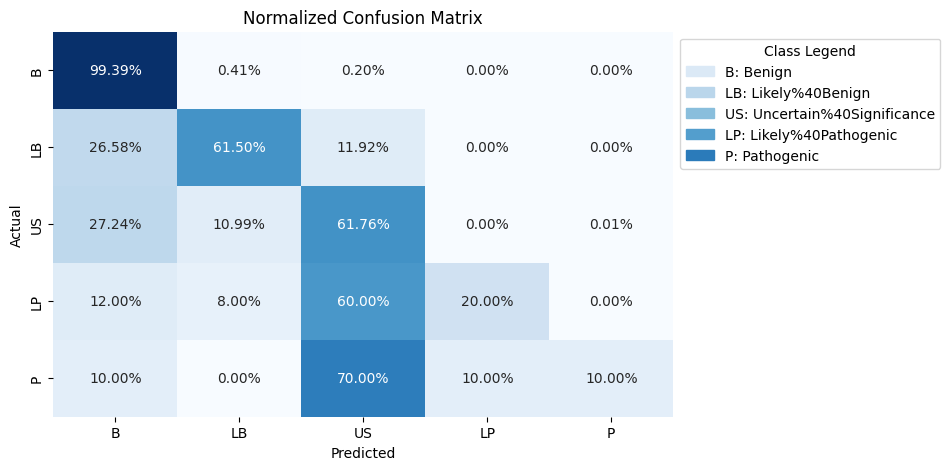

Classification report for AdaBoost with dataset Encoded - OneHot Nans, Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     76922
           1       0.14      0.41      0.21      5151
           2       0.59      0.25      0.35      6781
           3       0.04      0.80      0.08        25
           4       0.50      0.20      0.29        10

    accuracy                           0.78     88889
   macro avg       0.44      0.50      0.36     88889
weighted avg       0.86      0.78      0.81     88889



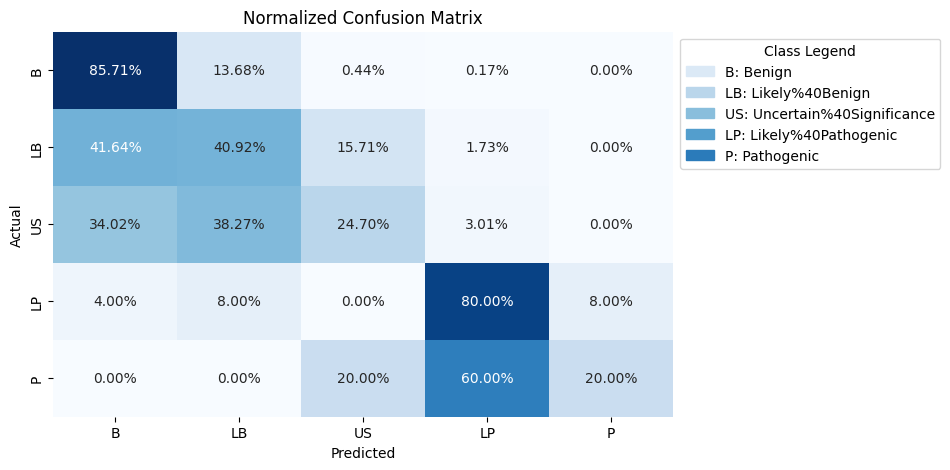

Classification report for Bagging with dataset Encoded - OneHot Nans, Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     76922
           1       0.69      0.66      0.68      5151
           2       0.80      0.63      0.71      6781
           3       0.56      0.20      0.29        25
           4       0.00      0.00      0.00        10

    accuracy                           0.94     88889
   macro avg       0.60      0.50      0.53     88889
weighted avg       0.94      0.94      0.94     88889



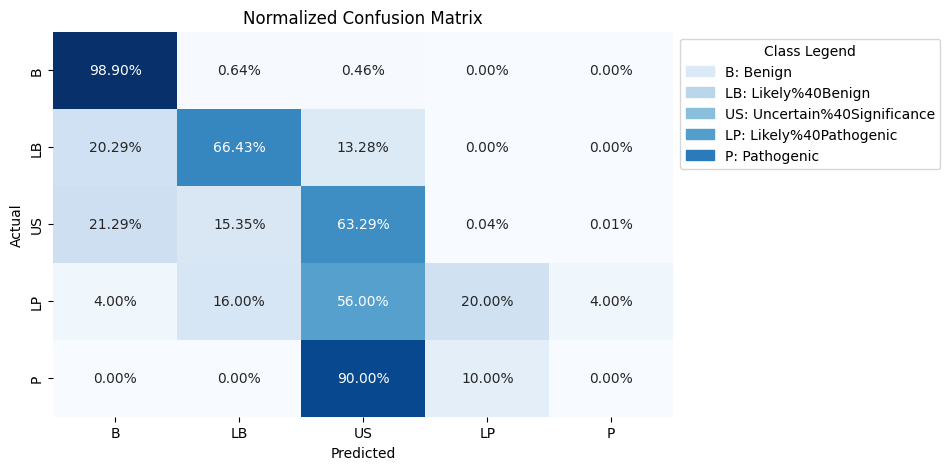

Classification report for Decision Tree with dataset Encoded - OneHot Nans, Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     76922
           1       0.58      0.58      0.58      5151
           2       0.62      0.64      0.63      6781
           3       0.26      0.20      0.23        25
           4       0.12      0.10      0.11        10

    accuracy                           0.92     88889
   macro avg       0.51      0.50      0.50     88889
weighted avg       0.92      0.92      0.92     88889



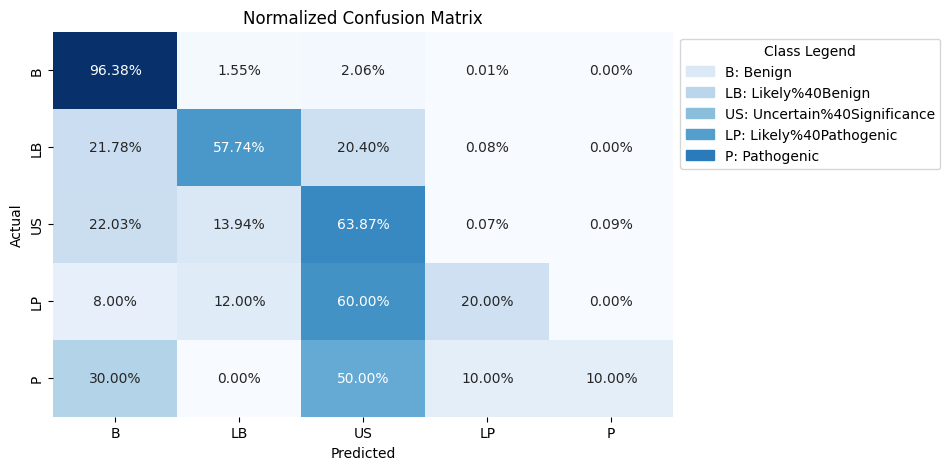

Classification report for Logistic Regression with dataset Encoded - OneHot Nans, Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.87      0.40      0.55     76922
           1       0.33      0.00      0.00      5151
           2       0.50      0.00      0.00      6781
           3       0.00      0.60      0.00        25
           4       0.00      0.00      0.00        10

    accuracy                           0.35     88889
   macro avg       0.34      0.20      0.11     88889
weighted avg       0.81      0.35      0.48     88889



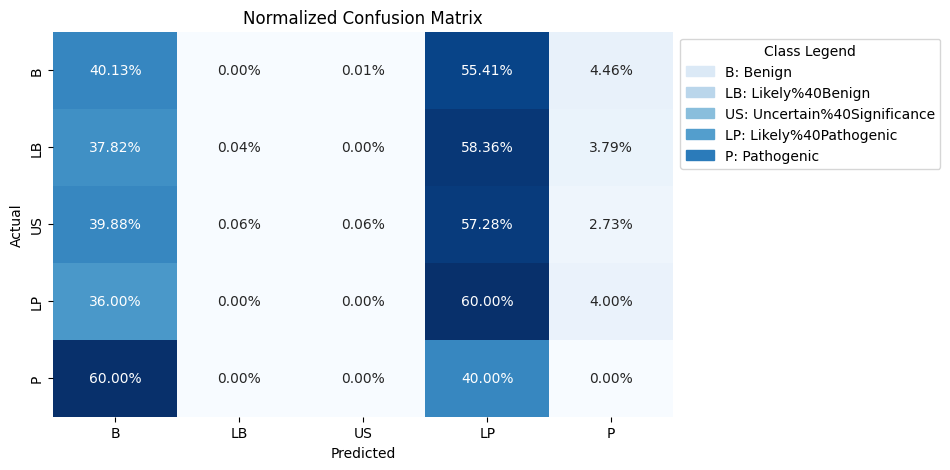

Classification report for Random Forest with dataset Encoded - OneHot Nans, Median and preprocessing None:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     76922
           1       0.75      0.61      0.67      5151
           2       0.84      0.62      0.71      6781
           3       0.75      0.12      0.21        25
           4       0.00      0.00      0.00        10

    accuracy                           0.94     88889
   macro avg       0.66      0.47      0.51     88889
weighted avg       0.94      0.94      0.94     88889



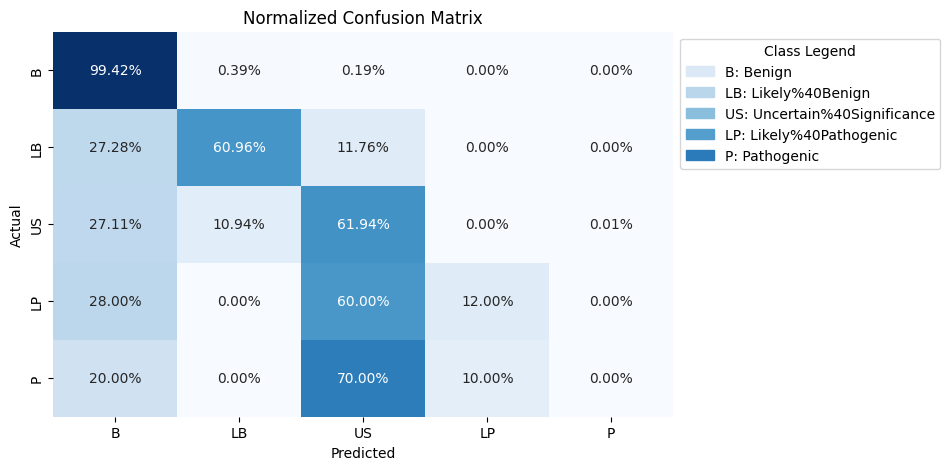

Classification report for AdaBoost with dataset Encoded - OneHot Nans, Median and preprocessing None:
              precision    recall  f1-score   support

           0       0.97      0.60      0.74     76922
           1       0.09      0.68      0.16      5151
           2       0.56      0.22      0.31      6781
           3       0.04      0.76      0.08        25
           4       0.43      0.30      0.35        10

    accuracy                           0.57     88889
   macro avg       0.42      0.51      0.33     88889
weighted avg       0.88      0.57      0.67     88889



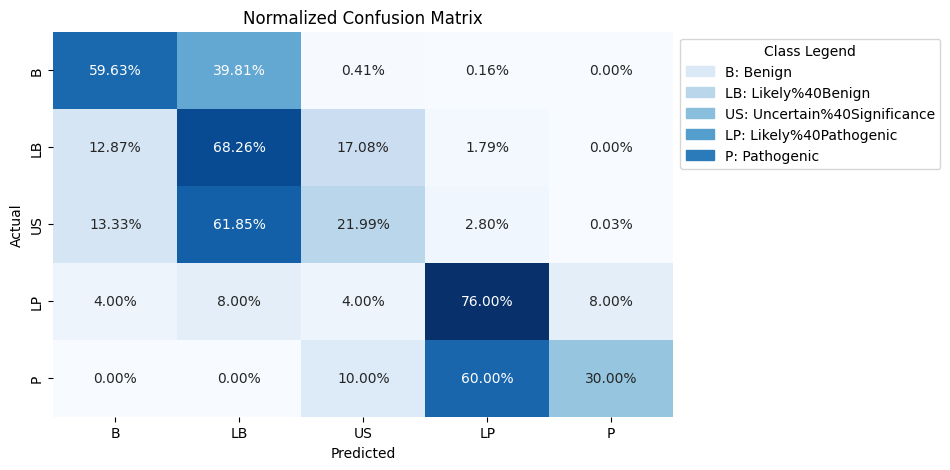

Classification report for Bagging with dataset Encoded - OneHot Nans, Median and preprocessing None:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     76922
           1       0.69      0.66      0.68      5151
           2       0.81      0.63      0.71      6781
           3       0.50      0.16      0.24        25
           4       0.50      0.20      0.29        10

    accuracy                           0.94     88889
   macro avg       0.69      0.53      0.58     88889
weighted avg       0.94      0.94      0.94     88889



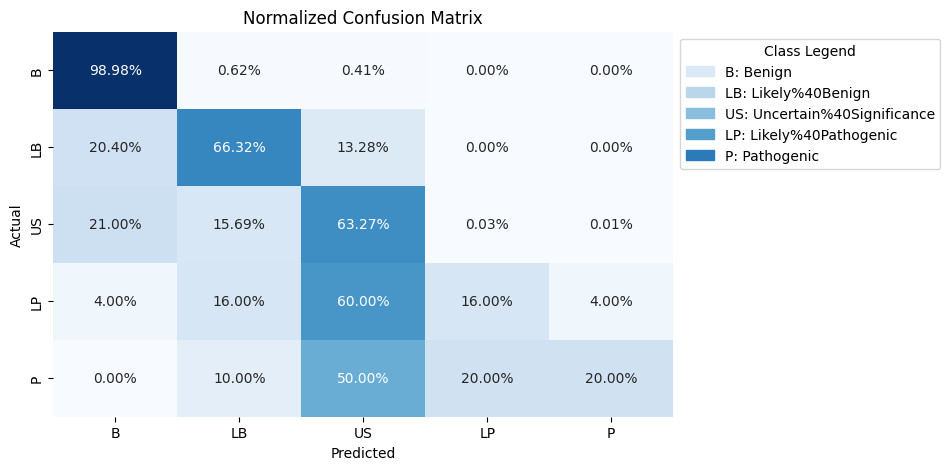

Classification report for Decision Tree with dataset Encoded - OneHot Nans, Median and preprocessing None:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     76922
           1       0.59      0.58      0.58      5151
           2       0.62      0.64      0.63      6781
           3       0.30      0.24      0.27        25
           4       0.11      0.10      0.11        10

    accuracy                           0.92     88889
   macro avg       0.52      0.51      0.51     88889
weighted avg       0.92      0.92      0.92     88889



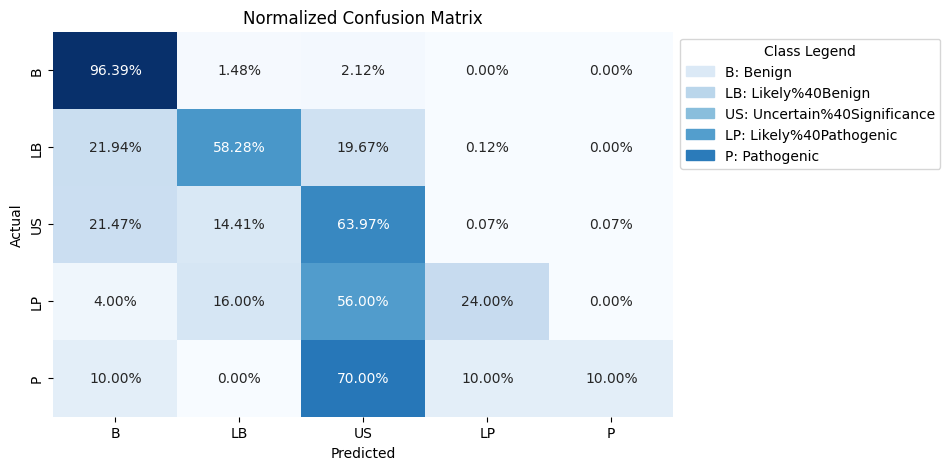

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Logistic Regression with dataset Encoded - OneHot Nans, Median and preprocessing None:
              precision    recall  f1-score   support

           0       0.91      0.40      0.55     76922
           1       0.00      0.00      0.00      5151
           2       0.18      0.22      0.20      6781
           3       0.00      0.52      0.00        25
           4       0.00      0.00      0.00        10

    accuracy                           0.36     88889
   macro avg       0.22      0.23      0.15     88889
weighted avg       0.80      0.36      0.49     88889



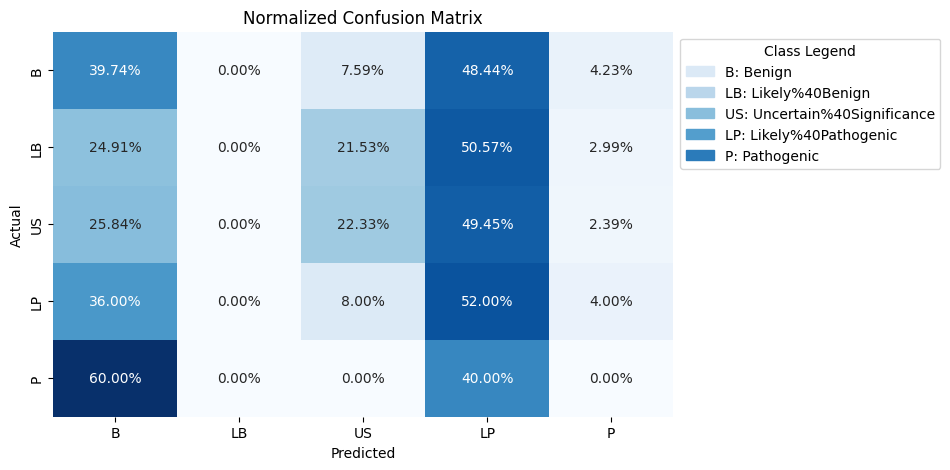

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Random Forest with dataset Encoded - Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     76922
           1       0.75      0.63      0.68      5151
           2       0.84      0.62      0.71      6781
           3       0.67      0.16      0.26        25
           4       0.00      0.00      0.00        10

    accuracy                           0.94     88889
   macro avg       0.64      0.48      0.53     88889
weighted avg       0.94      0.94      0.94     88889



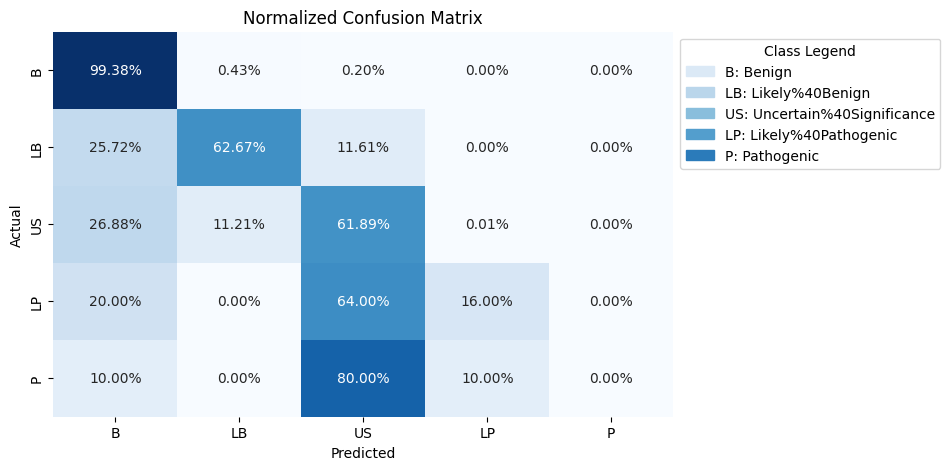

Classification report for AdaBoost with dataset Encoded - Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     76922
           1       0.14      0.41      0.21      5151
           2       0.59      0.25      0.35      6781
           3       0.04      0.80      0.08        25
           4       0.50      0.20      0.29        10

    accuracy                           0.78     88889
   macro avg       0.44      0.50      0.36     88889
weighted avg       0.86      0.78      0.81     88889



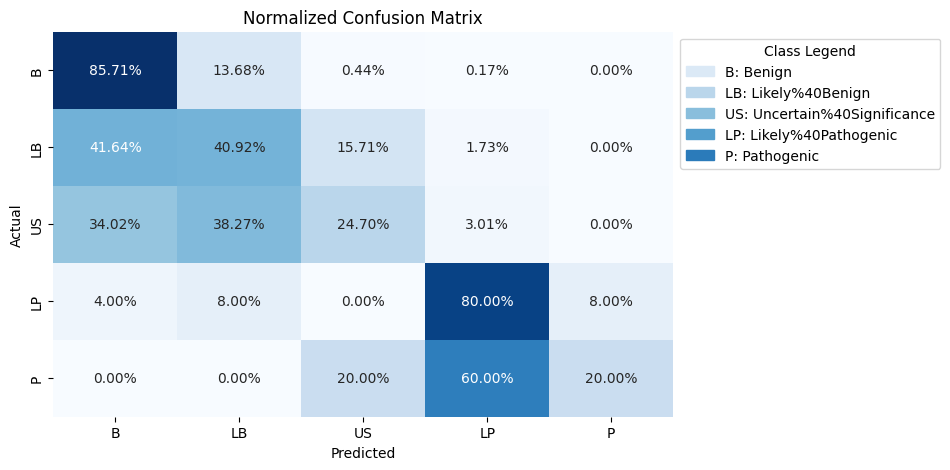

Classification report for Bagging with dataset Encoded - Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     76922
           1       0.69      0.66      0.68      5151
           2       0.80      0.63      0.71      6781
           3       0.38      0.20      0.26        25
           4       0.50      0.20      0.29        10

    accuracy                           0.94     88889
   macro avg       0.67      0.54      0.58     88889
weighted avg       0.94      0.94      0.94     88889



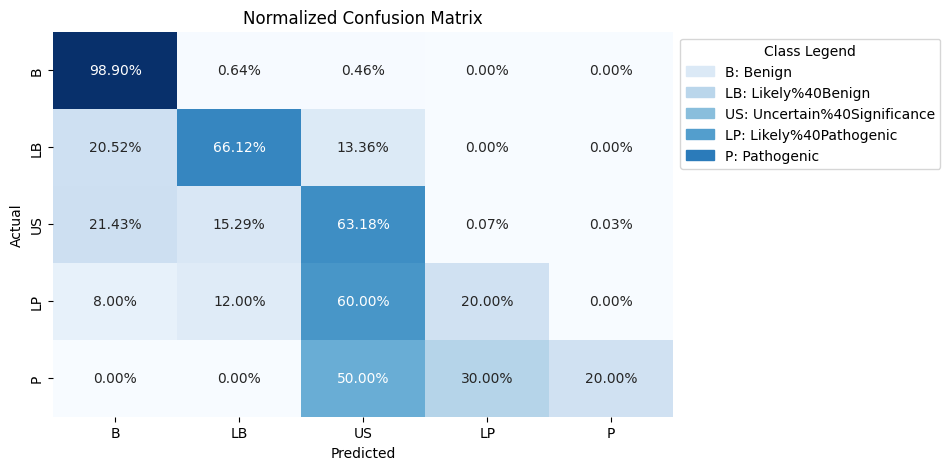

Classification report for Decision Tree with dataset Encoded - Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     76922
           1       0.58      0.58      0.58      5151
           2       0.62      0.63      0.62      6781
           3       0.19      0.16      0.17        25
           4       0.11      0.10      0.11        10

    accuracy                           0.92     88889
   macro avg       0.49      0.49      0.49     88889
weighted avg       0.92      0.92      0.92     88889



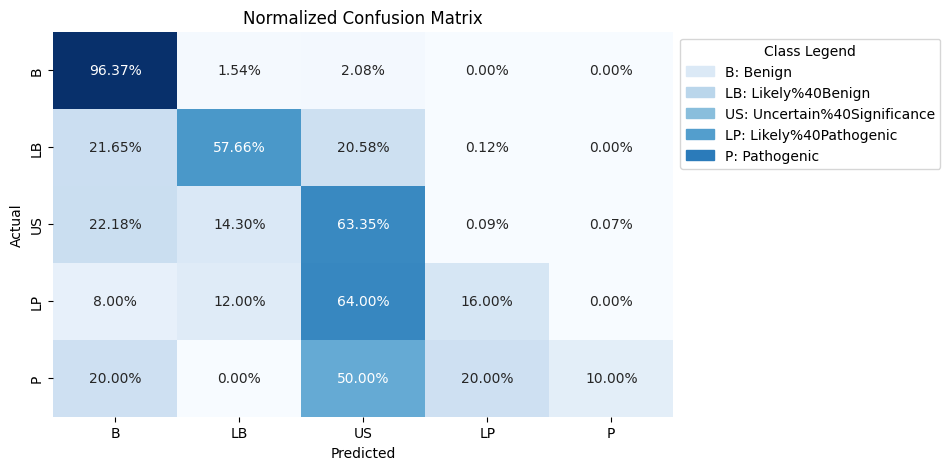

Classification report for Logistic Regression with dataset Encoded - Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.87      0.40      0.55     76922
           1       0.33      0.00      0.00      5151
           2       0.50      0.00      0.00      6781
           3       0.00      0.60      0.00        25
           4       0.00      0.00      0.00        10

    accuracy                           0.35     88889
   macro avg       0.34      0.20      0.11     88889
weighted avg       0.81      0.35      0.48     88889



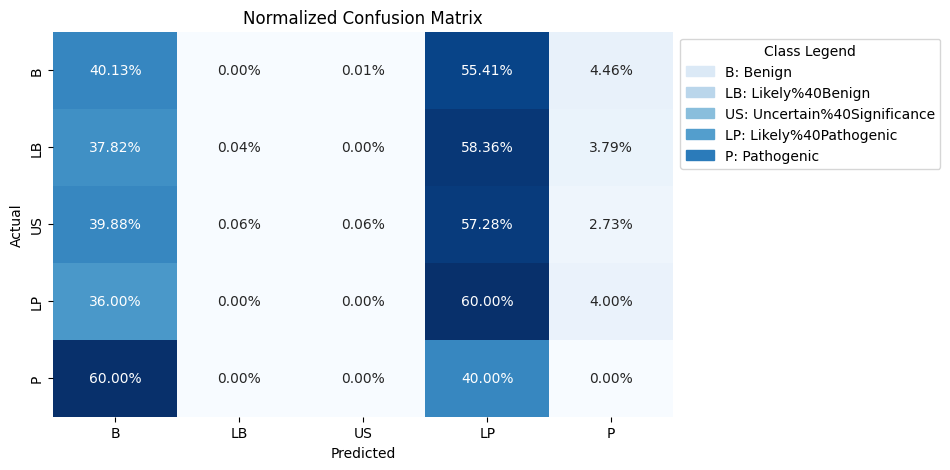

Classification report for Random Forest with dataset Encoded - OneHot Nans, Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     76922
           1       0.75      0.62      0.68      5151
           2       0.84      0.62      0.71      6781
           3       0.83      0.20      0.32        25
           4       0.00      0.00      0.00        10

    accuracy                           0.94     88889
   macro avg       0.68      0.49      0.54     88889
weighted avg       0.94      0.94      0.94     88889



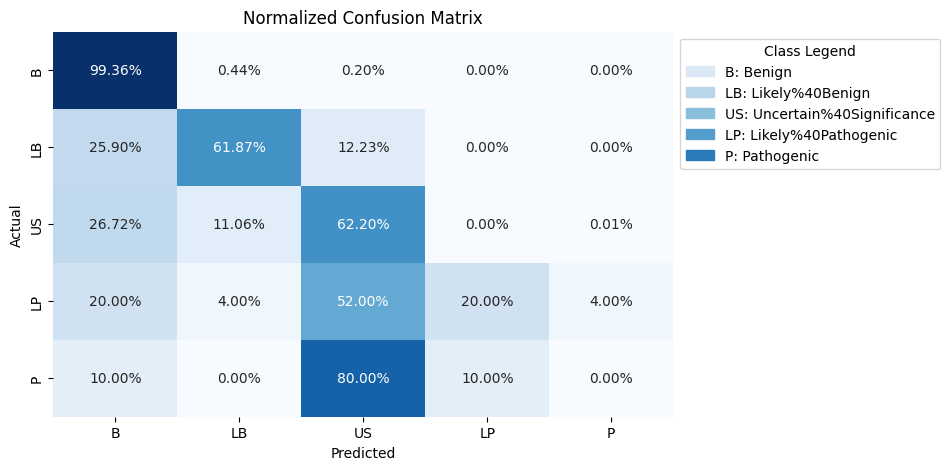

Classification report for AdaBoost with dataset Encoded - OneHot Nans, Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.95      0.79      0.86     76922
           1       0.13      0.57      0.22      5151
           2       0.53      0.20      0.29      6781
           3       0.05      0.76      0.09        25
           4       0.50      0.10      0.17        10

    accuracy                           0.73     88889
   macro avg       0.43      0.48      0.32     88889
weighted avg       0.87      0.73      0.78     88889



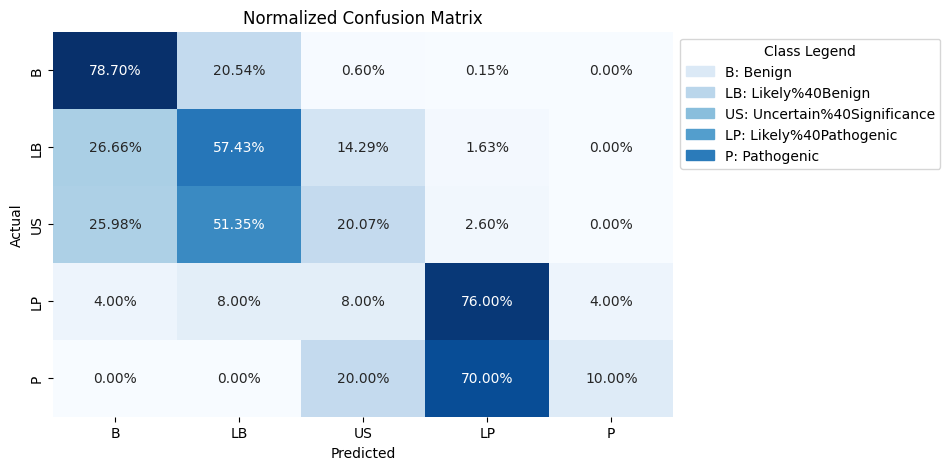

Classification report for Bagging with dataset Encoded - OneHot Nans, Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     76922
           1       0.68      0.66      0.67      5151
           2       0.80      0.63      0.71      6781
           3       0.45      0.20      0.28        25
           4       0.25      0.10      0.14        10

    accuracy                           0.94     88889
   macro avg       0.63      0.52      0.56     88889
weighted avg       0.94      0.94      0.94     88889



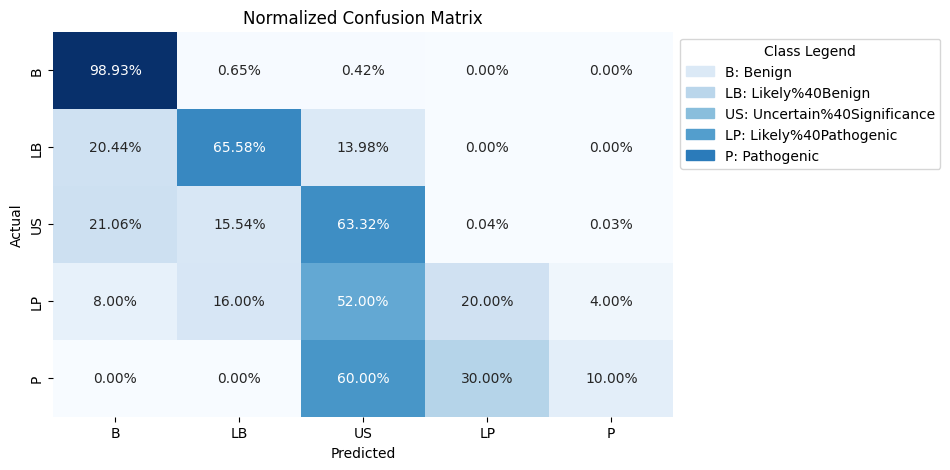

Classification report for Decision Tree with dataset Encoded - OneHot Nans, Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     76922
           1       0.58      0.58      0.58      5151
           2       0.61      0.63      0.62      6781
           3       0.24      0.16      0.19        25
           4       0.12      0.10      0.11        10

    accuracy                           0.92     88889
   macro avg       0.50      0.49      0.49     88889
weighted avg       0.92      0.92      0.92     88889



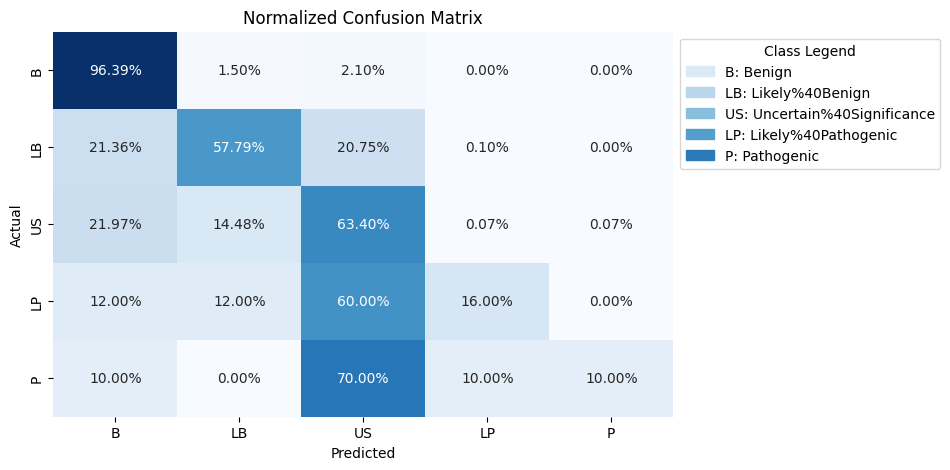

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression with dataset Encoded - OneHot Nans, Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.98      0.79      0.88     76922
           1       0.29      0.66      0.40      5151
           2       0.29      0.60      0.39      6781
           3       0.05      0.84      0.10        25
           4       0.08      0.30      0.13        10

    accuracy                           0.77     88889
   macro avg       0.34      0.64      0.38     88889
weighted avg       0.88      0.77      0.81     88889



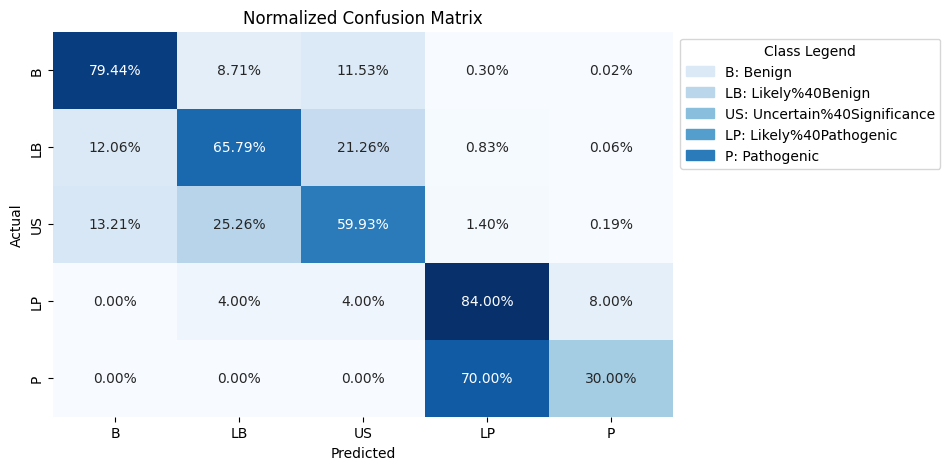

Classification report for Random Forest with dataset Encoded - OneHot Nans, Median and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     76922
           1       0.74      0.61      0.67      5151
           2       0.84      0.61      0.71      6781
           3       0.80      0.16      0.27        25
           4       0.50      0.10      0.17        10

    accuracy                           0.94     88889
   macro avg       0.77      0.50      0.56     88889
weighted avg       0.94      0.94      0.94     88889



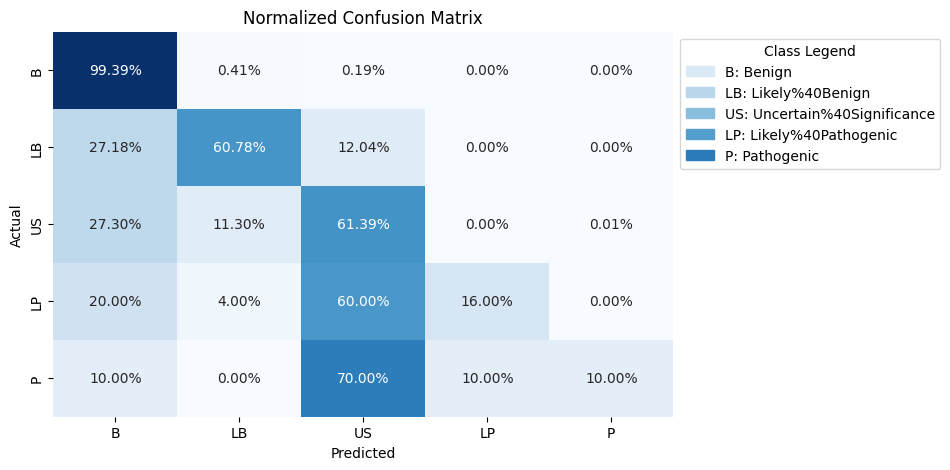

Classification report for AdaBoost with dataset Encoded - OneHot Nans, Median and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.96      0.64      0.77     76922
           1       0.09      0.58      0.16      5151
           2       0.44      0.29      0.35      6781
           3       0.04      0.80      0.07        25
           4       0.57      0.40      0.47        10

    accuracy                           0.61     88889
   macro avg       0.42      0.54      0.37     88889
weighted avg       0.87      0.61      0.70     88889



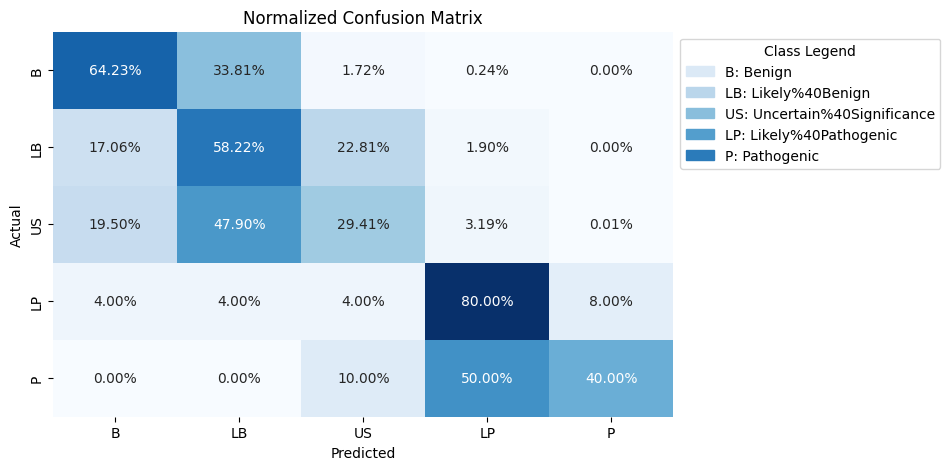

Classification report for Bagging with dataset Encoded - OneHot Nans, Median and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     76922
           1       0.69      0.66      0.67      5151
           2       0.80      0.63      0.70      6781
           3       0.56      0.20      0.29        25
           4       0.50      0.20      0.29        10

    accuracy                           0.94     88889
   macro avg       0.70      0.53      0.59     88889
weighted avg       0.94      0.94      0.94     88889



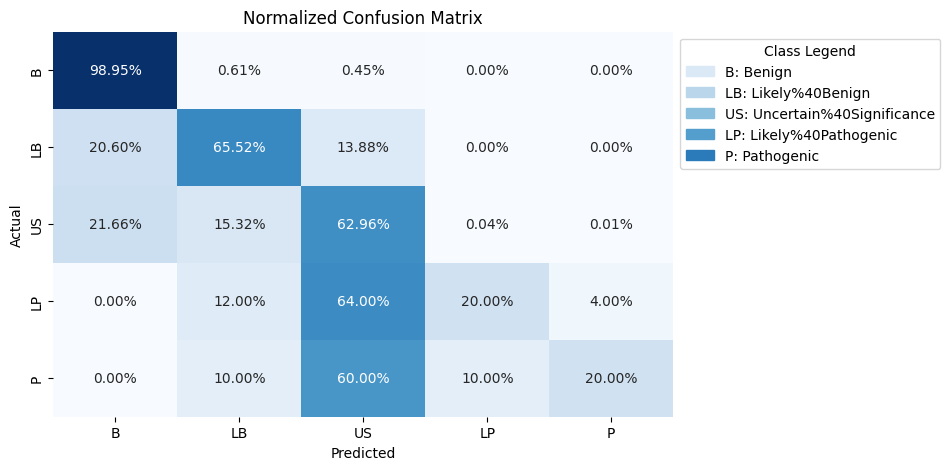

Classification report for Decision Tree with dataset Encoded - OneHot Nans, Median and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     76922
           1       0.58      0.58      0.58      5151
           2       0.62      0.64      0.63      6781
           3       0.27      0.24      0.26        25
           4       0.10      0.10      0.10        10

    accuracy                           0.92     88889
   macro avg       0.51      0.50      0.51     88889
weighted avg       0.92      0.92      0.92     88889



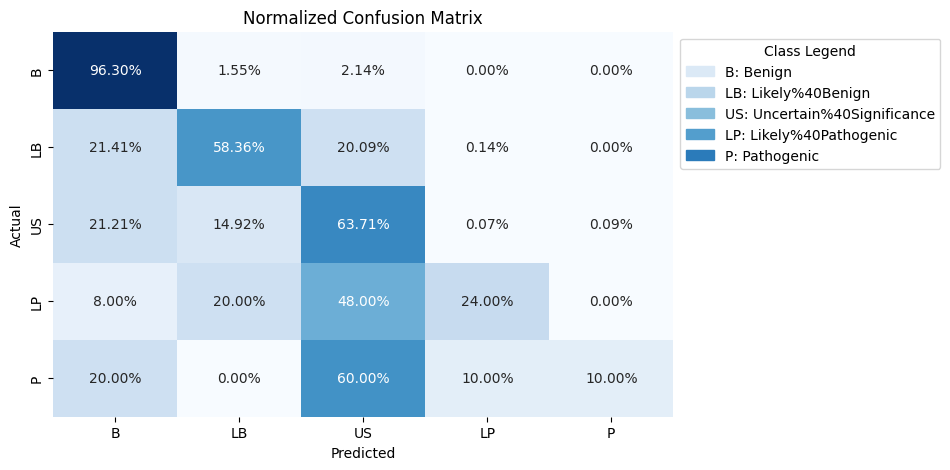

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression with dataset Encoded - OneHot Nans, Median and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     76922
           1       0.29      0.66      0.40      5151
           2       0.29      0.60      0.39      6781
           3       0.05      0.80      0.09        25
           4       0.09      0.30      0.13        10

    accuracy                           0.77     88889
   macro avg       0.34      0.63      0.38     88889
weighted avg       0.88      0.77      0.81     88889



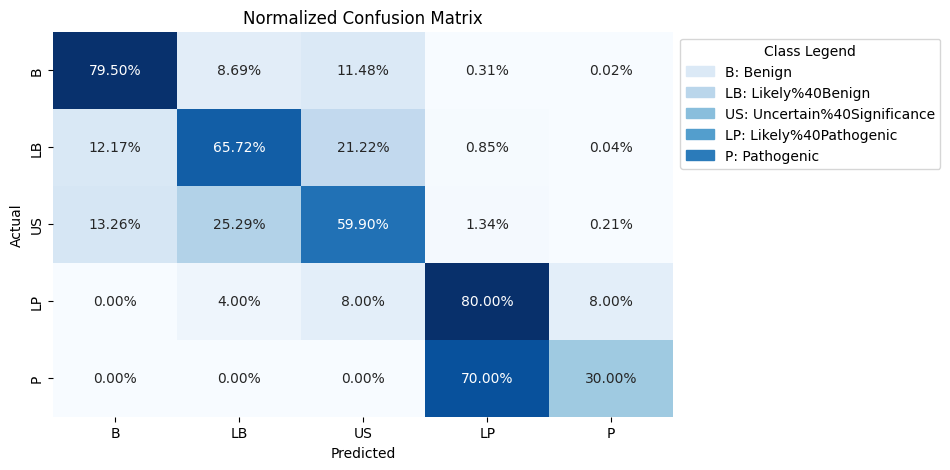

Classification report for Random Forest with dataset Encoded - Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     76922
           1       0.75      0.63      0.68      5151
           2       0.84      0.62      0.71      6781
           3       0.80      0.16      0.27        25
           4       0.50      0.10      0.17        10

    accuracy                           0.94     88889
   macro avg       0.77      0.50      0.56     88889
weighted avg       0.94      0.94      0.94     88889



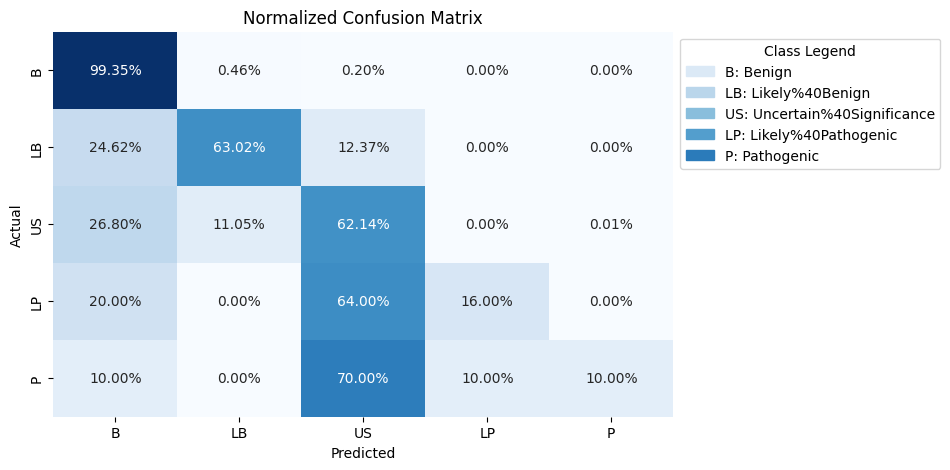

Classification report for AdaBoost with dataset Encoded - Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.95      0.79      0.86     76922
           1       0.13      0.57      0.22      5151
           2       0.53      0.20      0.29      6781
           3       0.05      0.76      0.09        25
           4       0.50      0.10      0.17        10

    accuracy                           0.73     88889
   macro avg       0.43      0.48      0.32     88889
weighted avg       0.87      0.73      0.78     88889



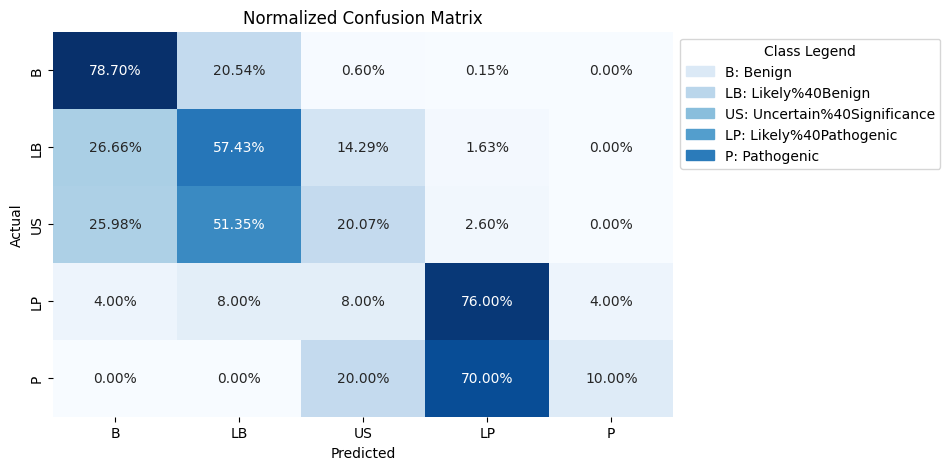

Classification report for Bagging with dataset Encoded - Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     76922
           1       0.68      0.65      0.67      5151
           2       0.80      0.63      0.71      6781
           3       0.56      0.20      0.29        25
           4       0.33      0.10      0.15        10

    accuracy                           0.94     88889
   macro avg       0.67      0.52      0.56     88889
weighted avg       0.94      0.94      0.94     88889



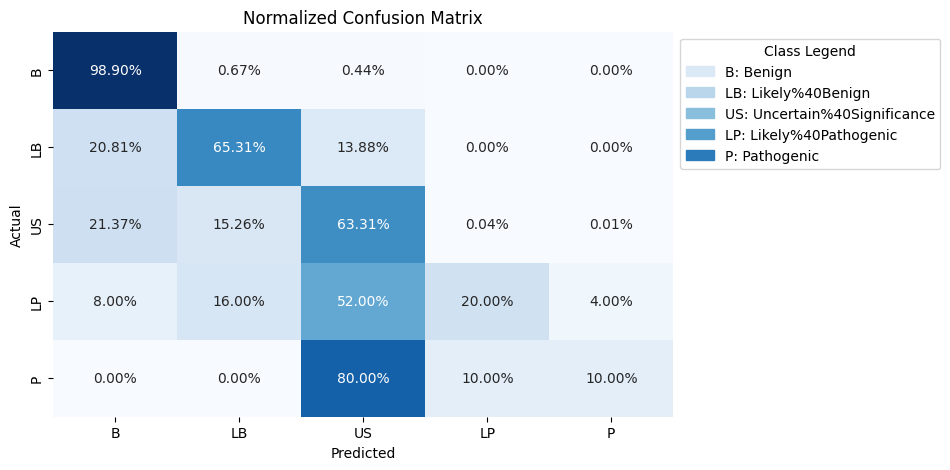

Classification report for Decision Tree with dataset Encoded - Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     76922
           1       0.58      0.58      0.58      5151
           2       0.62      0.63      0.62      6781
           3       0.17      0.16      0.16        25
           4       0.12      0.10      0.11        10

    accuracy                           0.92     88889
   macro avg       0.49      0.49      0.49     88889
weighted avg       0.92      0.92      0.92     88889



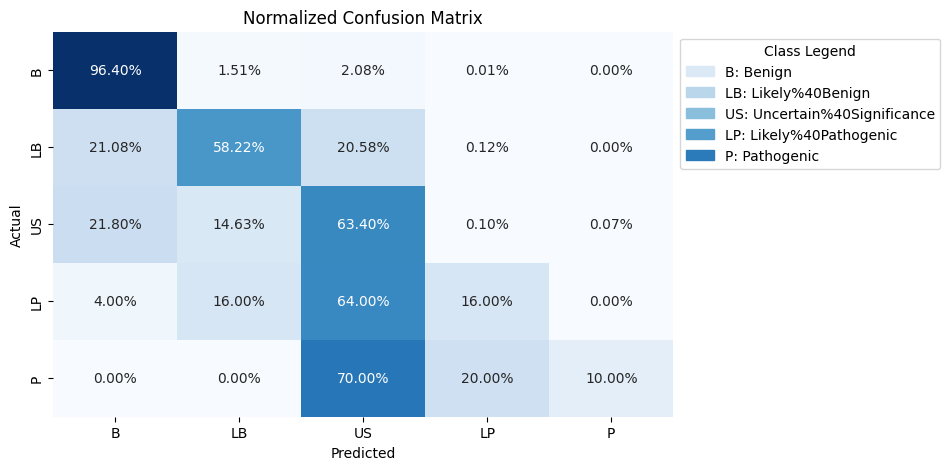

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression with dataset Encoded - Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.98      0.79      0.88     76922
           1       0.29      0.66      0.40      5151
           2       0.29      0.59      0.39      6781
           3       0.04      0.84      0.08        25
           4       0.04      0.20      0.07        10

    accuracy                           0.77     88889
   macro avg       0.33      0.62      0.36     88889
weighted avg       0.88      0.77      0.81     88889



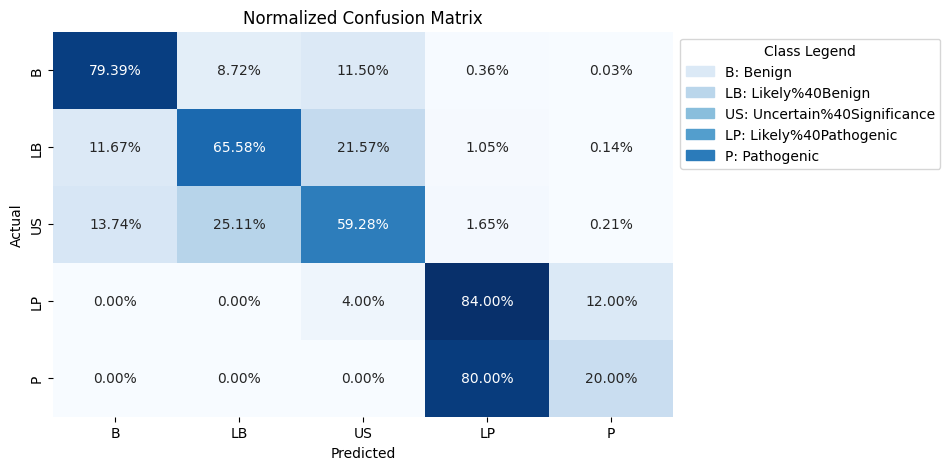

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Random Forest with dataset Encoded - OneHot Nans, Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     76922
           1       0.75      0.61      0.67      5151
           2       0.85      0.62      0.71      6781
           3       0.67      0.16      0.26        25
           4       0.00      0.00      0.00        10

    accuracy                           0.94     88889
   macro avg       0.64      0.48      0.52     88889
weighted avg       0.94      0.94      0.94     88889



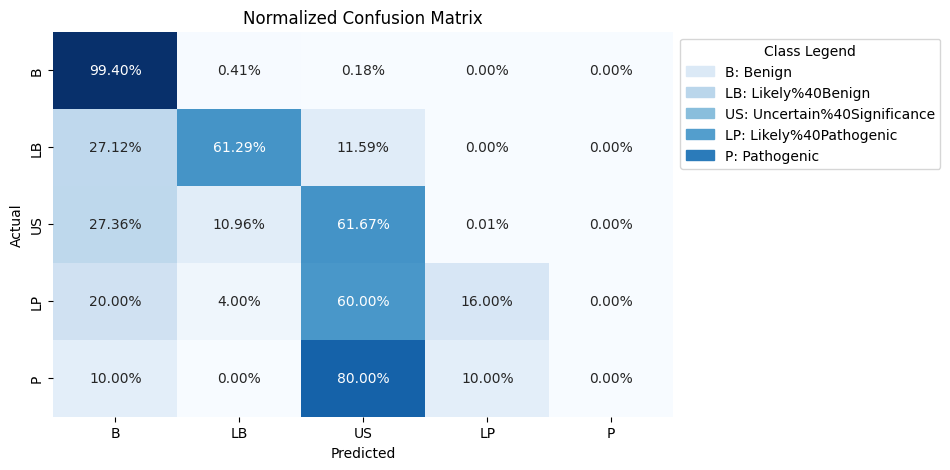

Classification report for AdaBoost with dataset Encoded - OneHot Nans, Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     76922
           1       0.14      0.41      0.21      5151
           2       0.59      0.25      0.35      6781
           3       0.04      0.80      0.08        25
           4       0.50      0.20      0.29        10

    accuracy                           0.78     88889
   macro avg       0.44      0.50      0.36     88889
weighted avg       0.86      0.78      0.81     88889



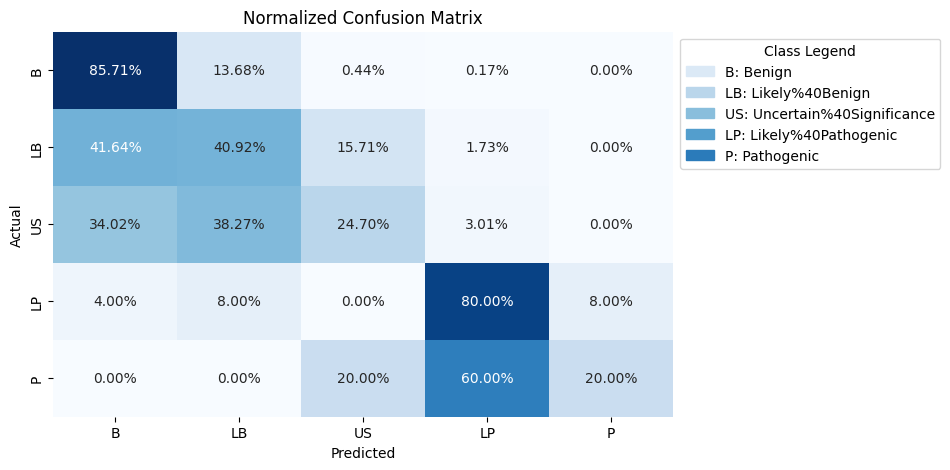

Classification report for Bagging with dataset Encoded - OneHot Nans, Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     76922
           1       0.69      0.66      0.68      5151
           2       0.80      0.63      0.71      6781
           3       0.50      0.20      0.29        25
           4       0.50      0.10      0.17        10

    accuracy                           0.94     88889
   macro avg       0.69      0.52      0.56     88889
weighted avg       0.94      0.94      0.94     88889



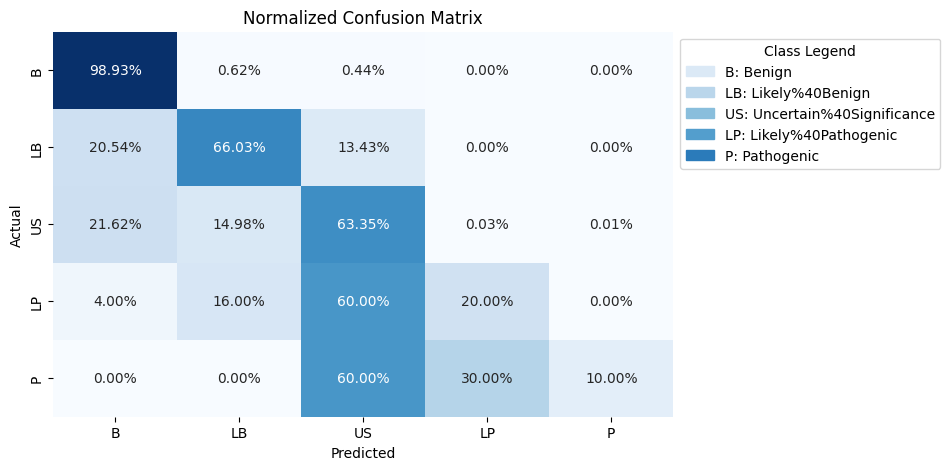

Classification report for Decision Tree with dataset Encoded - OneHot Nans, Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     76922
           1       0.58      0.58      0.58      5151
           2       0.62      0.64      0.63      6781
           3       0.18      0.16      0.17        25
           4       0.11      0.10      0.11        10

    accuracy                           0.92     88889
   macro avg       0.49      0.49      0.49     88889
weighted avg       0.92      0.92      0.92     88889



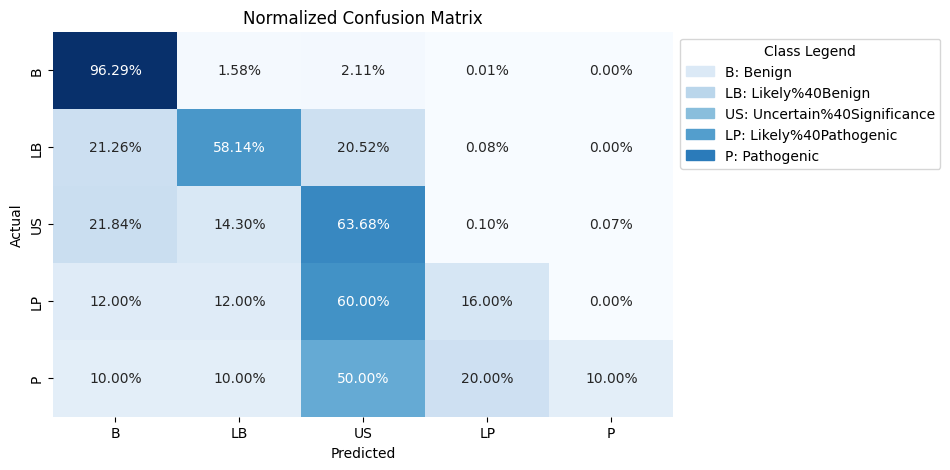

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression with dataset Encoded - OneHot Nans, Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.69      0.81     76922
           1       0.18      0.62      0.29      5151
           2       0.23      0.42      0.30      6781
           3       0.00      0.48      0.01        25
           4       0.01      0.80      0.01        10

    accuracy                           0.66     88889
   macro avg       0.28      0.60      0.28     88889
weighted avg       0.87      0.66      0.74     88889



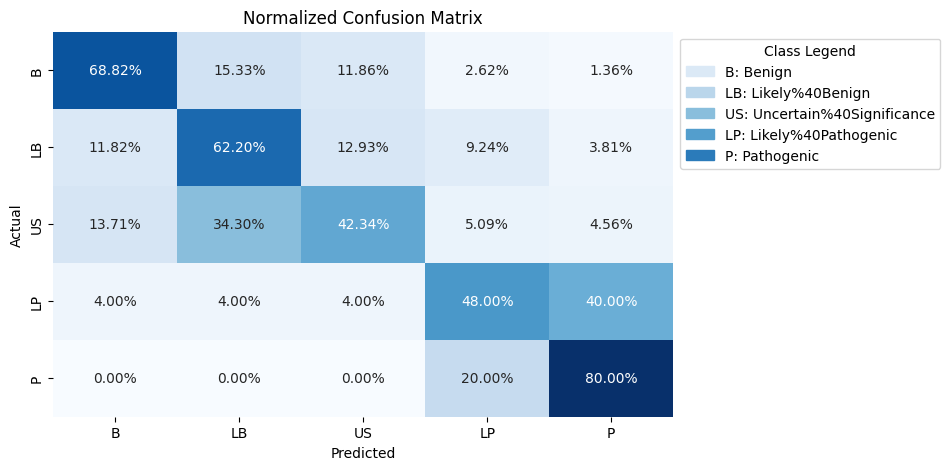

Classification report for Random Forest with dataset Encoded - OneHot Nans, Median and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     76922
           1       0.75      0.61      0.68      5151
           2       0.85      0.62      0.71      6781
           3       0.75      0.12      0.21        25
           4       0.00      0.00      0.00        10

    accuracy                           0.94     88889
   macro avg       0.66      0.47      0.51     88889
weighted avg       0.94      0.94      0.94     88889



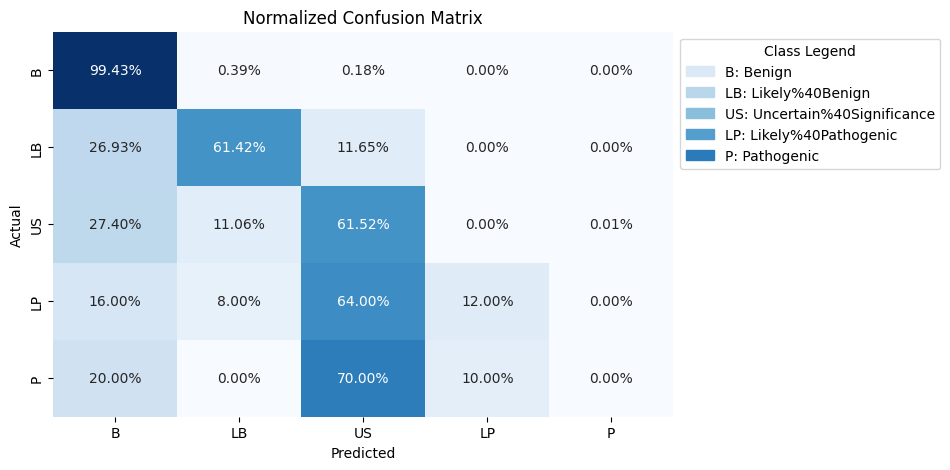

Classification report for AdaBoost with dataset Encoded - OneHot Nans, Median and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.60      0.74     76922
           1       0.09      0.68      0.16      5151
           2       0.56      0.22      0.32      6781
           3       0.04      0.76      0.08        25
           4       0.43      0.30      0.35        10

    accuracy                           0.57     88889
   macro avg       0.42      0.51      0.33     88889
weighted avg       0.88      0.57      0.67     88889



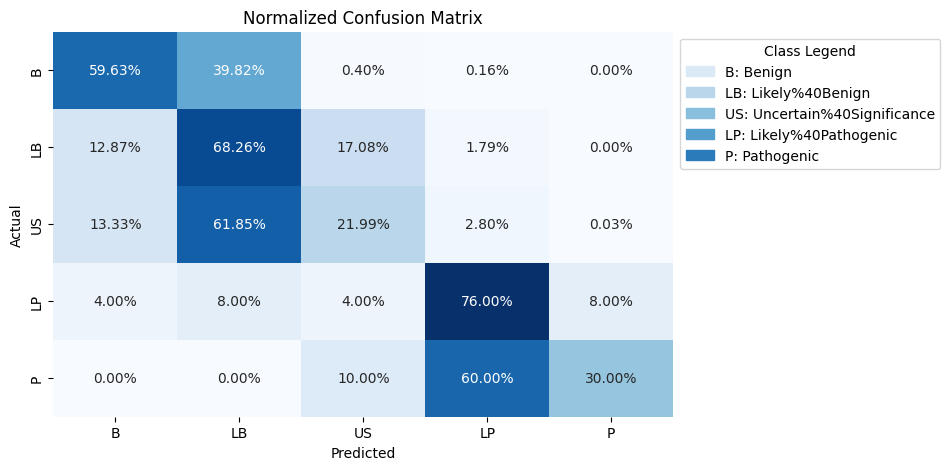

Classification report for Bagging with dataset Encoded - OneHot Nans, Median and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     76922
           1       0.69      0.66      0.68      5151
           2       0.80      0.63      0.70      6781
           3       0.50      0.16      0.24        25
           4       0.67      0.20      0.31        10

    accuracy                           0.94     88889
   macro avg       0.72      0.53      0.58     88889
weighted avg       0.94      0.94      0.94     88889



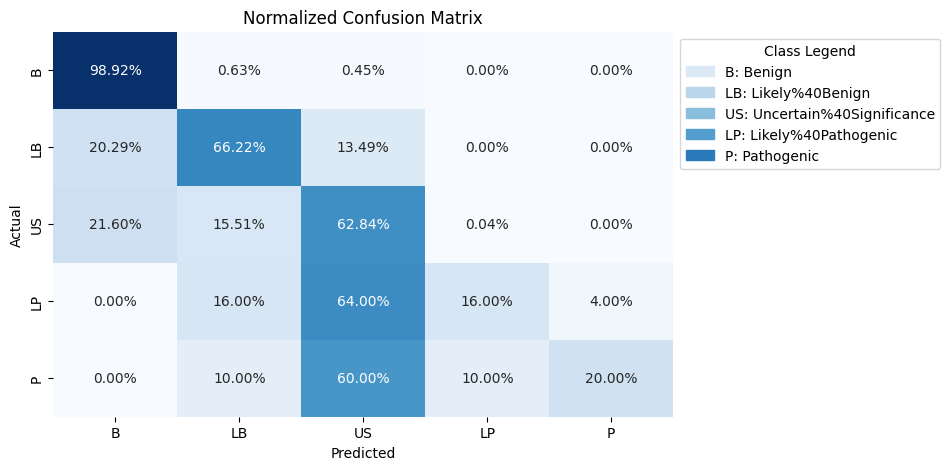

Classification report for Decision Tree with dataset Encoded - OneHot Nans, Median and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     76922
           1       0.58      0.58      0.58      5151
           2       0.62      0.64      0.63      6781
           3       0.30      0.24      0.27        25
           4       0.10      0.10      0.10        10

    accuracy                           0.92     88889
   macro avg       0.51      0.50      0.51     88889
weighted avg       0.92      0.92      0.92     88889



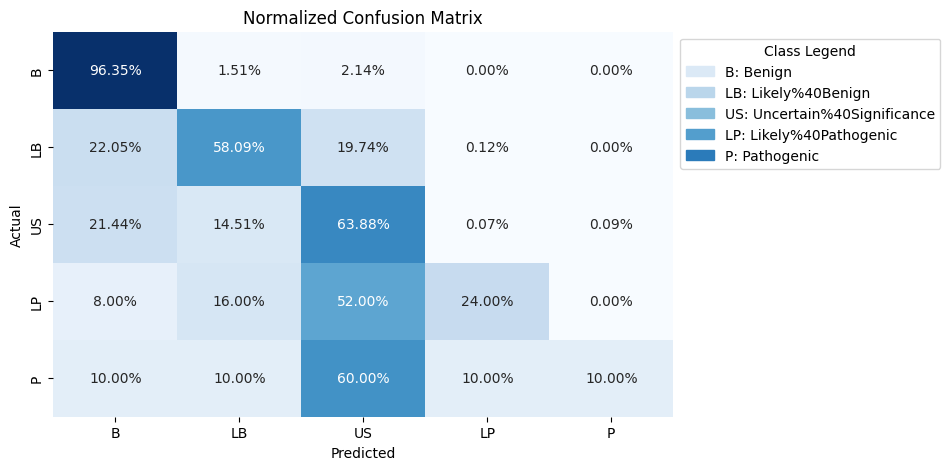

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression with dataset Encoded - OneHot Nans, Median and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.98      0.37      0.54     76922
           1       0.15      0.44      0.22      5151
           2       0.13      0.56      0.21      6781
           3       0.00      0.48      0.00        25
           4       0.00      0.70      0.00        10

    accuracy                           0.39     88889
   macro avg       0.25      0.51      0.20     88889
weighted avg       0.87      0.39      0.49     88889



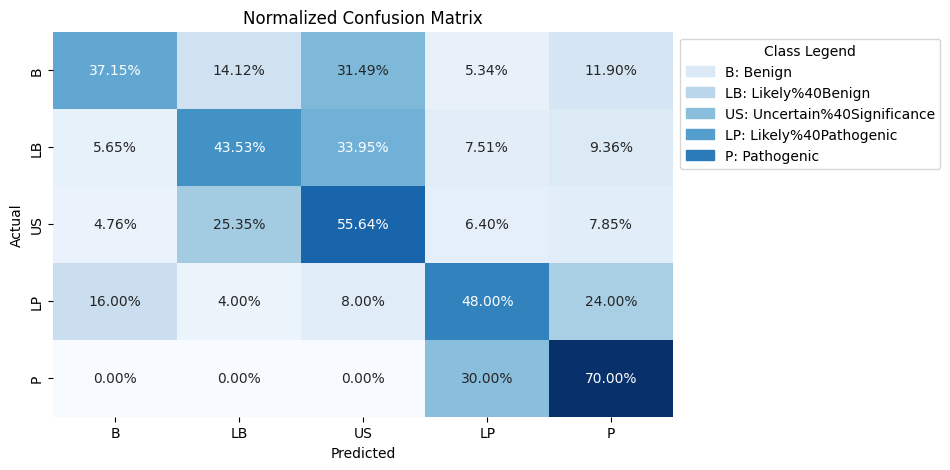

Classification report for Random Forest with dataset Encoded - Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     76922
           1       0.75      0.63      0.68      5151
           2       0.85      0.62      0.71      6781
           3       0.67      0.16      0.26        25
           4       0.50      0.10      0.17        10

    accuracy                           0.94     88889
   macro avg       0.74      0.50      0.56     88889
weighted avg       0.94      0.94      0.94     88889



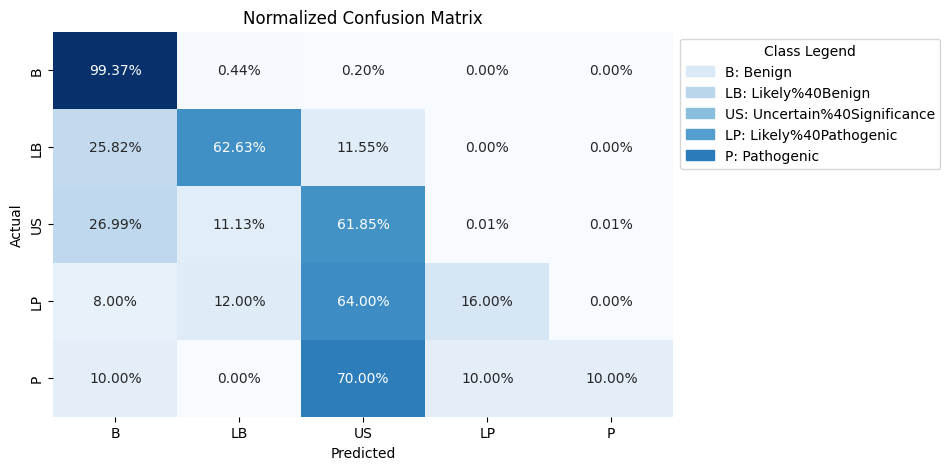

Classification report for AdaBoost with dataset Encoded - Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     76922
           1       0.14      0.41      0.21      5151
           2       0.59      0.25      0.35      6781
           3       0.04      0.80      0.08        25
           4       0.50      0.20      0.29        10

    accuracy                           0.78     88889
   macro avg       0.44      0.50      0.36     88889
weighted avg       0.86      0.78      0.81     88889



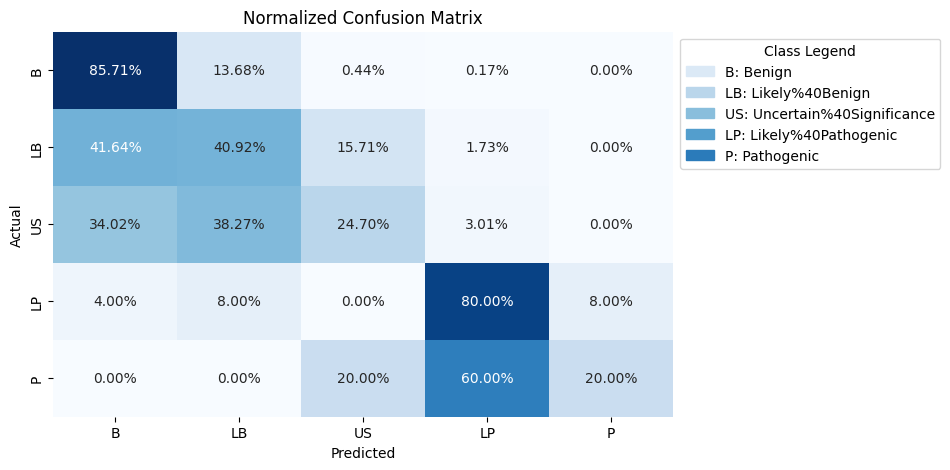

Classification report for Bagging with dataset Encoded - Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     76922
           1       0.69      0.66      0.67      5151
           2       0.80      0.63      0.71      6781
           3       0.42      0.20      0.27        25
           4       0.50      0.10      0.17        10

    accuracy                           0.94     88889
   macro avg       0.68      0.52      0.56     88889
weighted avg       0.94      0.94      0.94     88889



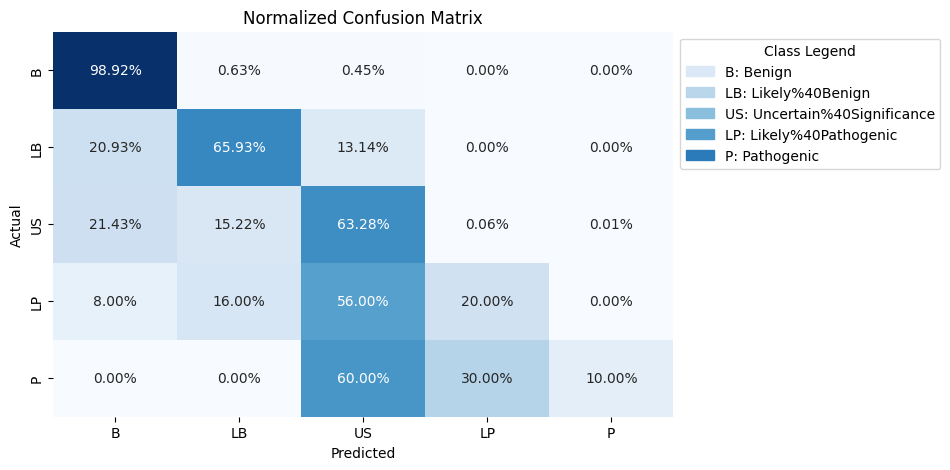

Classification report for Decision Tree with dataset Encoded - Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     76922
           1       0.59      0.58      0.58      5151
           2       0.62      0.64      0.63      6781
           3       0.22      0.20      0.21        25
           4       0.12      0.10      0.11        10

    accuracy                           0.92     88889
   macro avg       0.50      0.50      0.50     88889
weighted avg       0.92      0.92      0.92     88889



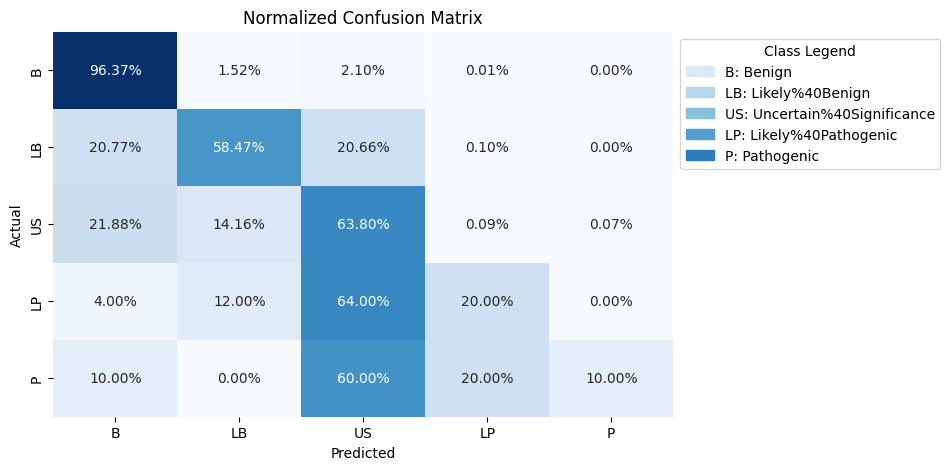

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression with dataset Encoded - Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.98      0.63      0.76     76922
           1       0.17      0.59      0.27      5151
           2       0.19      0.45      0.27      6781
           3       0.00      0.32      0.01        25
           4       0.00      0.90      0.01        10

    accuracy                           0.61     88889
   macro avg       0.27      0.58      0.26     88889
weighted avg       0.87      0.61      0.70     88889



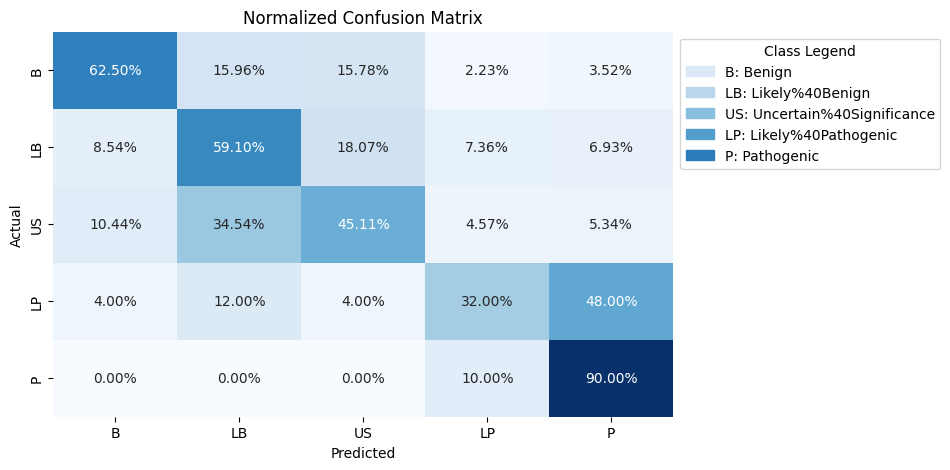

In [12]:
preprocessings = [
    ("None", None),
    ("MinMax", MinMaxScaler()),
    ("Robust", RobustScaler())
]

datasets = [
    ("Encoded - OneHot Nans, Outside Range", encoded_df1),
    ("Encoded - OneHot Nans, Median",encoded_df2),
    ("Encoded - Outside Range", encoded_df3)
]

for preprocessing_name, preprocessing_method in preprocessings:
    for dataset_name, dataset in datasets:
        X = dataset.drop(columns=['ACMG_class'])
        y = dataset['ACMG_class']

        if preprocessing_name != "None":
            X = pd.DataFrame(preprocessing_method.fit_transform(X), columns=X.columns)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        model_seed = 42

        class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)

        models = [
            ('Random Forest', RandomForestClassifier(class_weight=dict(enumerate(class_weights)), random_state=model_seed)),
            ('AdaBoost', AdaBoostClassifier(random_state=model_seed)),
            ('Bagging', BaggingClassifier(random_state=model_seed)),
            ('Decision Tree', DecisionTreeClassifier(class_weight=dict(enumerate(class_weights)), random_state=model_seed)),
            ('Logistic Regression', LogisticRegression(max_iter=1000, class_weight=dict(enumerate(class_weights)), random_state=model_seed)),
            
        ]

        for model_name, model in models:
            clf = model

            pipeline = Pipeline([
                ('classifier', clf)
            ])

            if model_name == 'AdaBoost':
                sample_weights = class_weights[np.searchsorted(np.unique(y_train), y_train)]
                pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weights)
            else:
                pipeline.fit(X_train, y_train)
            
            y_pred = pipeline.predict(X_test)
            report = classification_report(y_test, y_pred)
            print(f"Classification report for {model_name} with dataset {dataset_name} and preprocessing {preprocessing_name}:")
            print(report)

            get_confusion_matrix_plot(y_test, y_pred, inverted_mapping)

Classification report for CatBoost with dataset Encoded - OneHot Nans, Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     76922
           1       0.52      0.83      0.64      5151
           2       0.55      0.74      0.63      6781
           3       0.36      0.36      0.36        25
           4       0.40      0.20      0.27        10

    accuracy                           0.90     88889
   macro avg       0.56      0.61      0.57     88889
weighted avg       0.93      0.90      0.91     88889



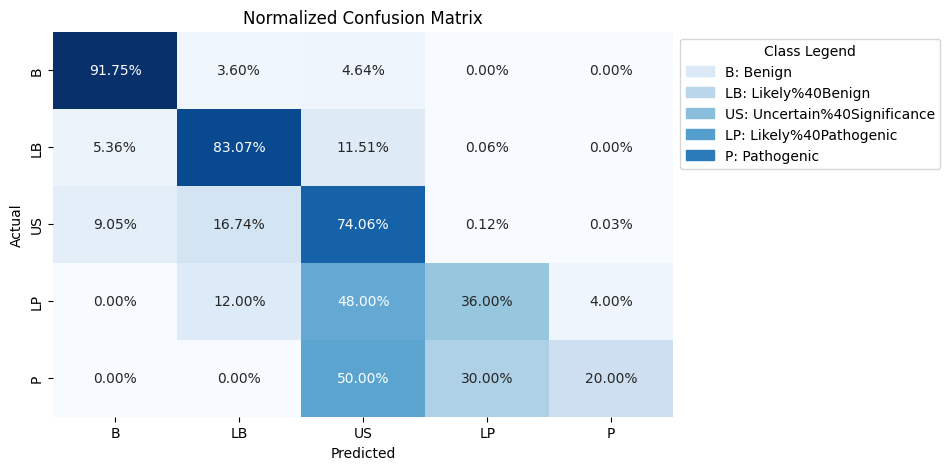

d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [18:28:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Classification report for XGBoost with dataset Encoded - OneHot Nans, Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     76922
           1       0.73      0.67      0.70      5151
           2       0.81      0.64      0.72      6781
           3       0.44      0.16      0.24        25
           4       0.50      0.20      0.29        10

    accuracy                           0.94     88889
   macro avg       0.69      0.53      0.58     88889
weighted avg       0.94      0.94      0.94     88889



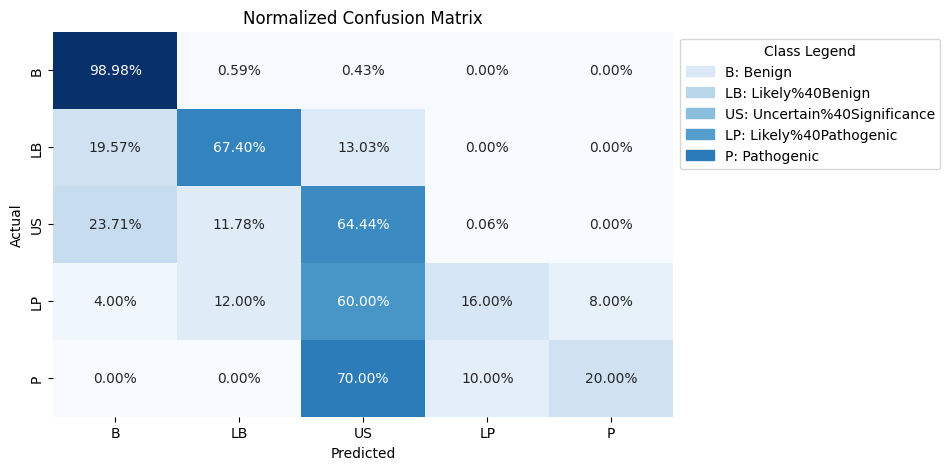

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9026
[LightGBM] [Info] Number of data points in the train set: 355555, number of used features: 155
[LightGBM] [Info] Start training from score -1.609036
[LightGBM] [Info] Start training from score -1.609045
[LightGBM] [Info] Start training from score -1.609021
[LightGBM] [Info] Start training from score -1.611054
[LightGBM] [Info] Start training from score -1.609035
Classification report for LightGBM with dataset Encoded - OneHot Nans, Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     76922
           1       0.50      0.83      0.63      5151
           2       0.54      0.73      0.62      6781
           3       0.47      0.32      0.38      

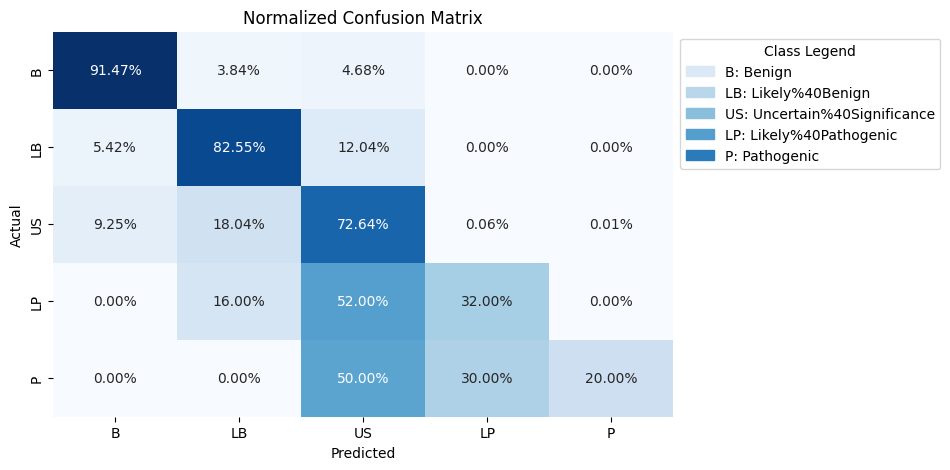

Classification report for Random Forest with dataset Encoded - OneHot Nans, Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     76922
           1       0.75      0.62      0.68      5151
           2       0.84      0.62      0.71      6781
           3       0.83      0.20      0.32        25
           4       0.50      0.10      0.17        10

    accuracy                           0.94     88889
   macro avg       0.78      0.51      0.57     88889
weighted avg       0.94      0.94      0.94     88889



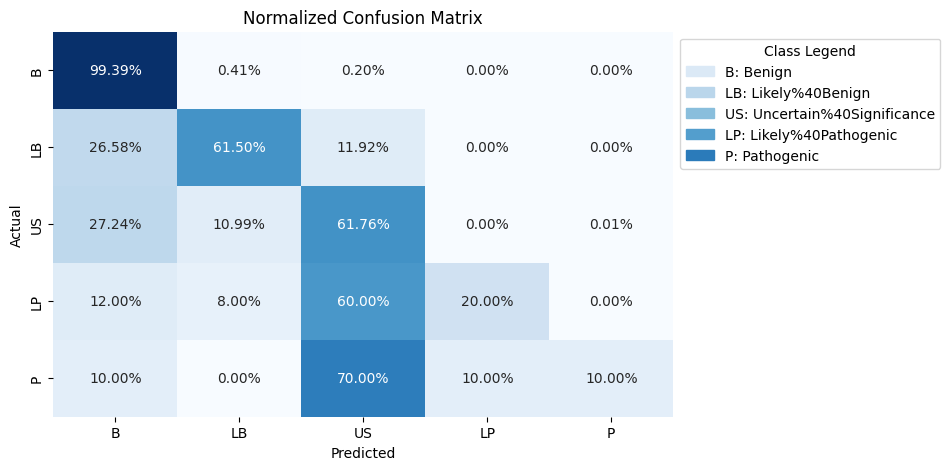

Classification report for AdaBoost with dataset Encoded - OneHot Nans, Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     76922
           1       0.14      0.41      0.21      5151
           2       0.59      0.25      0.35      6781
           3       0.04      0.80      0.08        25
           4       0.50      0.20      0.29        10

    accuracy                           0.78     88889
   macro avg       0.44      0.50      0.36     88889
weighted avg       0.86      0.78      0.81     88889



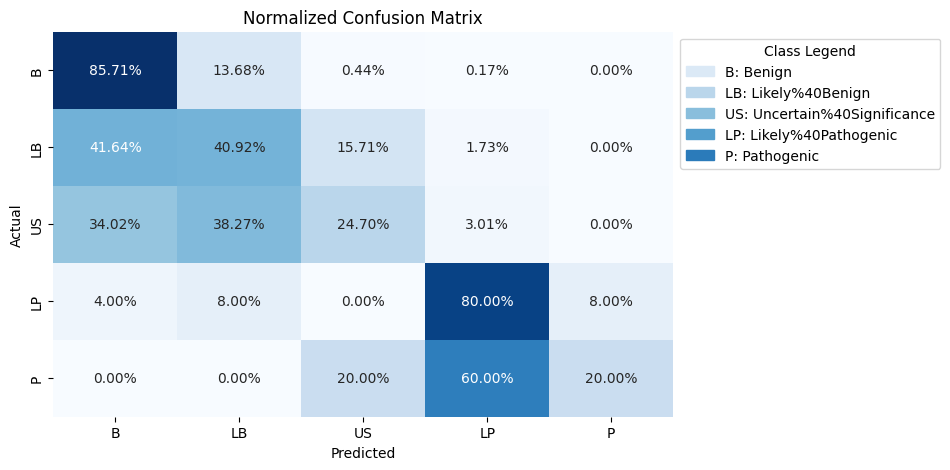

Classification report for Bagging with dataset Encoded - OneHot Nans, Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     76922
           1       0.69      0.66      0.68      5151
           2       0.80      0.63      0.71      6781
           3       0.56      0.20      0.29        25
           4       0.00      0.00      0.00        10

    accuracy                           0.94     88889
   macro avg       0.60      0.50      0.53     88889
weighted avg       0.94      0.94      0.94     88889



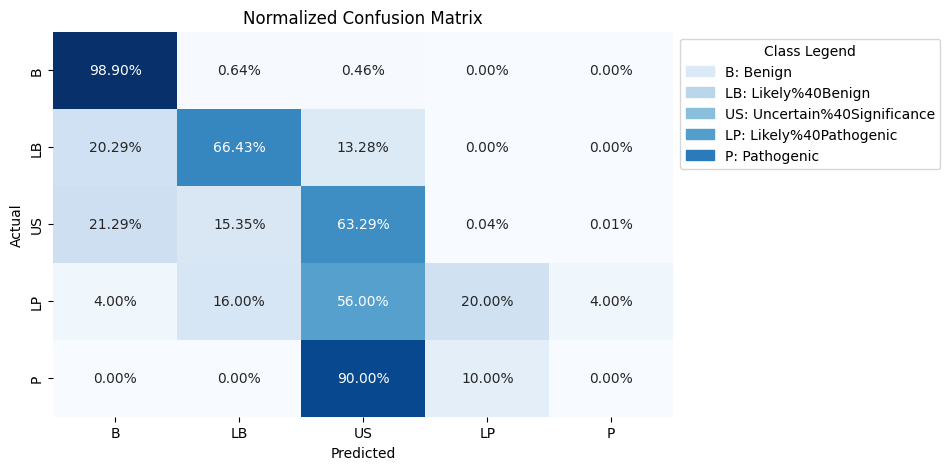

Classification report for Decision Tree with dataset Encoded - OneHot Nans, Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     76922
           1       0.58      0.58      0.58      5151
           2       0.62      0.64      0.63      6781
           3       0.26      0.20      0.23        25
           4       0.12      0.10      0.11        10

    accuracy                           0.92     88889
   macro avg       0.51      0.50      0.50     88889
weighted avg       0.92      0.92      0.92     88889



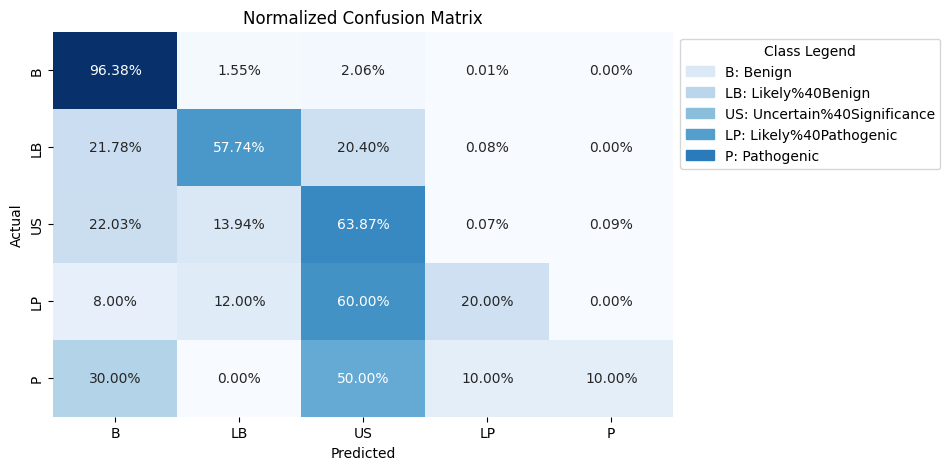

Classification report for Logistic Regression with dataset Encoded - OneHot Nans, Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.87      0.40      0.55     76922
           1       0.33      0.00      0.00      5151
           2       0.50      0.00      0.00      6781
           3       0.00      0.60      0.00        25
           4       0.00      0.00      0.00        10

    accuracy                           0.35     88889
   macro avg       0.34      0.20      0.11     88889
weighted avg       0.81      0.35      0.48     88889



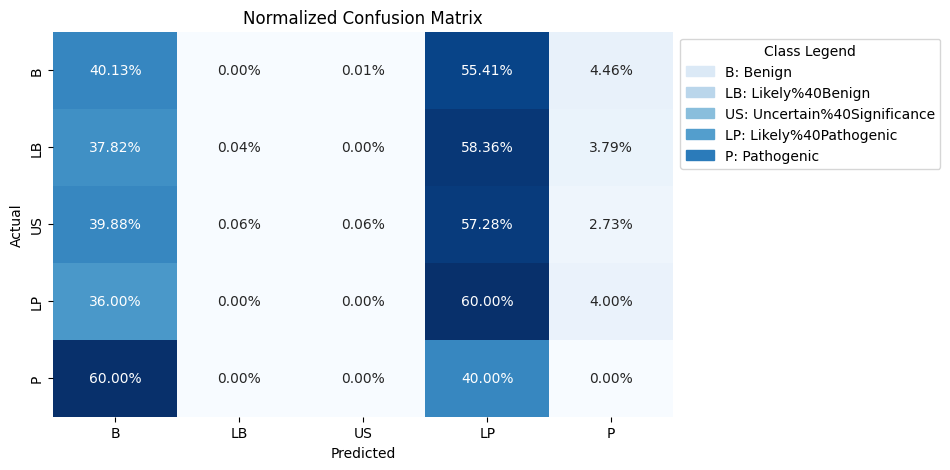

Classification report for CatBoost with dataset Encoded - OneHot Nans, Median and preprocessing None:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     76922
           1       0.52      0.82      0.63      5151
           2       0.54      0.74      0.62      6781
           3       0.35      0.36      0.35        25
           4       0.60      0.30      0.40        10

    accuracy                           0.90     88889
   macro avg       0.60      0.63      0.59     88889
weighted avg       0.93      0.90      0.91     88889



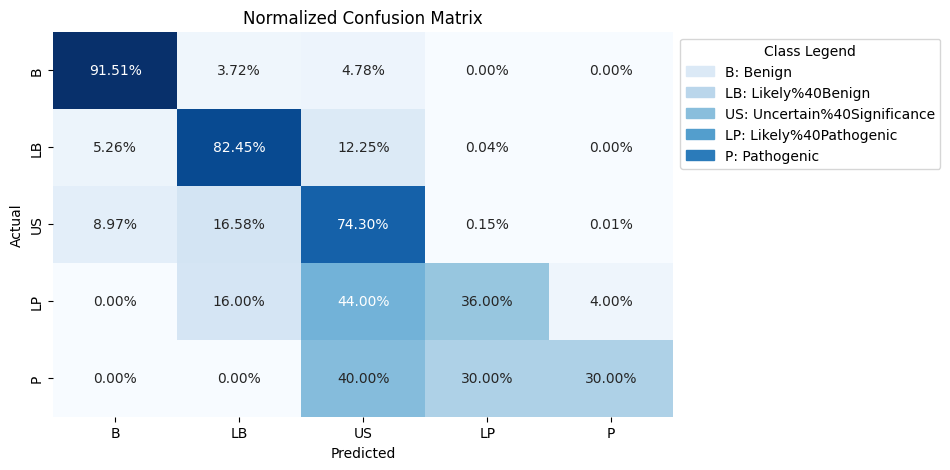

d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [18:42:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Classification report for XGBoost with dataset Encoded - OneHot Nans, Median and preprocessing None:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     76922
           1       0.73      0.67      0.70      5151
           2       0.81      0.64      0.71      6781
           3       0.62      0.20      0.30        25
           4       0.33      0.10      0.15        10

    accuracy                           0.94     88889
   macro avg       0.69      0.52      0.57     88889
weighted avg       0.94      0.94      0.94     88889



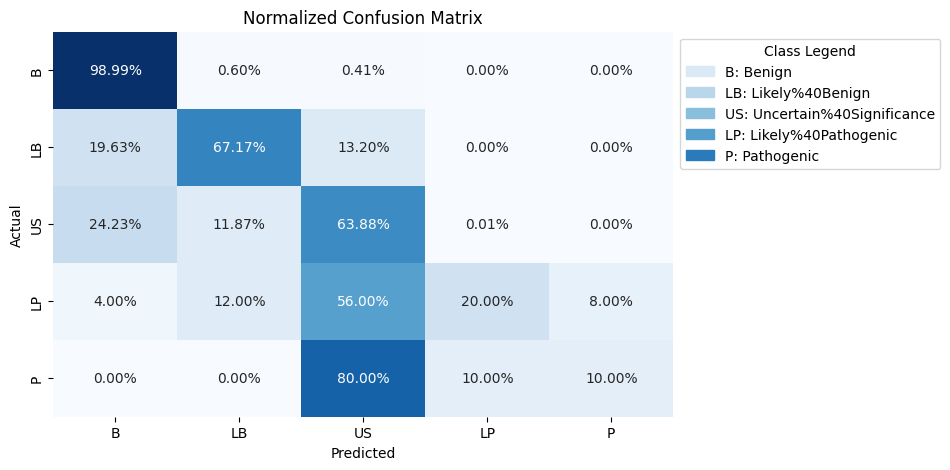

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8955
[LightGBM] [Info] Number of data points in the train set: 355555, number of used features: 154
[LightGBM] [Info] Start training from score -1.609036
[LightGBM] [Info] Start training from score -1.609045
[LightGBM] [Info] Start training from score -1.609021
[LightGBM] [Info] Start training from score -1.611054
[LightGBM] [Info] Start training from score -1.609035
Classification report for LightGBM with dataset Encoded - OneHot Nans, Median and preprocessing None:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     76922
           1       0.51      0.83      0.63      5151
           2       0.54      0.72      0.62      6781
           3       0.53      0.40      0.45        25
  

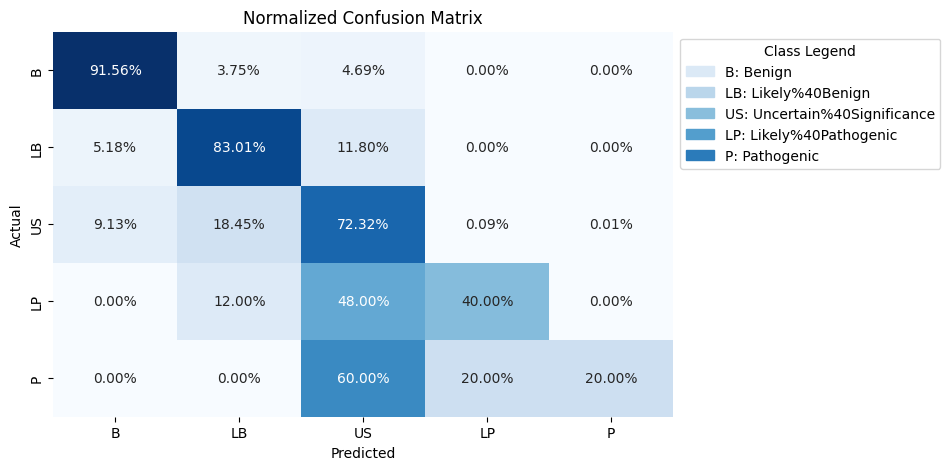

Classification report for Random Forest with dataset Encoded - OneHot Nans, Median and preprocessing None:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     76922
           1       0.75      0.61      0.67      5151
           2       0.84      0.62      0.71      6781
           3       0.75      0.12      0.21        25
           4       0.00      0.00      0.00        10

    accuracy                           0.94     88889
   macro avg       0.66      0.47      0.51     88889
weighted avg       0.94      0.94      0.94     88889



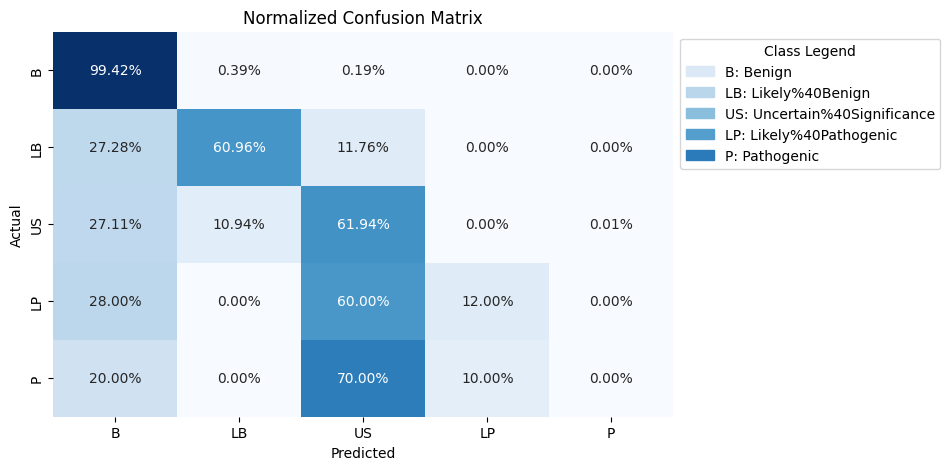

Classification report for AdaBoost with dataset Encoded - OneHot Nans, Median and preprocessing None:
              precision    recall  f1-score   support

           0       0.97      0.60      0.74     76922
           1       0.09      0.68      0.16      5151
           2       0.56      0.22      0.31      6781
           3       0.04      0.76      0.08        25
           4       0.43      0.30      0.35        10

    accuracy                           0.57     88889
   macro avg       0.42      0.51      0.33     88889
weighted avg       0.88      0.57      0.67     88889



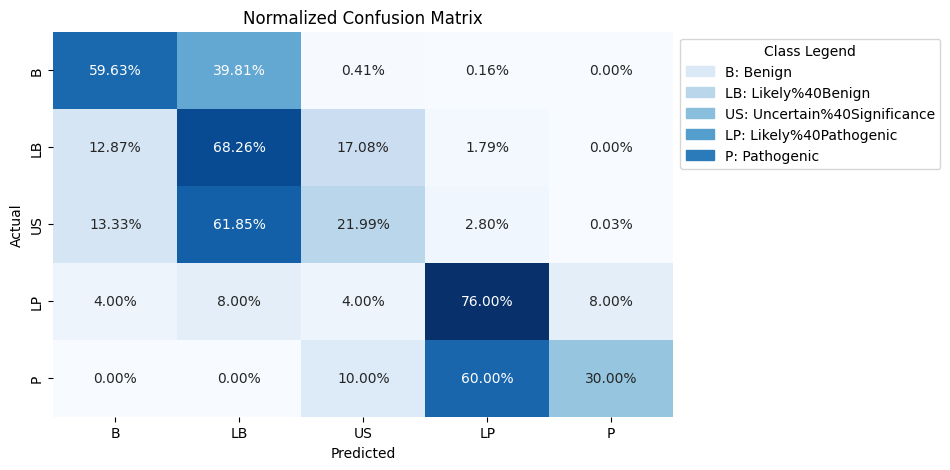

Classification report for Bagging with dataset Encoded - OneHot Nans, Median and preprocessing None:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     76922
           1       0.69      0.66      0.68      5151
           2       0.81      0.63      0.71      6781
           3       0.50      0.16      0.24        25
           4       0.50      0.20      0.29        10

    accuracy                           0.94     88889
   macro avg       0.69      0.53      0.58     88889
weighted avg       0.94      0.94      0.94     88889



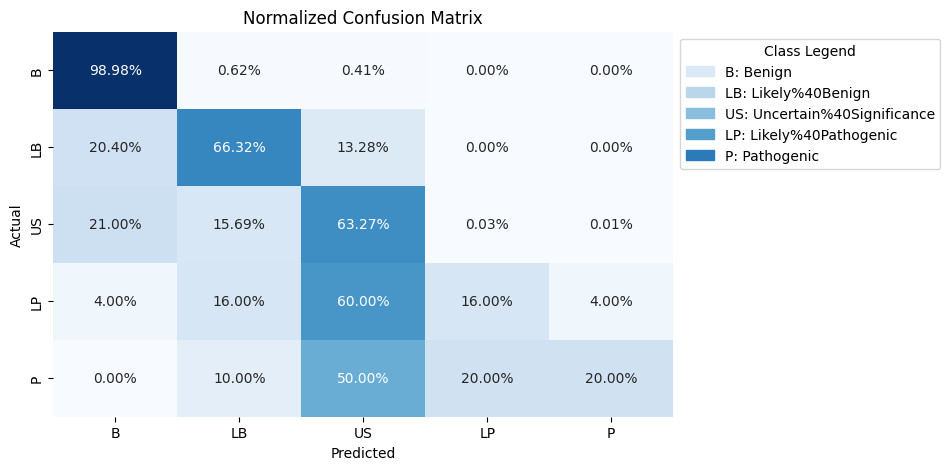

Classification report for Decision Tree with dataset Encoded - OneHot Nans, Median and preprocessing None:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     76922
           1       0.59      0.58      0.58      5151
           2       0.62      0.64      0.63      6781
           3       0.30      0.24      0.27        25
           4       0.11      0.10      0.11        10

    accuracy                           0.92     88889
   macro avg       0.52      0.51      0.51     88889
weighted avg       0.92      0.92      0.92     88889



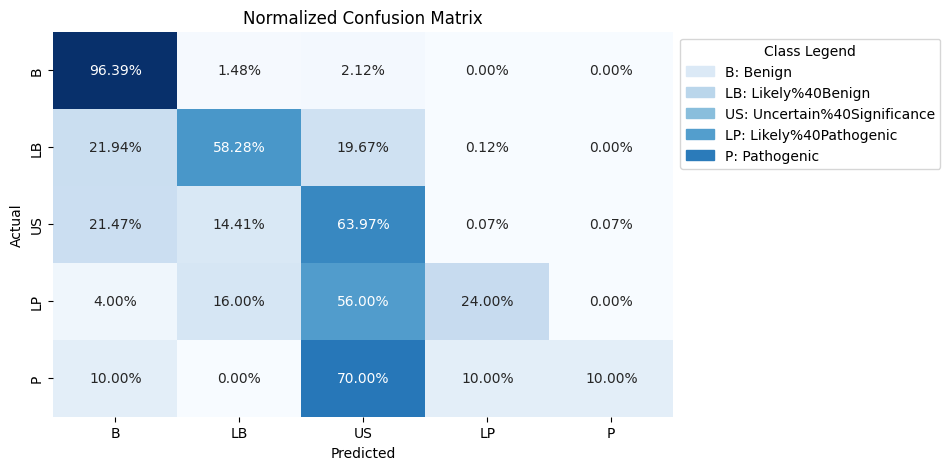

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Logistic Regression with dataset Encoded - OneHot Nans, Median and preprocessing None:
              precision    recall  f1-score   support

           0       0.91      0.40      0.55     76922
           1       0.00      0.00      0.00      5151
           2       0.18      0.22      0.20      6781
           3       0.00      0.52      0.00        25
           4       0.00      0.00      0.00        10

    accuracy                           0.36     88889
   macro avg       0.22      0.23      0.15     88889
weighted avg       0.80      0.36      0.49     88889



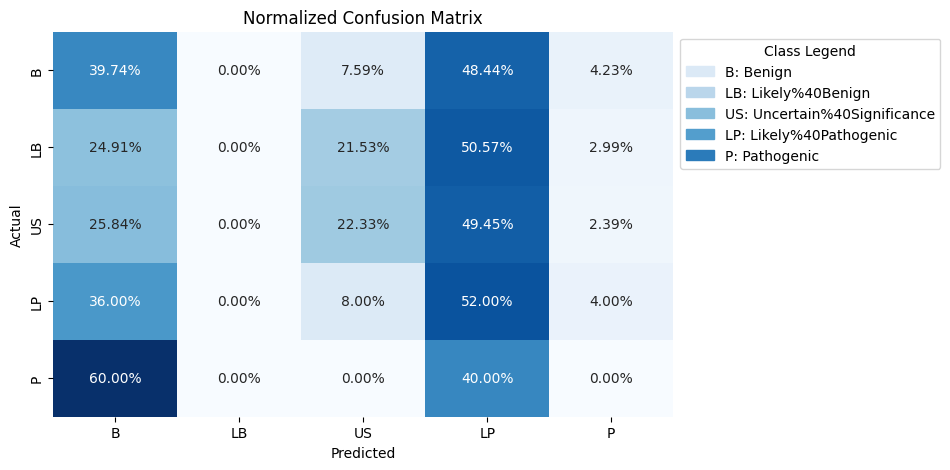

Classification report for CatBoost with dataset Encoded - Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     76922
           1       0.52      0.83      0.64      5151
           2       0.54      0.74      0.63      6781
           3       0.32      0.32      0.32        25
           4       0.57      0.40      0.47        10

    accuracy                           0.90     88889
   macro avg       0.59      0.64      0.60     88889
weighted avg       0.93      0.90      0.91     88889



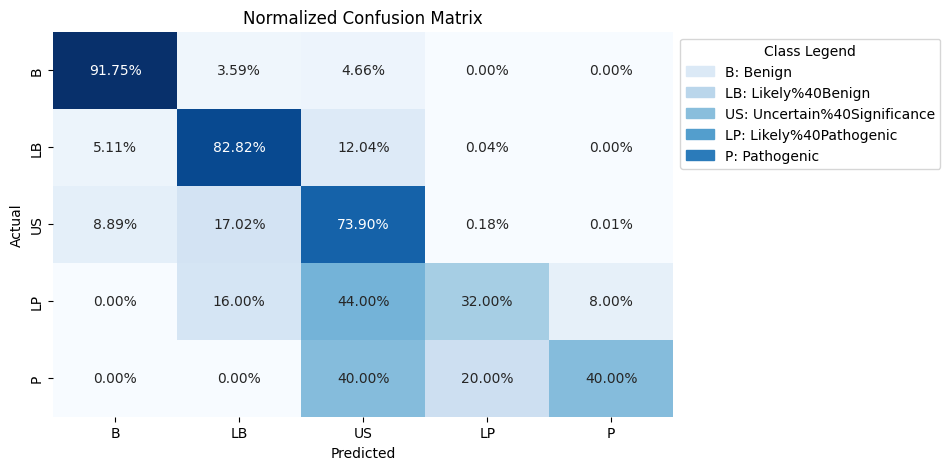

d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [18:56:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Classification report for XGBoost with dataset Encoded - Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     76922
           1       0.73      0.67      0.70      5151
           2       0.81      0.65      0.72      6781
           3       0.56      0.20      0.29        25
           4       0.50      0.20      0.29        10

    accuracy                           0.94     88889
   macro avg       0.71      0.54      0.60     88889
weighted avg       0.94      0.94      0.94     88889



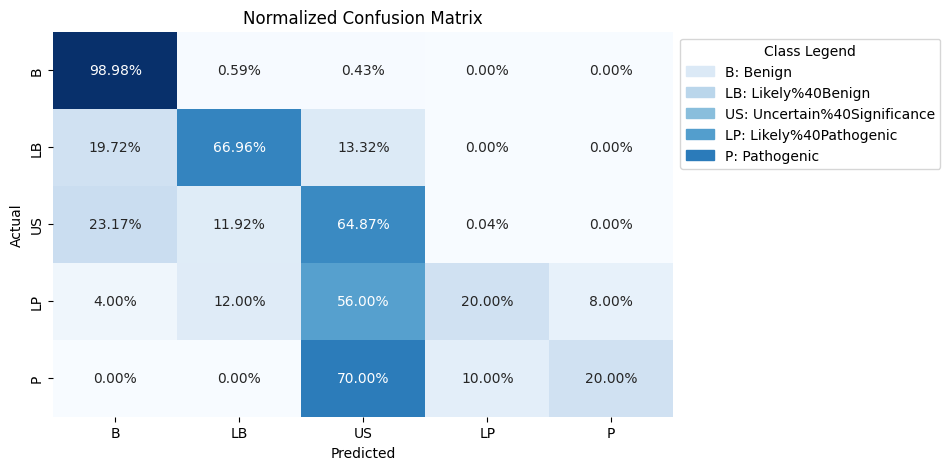

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8922
[LightGBM] [Info] Number of data points in the train set: 355555, number of used features: 103
[LightGBM] [Info] Start training from score -1.609036
[LightGBM] [Info] Start training from score -1.609045
[LightGBM] [Info] Start training from score -1.609021
[LightGBM] [Info] Start training from score -1.611054
[LightGBM] [Info] Start training from score -1.609035
Classification report for LightGBM with dataset Encoded - Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     76922
           1       0.50      0.83      0.63      5151
           2       0.54      0.72      0.62      6781
           3       0.40      0.32      0.36        25
        

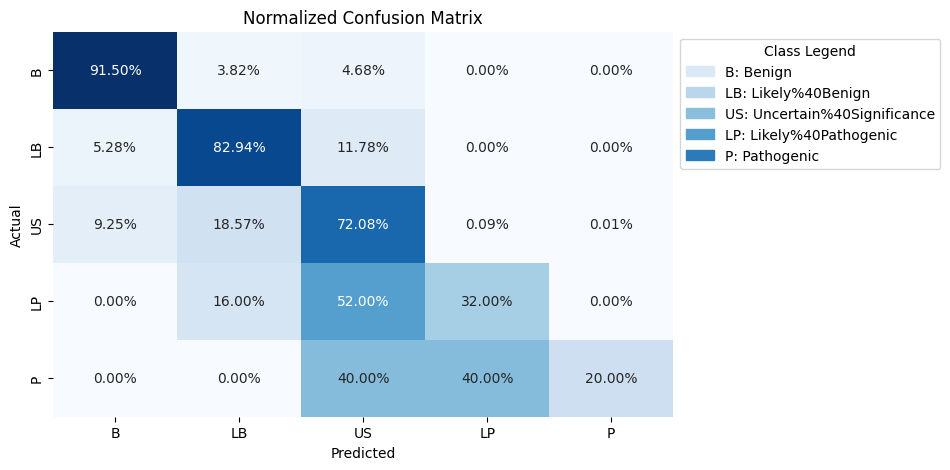

Classification report for Random Forest with dataset Encoded - Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     76922
           1       0.75      0.63      0.68      5151
           2       0.84      0.62      0.71      6781
           3       0.67      0.16      0.26        25
           4       0.00      0.00      0.00        10

    accuracy                           0.94     88889
   macro avg       0.64      0.48      0.53     88889
weighted avg       0.94      0.94      0.94     88889



d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


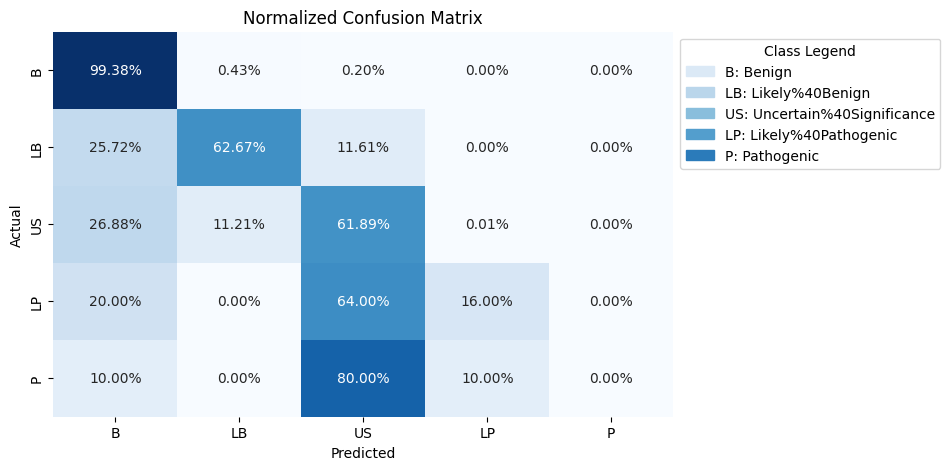

Classification report for AdaBoost with dataset Encoded - Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     76922
           1       0.14      0.41      0.21      5151
           2       0.59      0.25      0.35      6781
           3       0.04      0.80      0.08        25
           4       0.50      0.20      0.29        10

    accuracy                           0.78     88889
   macro avg       0.44      0.50      0.36     88889
weighted avg       0.86      0.78      0.81     88889



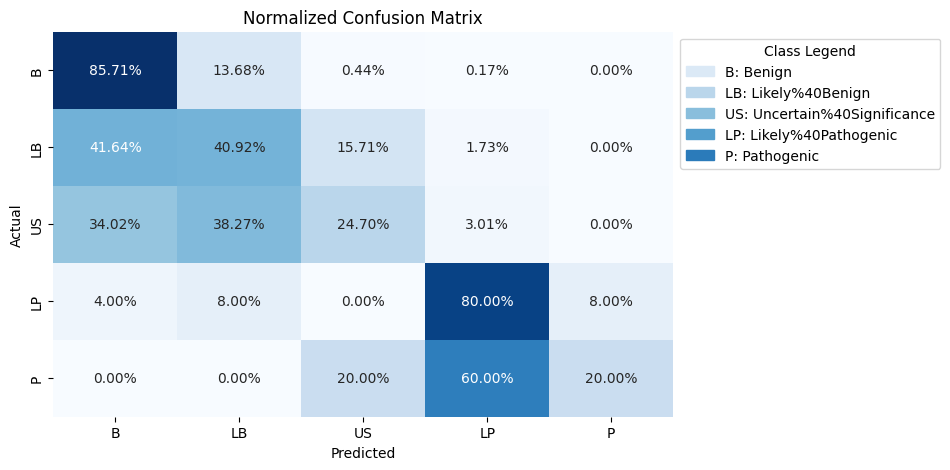

Classification report for Bagging with dataset Encoded - Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     76922
           1       0.69      0.66      0.68      5151
           2       0.80      0.63      0.71      6781
           3       0.38      0.20      0.26        25
           4       0.50      0.20      0.29        10

    accuracy                           0.94     88889
   macro avg       0.67      0.54      0.58     88889
weighted avg       0.94      0.94      0.94     88889



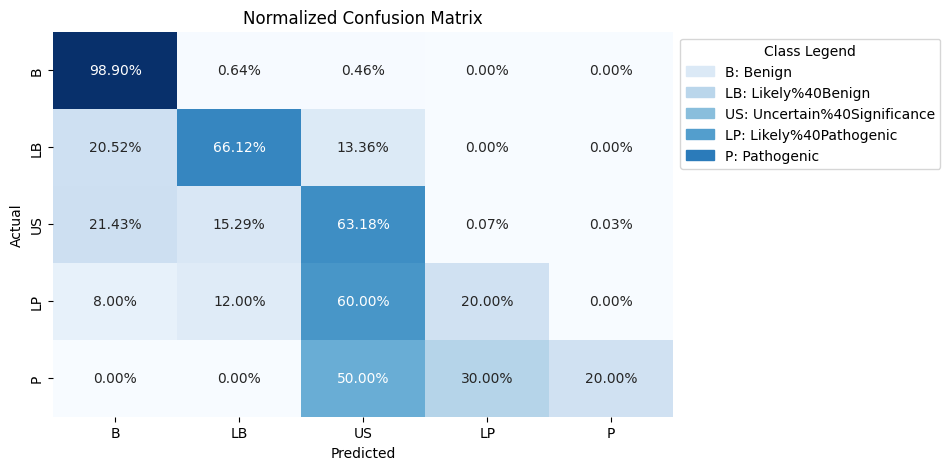

Classification report for Decision Tree with dataset Encoded - Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     76922
           1       0.58      0.58      0.58      5151
           2       0.62      0.63      0.62      6781
           3       0.19      0.16      0.17        25
           4       0.11      0.10      0.11        10

    accuracy                           0.92     88889
   macro avg       0.49      0.49      0.49     88889
weighted avg       0.92      0.92      0.92     88889



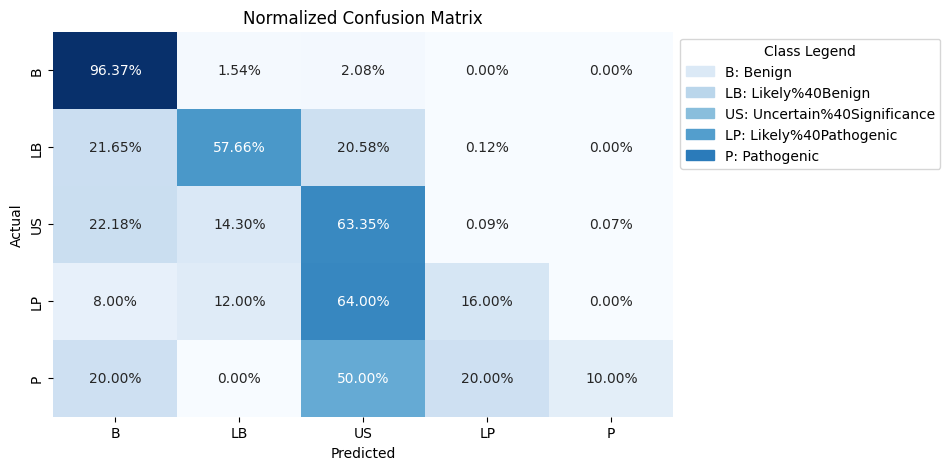

Classification report for Logistic Regression with dataset Encoded - Outside Range and preprocessing None:
              precision    recall  f1-score   support

           0       0.87      0.40      0.55     76922
           1       0.33      0.00      0.00      5151
           2       0.50      0.00      0.00      6781
           3       0.00      0.60      0.00        25
           4       0.00      0.00      0.00        10

    accuracy                           0.35     88889
   macro avg       0.34      0.20      0.11     88889
weighted avg       0.81      0.35      0.48     88889



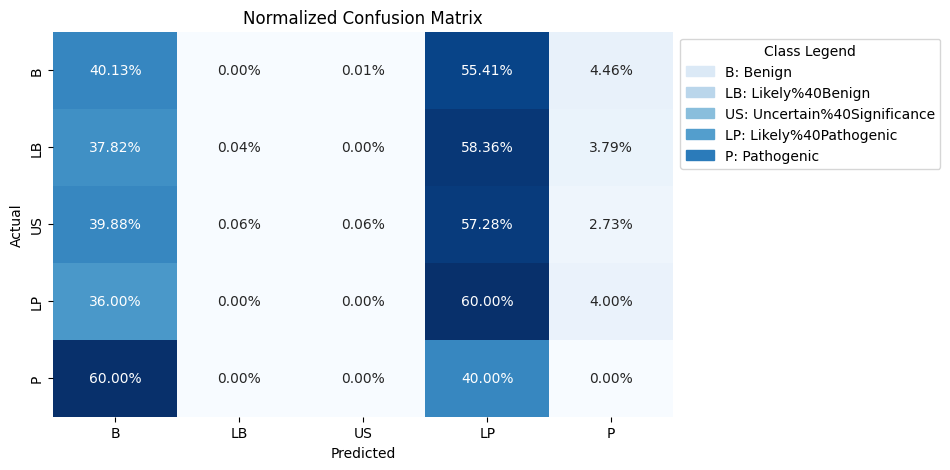

Classification report for CatBoost with dataset Encoded - OneHot Nans, Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     76922
           1       0.52      0.83      0.64      5151
           2       0.55      0.74      0.63      6781
           3       0.36      0.36      0.36        25
           4       0.50      0.30      0.37        10

    accuracy                           0.90     88889
   macro avg       0.58      0.63      0.59     88889
weighted avg       0.93      0.90      0.91     88889



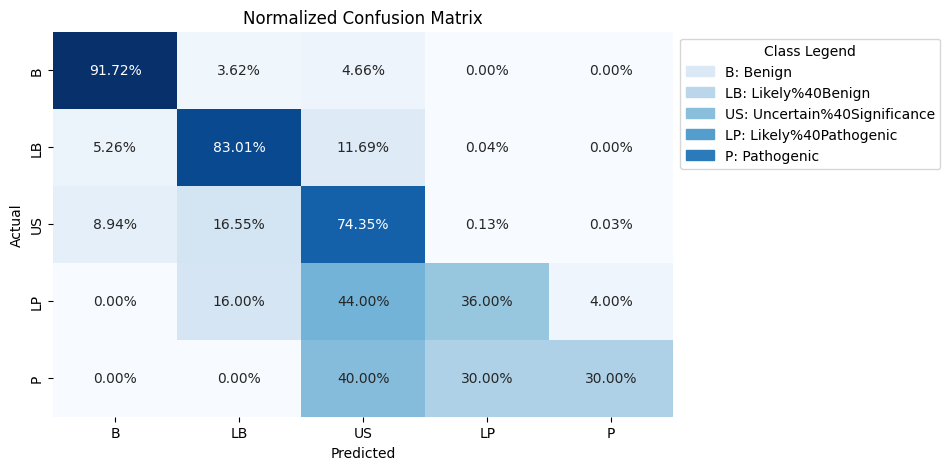

d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [19:09:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Classification report for XGBoost with dataset Encoded - OneHot Nans, Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     76922
           1       0.73      0.67      0.70      5151
           2       0.81      0.64      0.71      6781
           3       0.62      0.20      0.30        25
           4       0.50      0.20      0.29        10

    accuracy                           0.94     88889
   macro avg       0.73      0.54      0.60     88889
weighted avg       0.94      0.94      0.94     88889



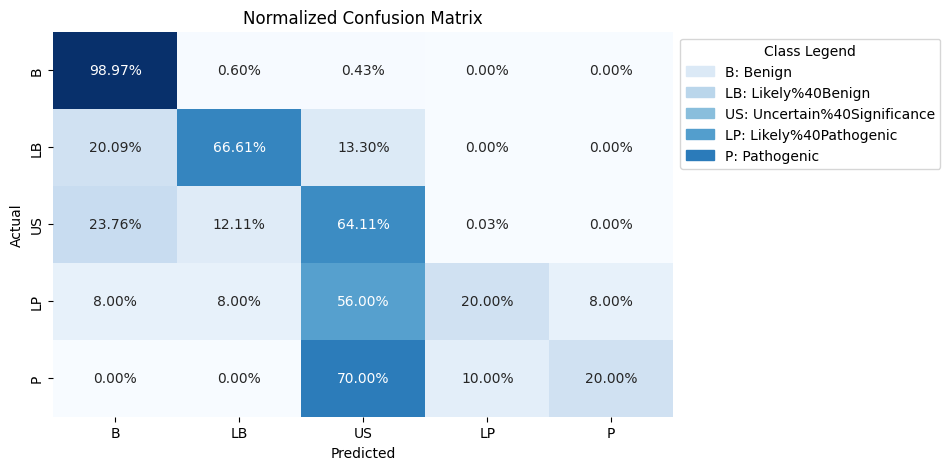

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9016
[LightGBM] [Info] Number of data points in the train set: 355555, number of used features: 155
[LightGBM] [Info] Start training from score -1.609036
[LightGBM] [Info] Start training from score -1.609045
[LightGBM] [Info] Start training from score -1.609021
[LightGBM] [Info] Start training from score -1.611054
[LightGBM] [Info] Start training from score -1.609035
Classification report for LightGBM with dataset Encoded - OneHot Nans, Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     76922
           1       0.50      0.82      0.63      5151
           2       0.54      0.73      0.62      6781
           3       0.45      0.40      0.43    

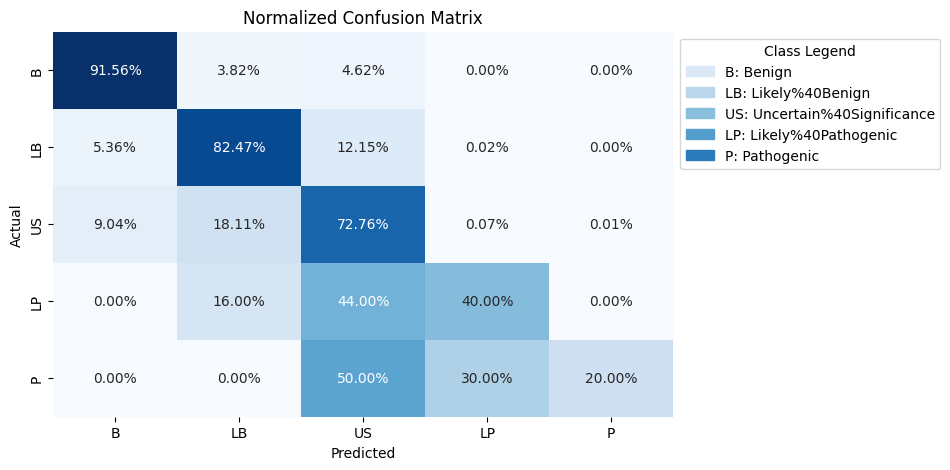

Classification report for Random Forest with dataset Encoded - OneHot Nans, Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     76922
           1       0.75      0.62      0.68      5151
           2       0.84      0.62      0.71      6781
           3       0.83      0.20      0.32        25
           4       0.00      0.00      0.00        10

    accuracy                           0.94     88889
   macro avg       0.68      0.49      0.54     88889
weighted avg       0.94      0.94      0.94     88889



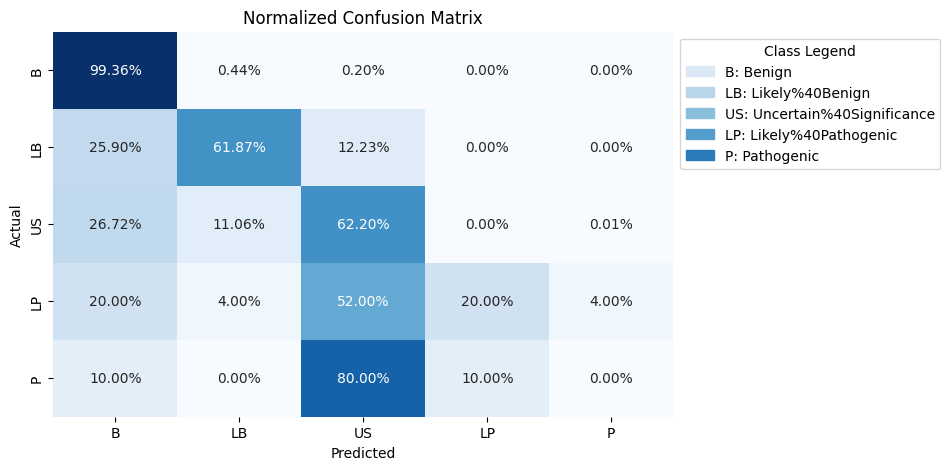

Classification report for AdaBoost with dataset Encoded - OneHot Nans, Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.95      0.79      0.86     76922
           1       0.13      0.57      0.22      5151
           2       0.53      0.20      0.29      6781
           3       0.05      0.76      0.09        25
           4       0.50      0.10      0.17        10

    accuracy                           0.73     88889
   macro avg       0.43      0.48      0.32     88889
weighted avg       0.87      0.73      0.78     88889



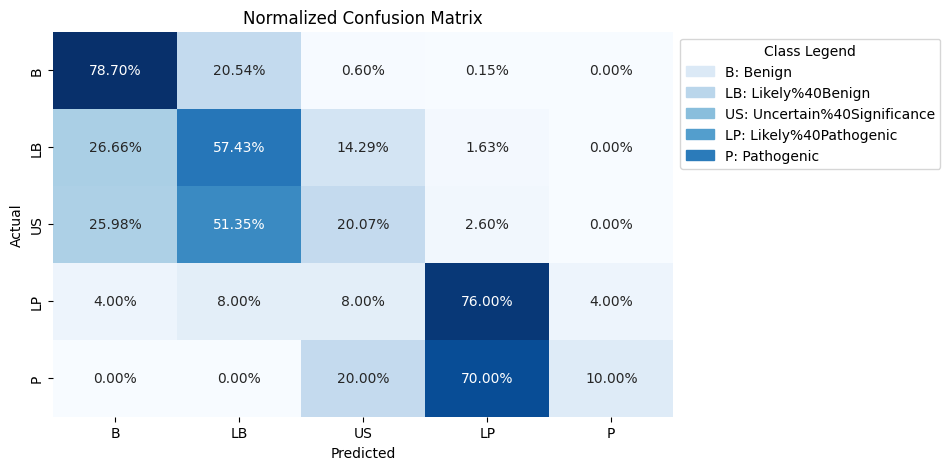

Classification report for Bagging with dataset Encoded - OneHot Nans, Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     76922
           1       0.68      0.66      0.67      5151
           2       0.80      0.63      0.71      6781
           3       0.45      0.20      0.28        25
           4       0.25      0.10      0.14        10

    accuracy                           0.94     88889
   macro avg       0.63      0.52      0.56     88889
weighted avg       0.94      0.94      0.94     88889



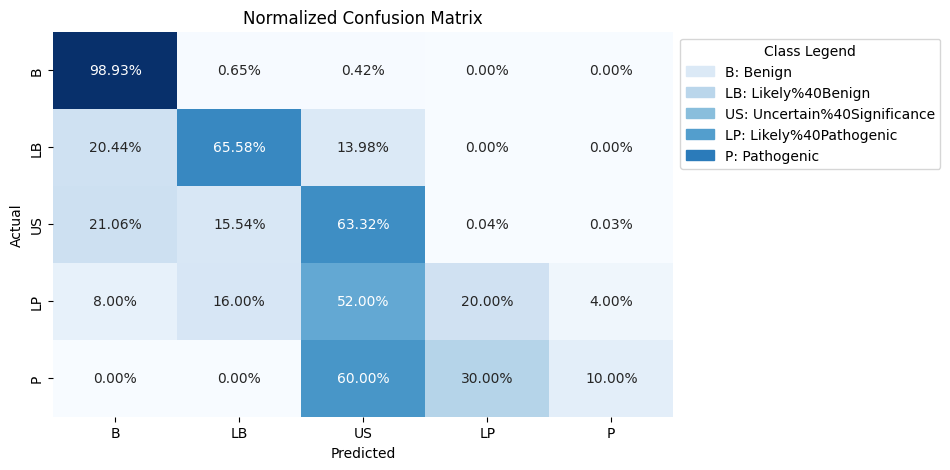

Classification report for Decision Tree with dataset Encoded - OneHot Nans, Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     76922
           1       0.58      0.58      0.58      5151
           2       0.61      0.63      0.62      6781
           3       0.24      0.16      0.19        25
           4       0.12      0.10      0.11        10

    accuracy                           0.92     88889
   macro avg       0.50      0.49      0.49     88889
weighted avg       0.92      0.92      0.92     88889



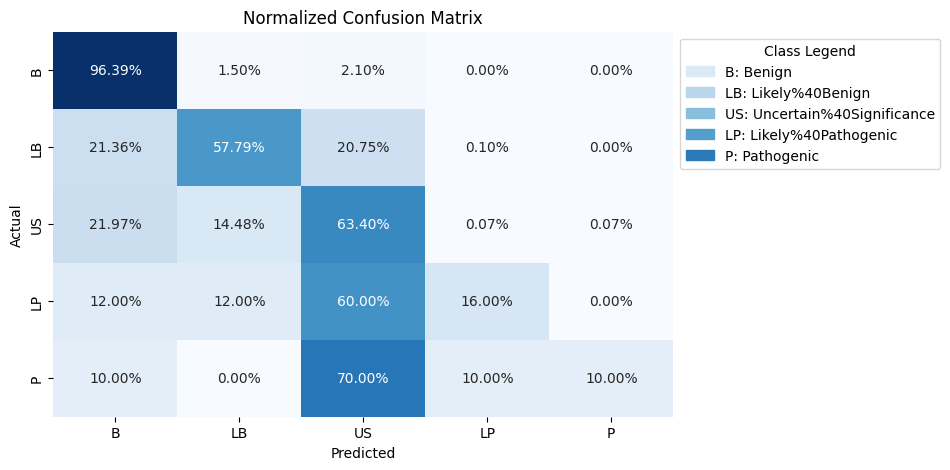

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression with dataset Encoded - OneHot Nans, Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.98      0.79      0.88     76922
           1       0.29      0.66      0.40      5151
           2       0.29      0.60      0.39      6781
           3       0.05      0.84      0.10        25
           4       0.08      0.30      0.13        10

    accuracy                           0.77     88889
   macro avg       0.34      0.64      0.38     88889
weighted avg       0.88      0.77      0.81     88889



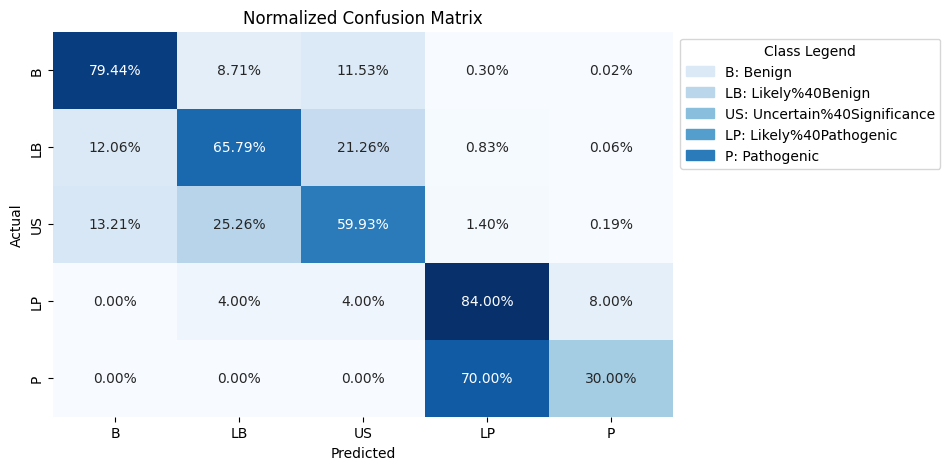

Classification report for CatBoost with dataset Encoded - OneHot Nans, Median and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     76922
           1       0.52      0.83      0.64      5151
           2       0.54      0.74      0.62      6781
           3       0.35      0.36      0.35        25
           4       0.57      0.40      0.47        10

    accuracy                           0.90     88889
   macro avg       0.59      0.65      0.61     88889
weighted avg       0.93      0.90      0.91     88889



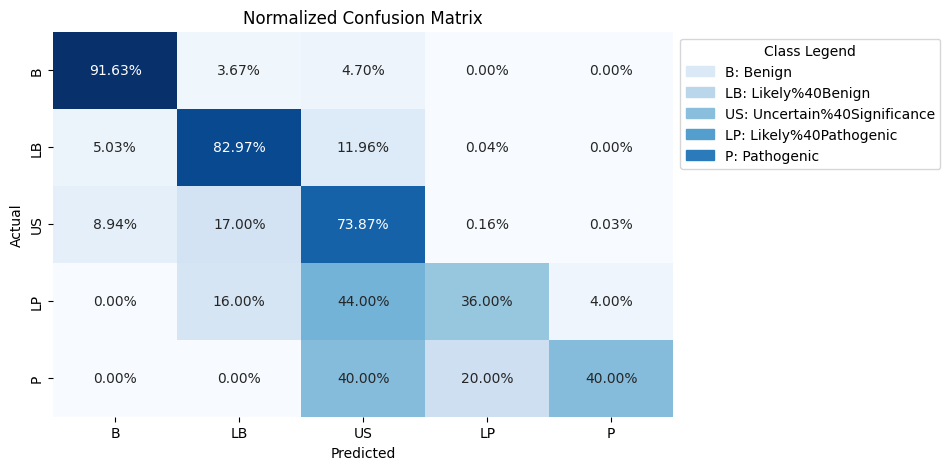

d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [19:24:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Classification report for XGBoost with dataset Encoded - OneHot Nans, Median and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     76922
           1       0.73      0.67      0.70      5151
           2       0.81      0.64      0.72      6781
           3       0.62      0.20      0.30        25
           4       0.33      0.10      0.15        10

    accuracy                           0.94     88889
   macro avg       0.69      0.52      0.57     88889
weighted avg       0.94      0.94      0.94     88889



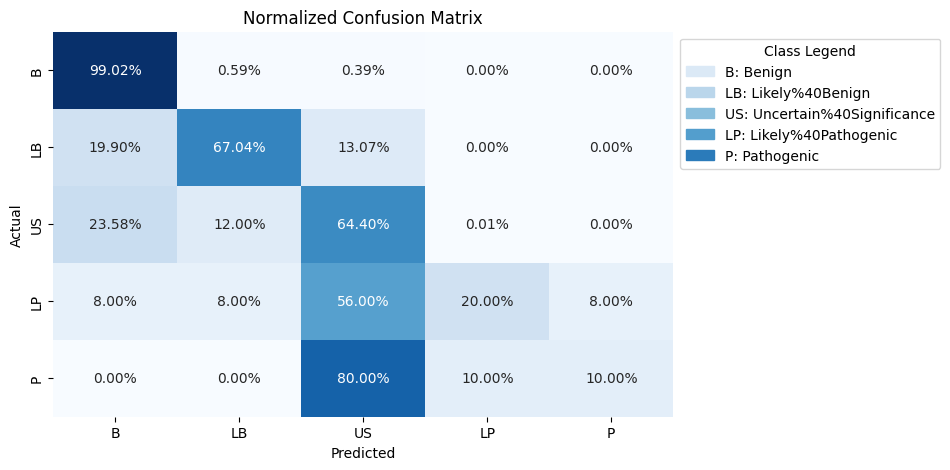

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8952
[LightGBM] [Info] Number of data points in the train set: 355555, number of used features: 154
[LightGBM] [Info] Start training from score -1.609036
[LightGBM] [Info] Start training from score -1.609045
[LightGBM] [Info] Start training from score -1.609021
[LightGBM] [Info] Start training from score -1.611054
[LightGBM] [Info] Start training from score -1.609035
Classification report for LightGBM with dataset Encoded - OneHot Nans, Median and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     76922
           1       0.51      0.83      0.63      5151
           2       0.54      0.73      0.62      6781
           3       0.45      0.36      0.40        25


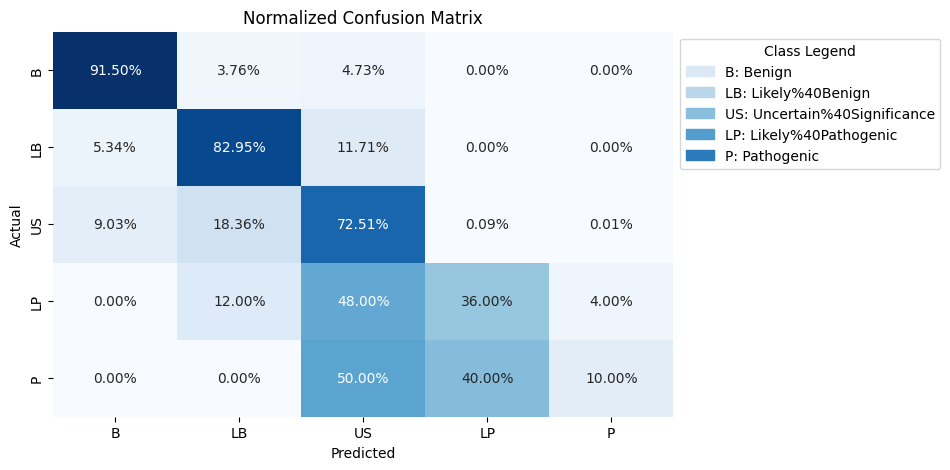

Classification report for Random Forest with dataset Encoded - OneHot Nans, Median and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     76922
           1       0.74      0.61      0.67      5151
           2       0.84      0.61      0.71      6781
           3       0.80      0.16      0.27        25
           4       0.50      0.10      0.17        10

    accuracy                           0.94     88889
   macro avg       0.77      0.50      0.56     88889
weighted avg       0.94      0.94      0.94     88889



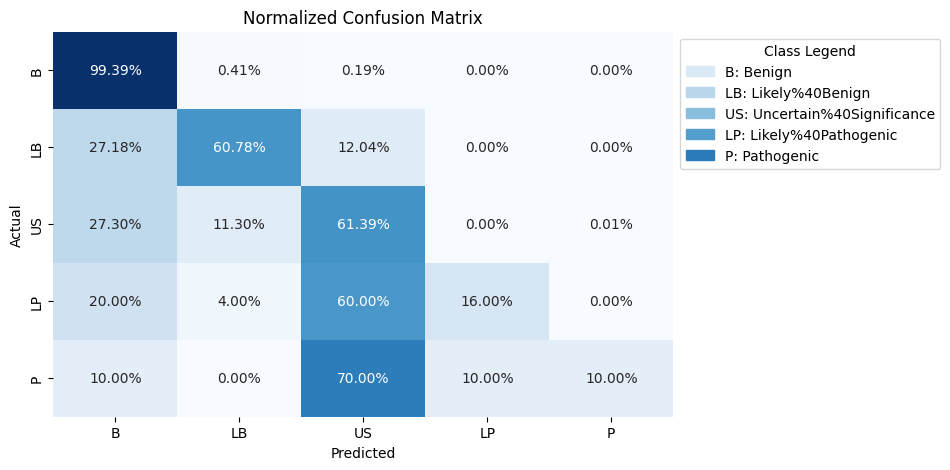

Classification report for AdaBoost with dataset Encoded - OneHot Nans, Median and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.96      0.64      0.77     76922
           1       0.09      0.58      0.16      5151
           2       0.44      0.29      0.35      6781
           3       0.04      0.80      0.07        25
           4       0.57      0.40      0.47        10

    accuracy                           0.61     88889
   macro avg       0.42      0.54      0.37     88889
weighted avg       0.87      0.61      0.70     88889



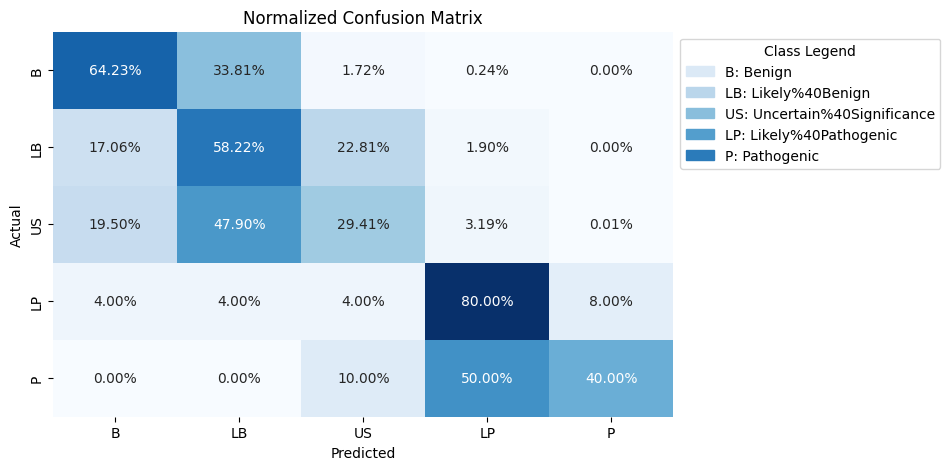

Classification report for Bagging with dataset Encoded - OneHot Nans, Median and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     76922
           1       0.69      0.66      0.67      5151
           2       0.80      0.63      0.70      6781
           3       0.56      0.20      0.29        25
           4       0.50      0.20      0.29        10

    accuracy                           0.94     88889
   macro avg       0.70      0.53      0.59     88889
weighted avg       0.94      0.94      0.94     88889



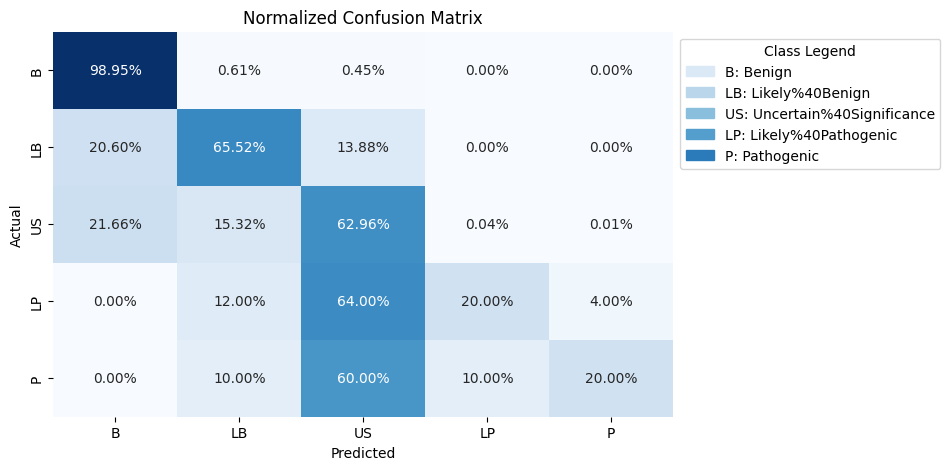

Classification report for Decision Tree with dataset Encoded - OneHot Nans, Median and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     76922
           1       0.58      0.58      0.58      5151
           2       0.62      0.64      0.63      6781
           3       0.27      0.24      0.26        25
           4       0.10      0.10      0.10        10

    accuracy                           0.92     88889
   macro avg       0.51      0.50      0.51     88889
weighted avg       0.92      0.92      0.92     88889



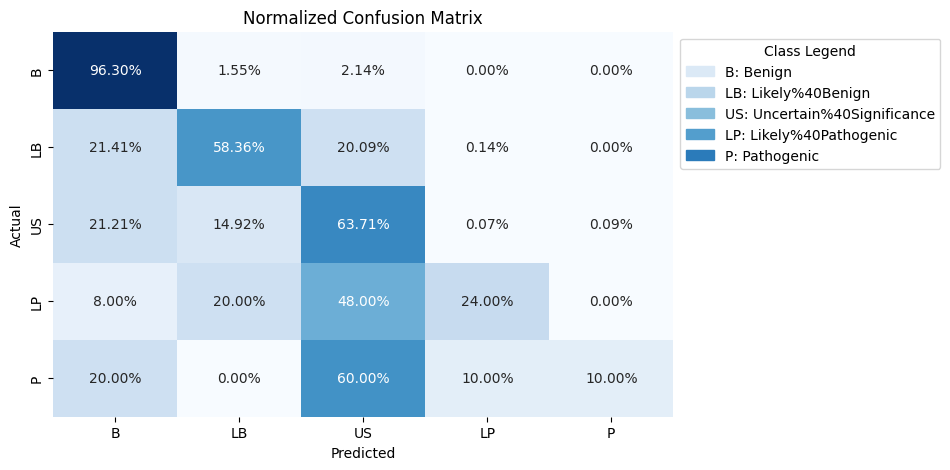

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression with dataset Encoded - OneHot Nans, Median and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     76922
           1       0.29      0.66      0.40      5151
           2       0.29      0.60      0.39      6781
           3       0.05      0.80      0.09        25
           4       0.09      0.30      0.13        10

    accuracy                           0.77     88889
   macro avg       0.34      0.63      0.38     88889
weighted avg       0.88      0.77      0.81     88889



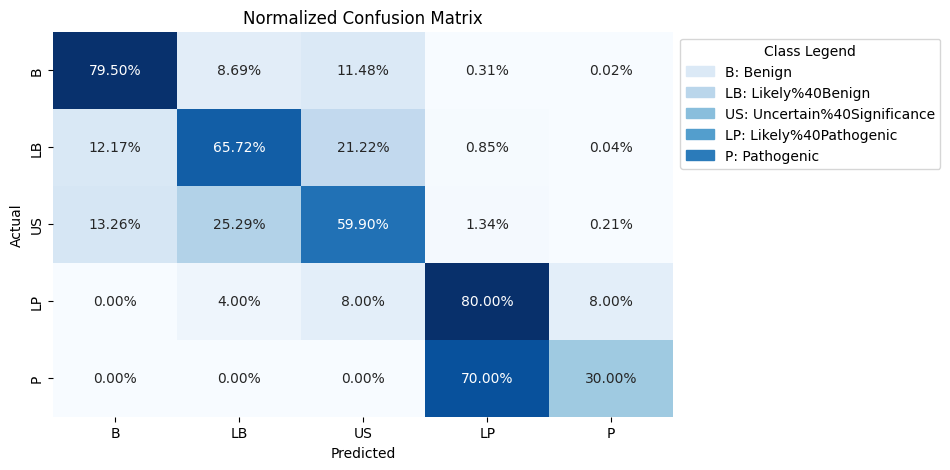

Classification report for CatBoost with dataset Encoded - Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     76922
           1       0.52      0.83      0.64      5151
           2       0.55      0.74      0.63      6781
           3       0.39      0.36      0.37        25
           4       0.36      0.40      0.38        10

    accuracy                           0.90     88889
   macro avg       0.56      0.65      0.60     88889
weighted avg       0.93      0.90      0.91     88889



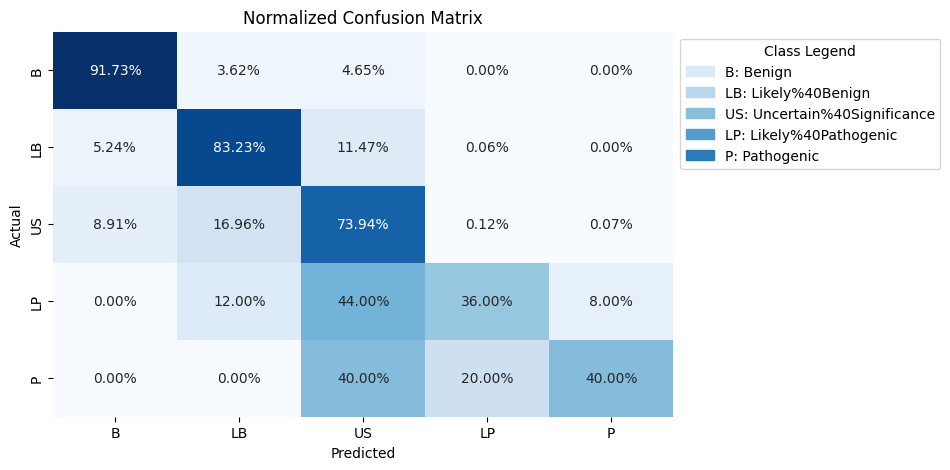

d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [19:41:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Classification report for XGBoost with dataset Encoded - Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     76922
           1       0.73      0.67      0.70      5151
           2       0.81      0.64      0.71      6781
           3       0.57      0.16      0.25        25
           4       0.50      0.20      0.29        10

    accuracy                           0.94     88889
   macro avg       0.71      0.53      0.58     88889
weighted avg       0.94      0.94      0.94     88889



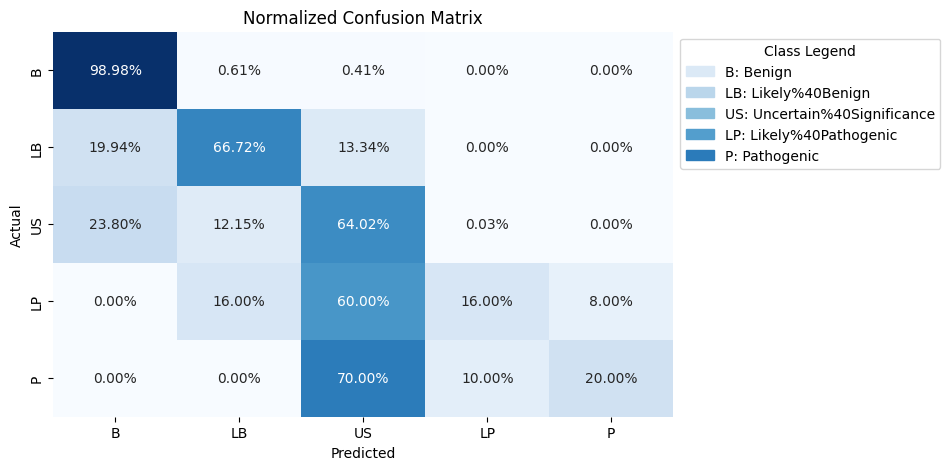

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8912
[LightGBM] [Info] Number of data points in the train set: 355555, number of used features: 103
[LightGBM] [Info] Start training from score -1.609036
[LightGBM] [Info] Start training from score -1.609045
[LightGBM] [Info] Start training from score -1.609021
[LightGBM] [Info] Start training from score -1.611054
[LightGBM] [Info] Start training from score -1.609035
Classification report for LightGBM with dataset Encoded - Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     76922
           1       0.51      0.82      0.63      5151
           2       0.54      0.73      0.62      6781
           3       0.50      0.32      0.39        25
      

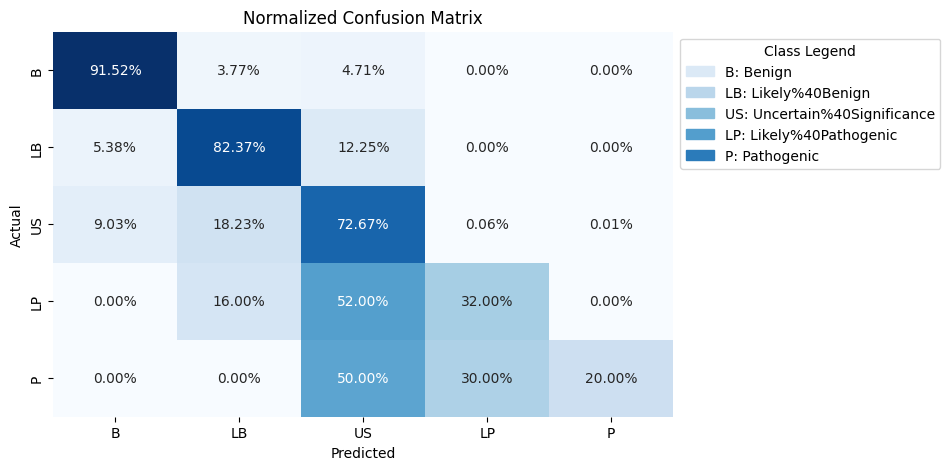

Classification report for Random Forest with dataset Encoded - Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     76922
           1       0.75      0.63      0.68      5151
           2       0.84      0.62      0.71      6781
           3       0.80      0.16      0.27        25
           4       0.50      0.10      0.17        10

    accuracy                           0.94     88889
   macro avg       0.77      0.50      0.56     88889
weighted avg       0.94      0.94      0.94     88889



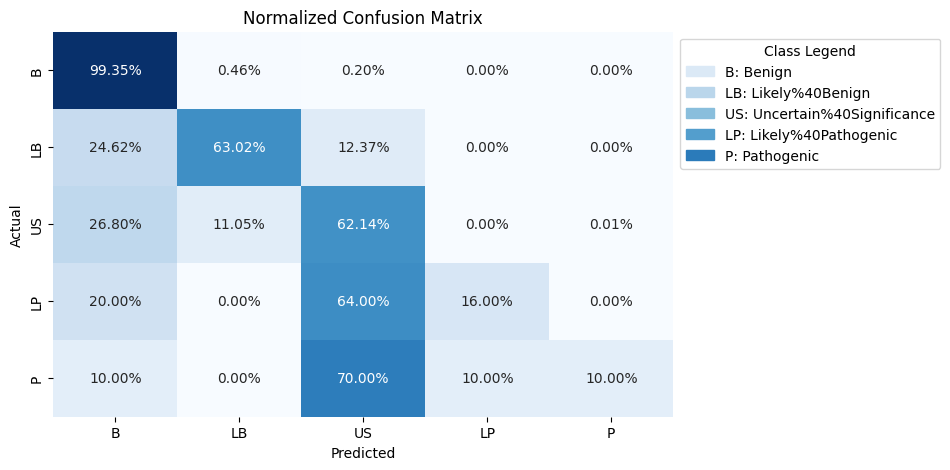

Classification report for AdaBoost with dataset Encoded - Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.95      0.79      0.86     76922
           1       0.13      0.57      0.22      5151
           2       0.53      0.20      0.29      6781
           3       0.05      0.76      0.09        25
           4       0.50      0.10      0.17        10

    accuracy                           0.73     88889
   macro avg       0.43      0.48      0.32     88889
weighted avg       0.87      0.73      0.78     88889



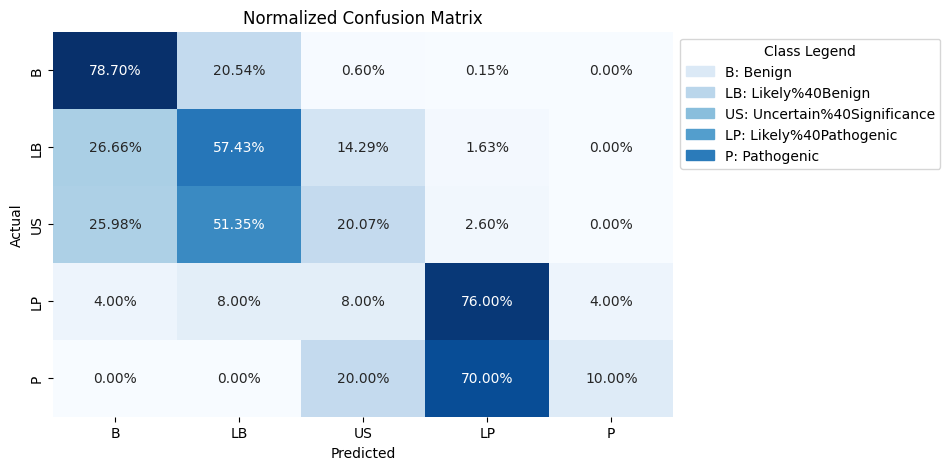

Classification report for Bagging with dataset Encoded - Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     76922
           1       0.68      0.65      0.67      5151
           2       0.80      0.63      0.71      6781
           3       0.56      0.20      0.29        25
           4       0.33      0.10      0.15        10

    accuracy                           0.94     88889
   macro avg       0.67      0.52      0.56     88889
weighted avg       0.94      0.94      0.94     88889



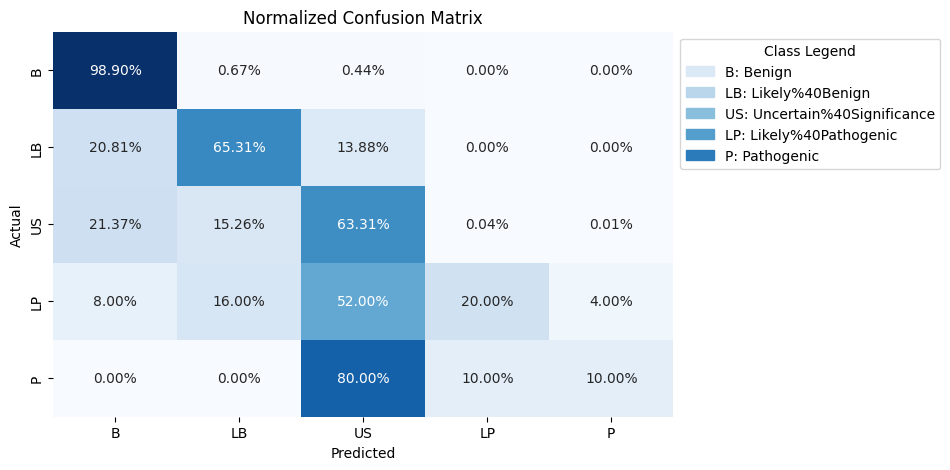

Classification report for Decision Tree with dataset Encoded - Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     76922
           1       0.58      0.58      0.58      5151
           2       0.62      0.63      0.62      6781
           3       0.17      0.16      0.16        25
           4       0.12      0.10      0.11        10

    accuracy                           0.92     88889
   macro avg       0.49      0.49      0.49     88889
weighted avg       0.92      0.92      0.92     88889



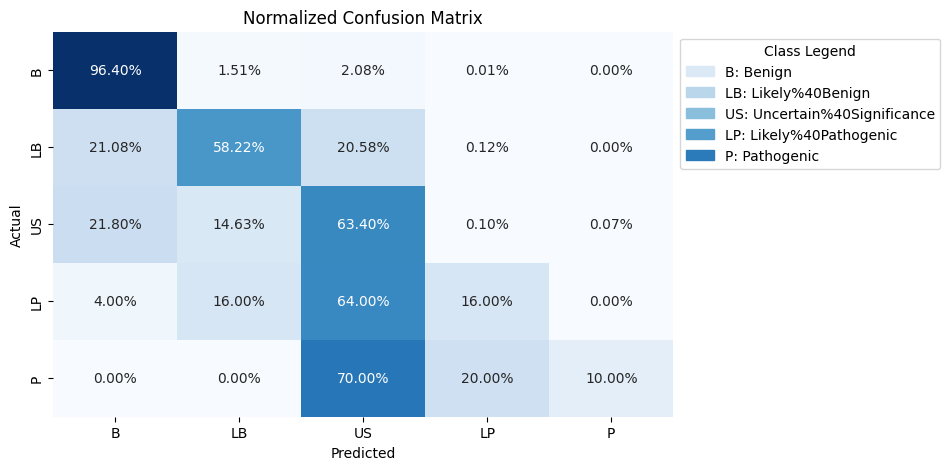

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression with dataset Encoded - Outside Range and preprocessing MinMax:
              precision    recall  f1-score   support

           0       0.98      0.79      0.88     76922
           1       0.29      0.66      0.40      5151
           2       0.29      0.59      0.39      6781
           3       0.04      0.84      0.08        25
           4       0.04      0.20      0.07        10

    accuracy                           0.77     88889
   macro avg       0.33      0.62      0.36     88889
weighted avg       0.88      0.77      0.81     88889



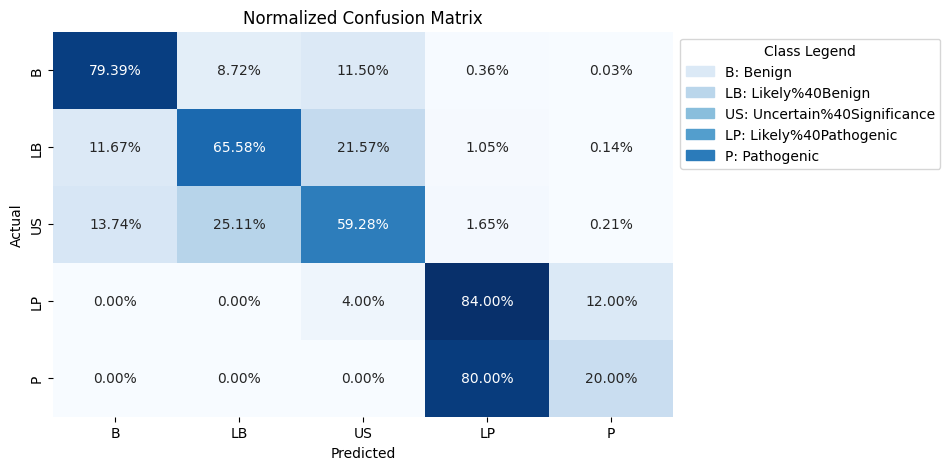

Classification report for CatBoost with dataset Encoded - OneHot Nans, Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     76922
           1       0.52      0.83      0.64      5151
           2       0.55      0.74      0.63      6781
           3       0.35      0.28      0.31        25
           4       0.43      0.30      0.35        10

    accuracy                           0.90     88889
   macro avg       0.57      0.61      0.58     88889
weighted avg       0.93      0.90      0.91     88889



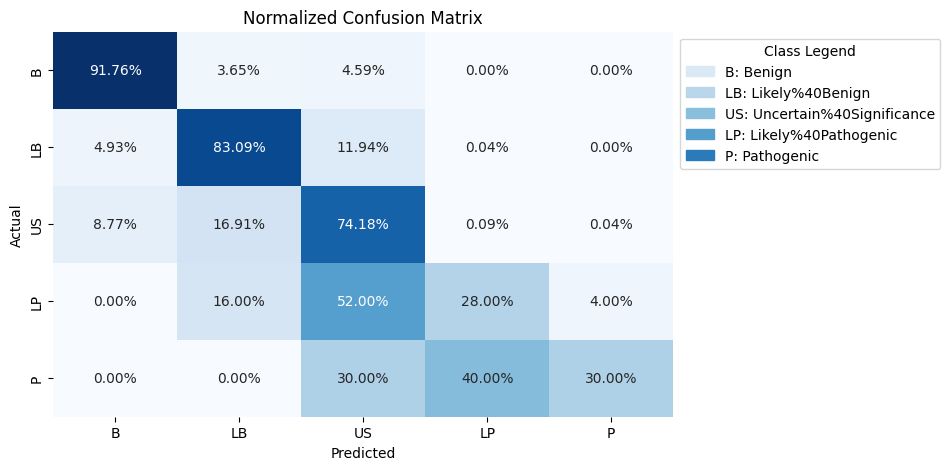

d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [19:56:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Classification report for XGBoost with dataset Encoded - OneHot Nans, Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     76922
           1       0.73      0.67      0.70      5151
           2       0.81      0.64      0.72      6781
           3       0.62      0.20      0.30        25
           4       0.33      0.10      0.15        10

    accuracy                           0.94     88889
   macro avg       0.69      0.52      0.57     88889
weighted avg       0.94      0.94      0.94     88889



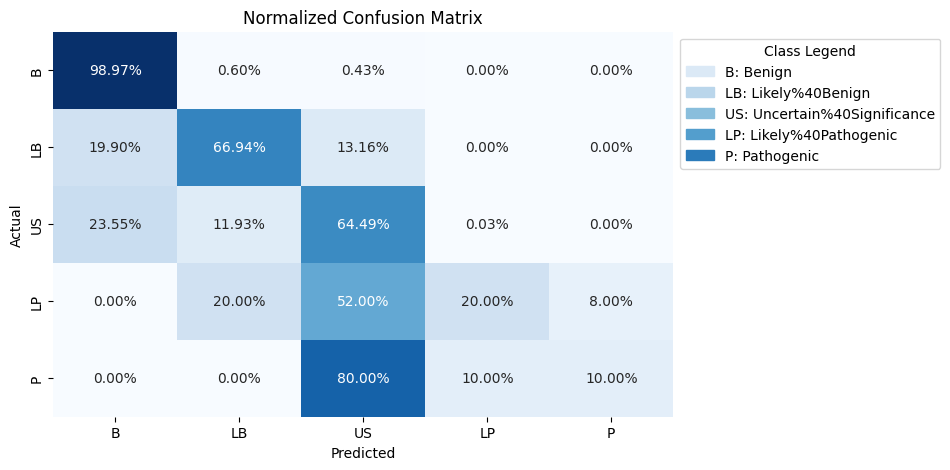

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9178
[LightGBM] [Info] Number of data points in the train set: 355555, number of used features: 155
[LightGBM] [Info] Start training from score -1.609036
[LightGBM] [Info] Start training from score -1.609045
[LightGBM] [Info] Start training from score -1.609021
[LightGBM] [Info] Start training from score -1.611054
[LightGBM] [Info] Start training from score -1.609035
Classification report for LightGBM with dataset Encoded - OneHot Nans, Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     76922
           1       0.51      0.83      0.63      5151
           2       0.54      0.73      0.62      6781
           3       0.54      0.28      0.37    

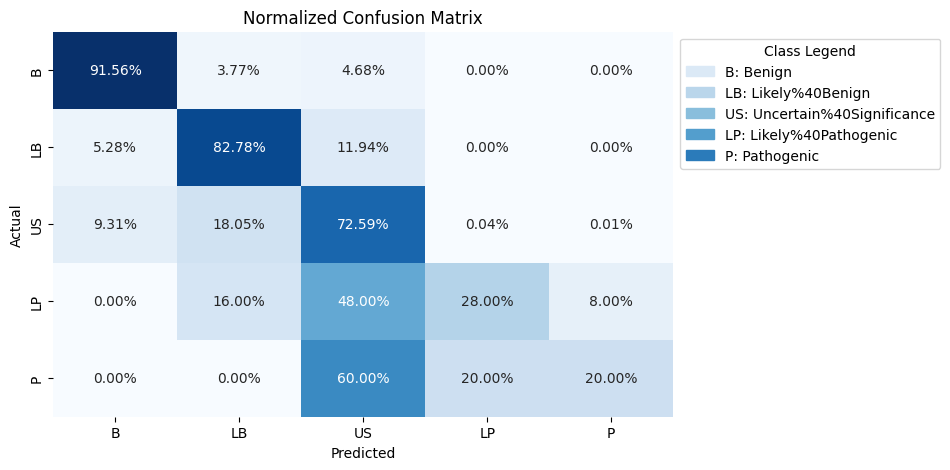

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for Random Forest with dataset Encoded - OneHot Nans, Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     76922
           1       0.75      0.61      0.67      5151
           2       0.85      0.62      0.71      6781
           3       0.67      0.16      0.26        25
           4       0.00      0.00      0.00        10

    accuracy                           0.94     88889
   macro avg       0.64      0.48      0.52     88889
weighted avg       0.94      0.94      0.94     88889



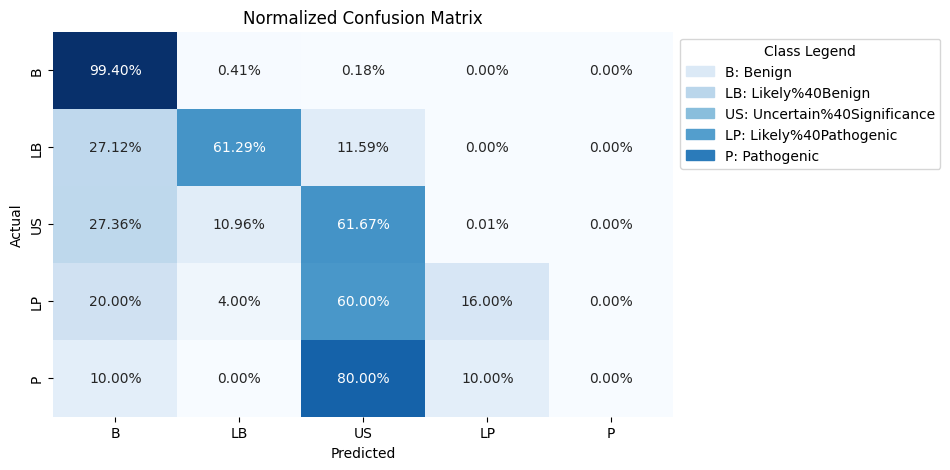

Classification report for AdaBoost with dataset Encoded - OneHot Nans, Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     76922
           1       0.14      0.41      0.21      5151
           2       0.59      0.25      0.35      6781
           3       0.04      0.80      0.08        25
           4       0.50      0.20      0.29        10

    accuracy                           0.78     88889
   macro avg       0.44      0.50      0.36     88889
weighted avg       0.86      0.78      0.81     88889



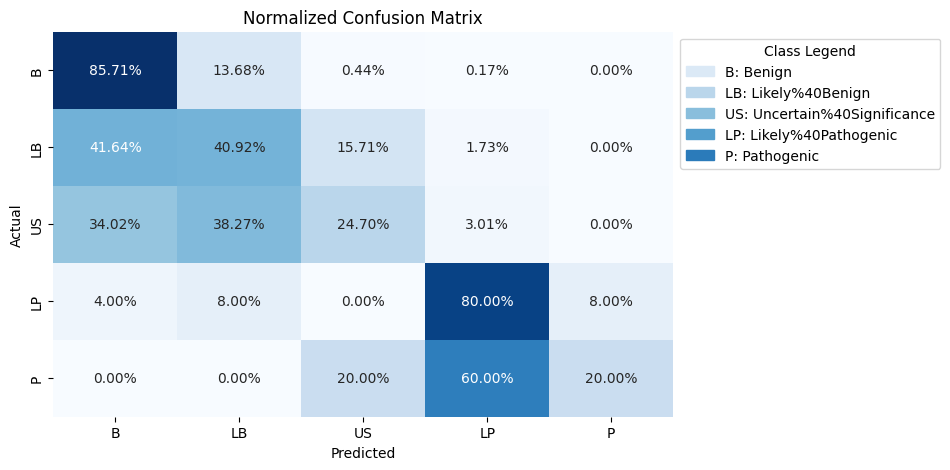

Classification report for Bagging with dataset Encoded - OneHot Nans, Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     76922
           1       0.69      0.66      0.68      5151
           2       0.80      0.63      0.71      6781
           3       0.50      0.20      0.29        25
           4       0.50      0.10      0.17        10

    accuracy                           0.94     88889
   macro avg       0.69      0.52      0.56     88889
weighted avg       0.94      0.94      0.94     88889



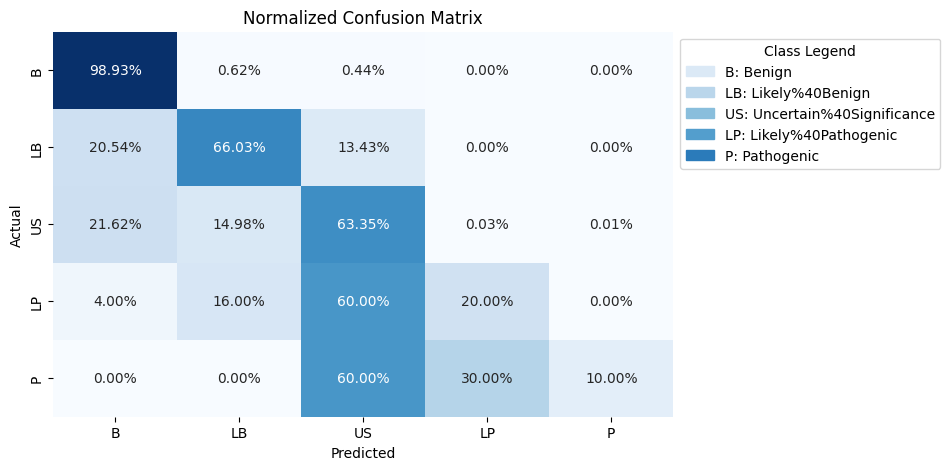

Classification report for Decision Tree with dataset Encoded - OneHot Nans, Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     76922
           1       0.58      0.58      0.58      5151
           2       0.62      0.64      0.63      6781
           3       0.18      0.16      0.17        25
           4       0.11      0.10      0.11        10

    accuracy                           0.92     88889
   macro avg       0.49      0.49      0.49     88889
weighted avg       0.92      0.92      0.92     88889



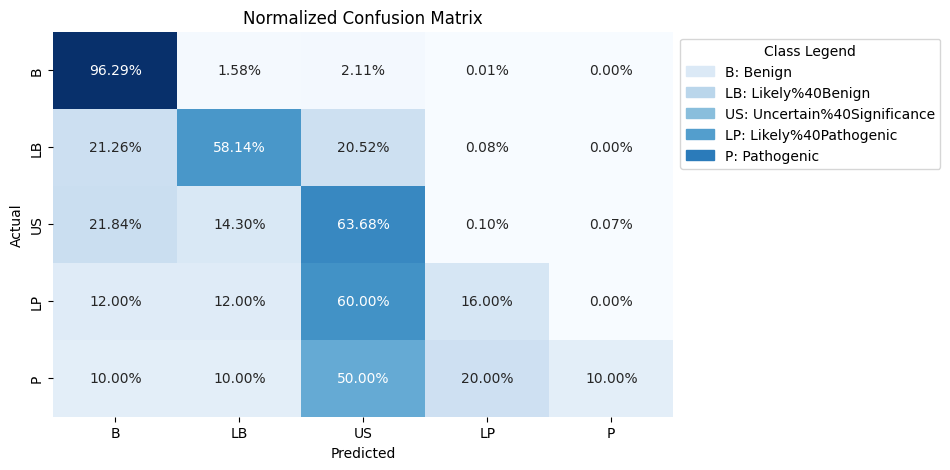

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression with dataset Encoded - OneHot Nans, Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.69      0.81     76922
           1       0.18      0.62      0.29      5151
           2       0.23      0.42      0.30      6781
           3       0.00      0.48      0.01        25
           4       0.01      0.80      0.01        10

    accuracy                           0.66     88889
   macro avg       0.28      0.60      0.28     88889
weighted avg       0.87      0.66      0.74     88889



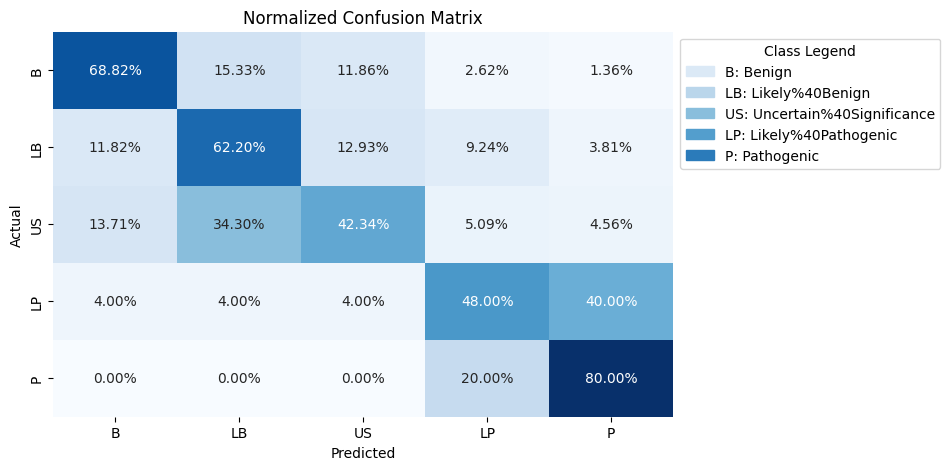

Classification report for CatBoost with dataset Encoded - OneHot Nans, Median and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     76922
           1       0.52      0.83      0.64      5151
           2       0.54      0.74      0.62      6781
           3       0.36      0.36      0.36        25
           4       0.80      0.40      0.53        10

    accuracy                           0.90     88889
   macro avg       0.64      0.65      0.62     88889
weighted avg       0.93      0.90      0.91     88889



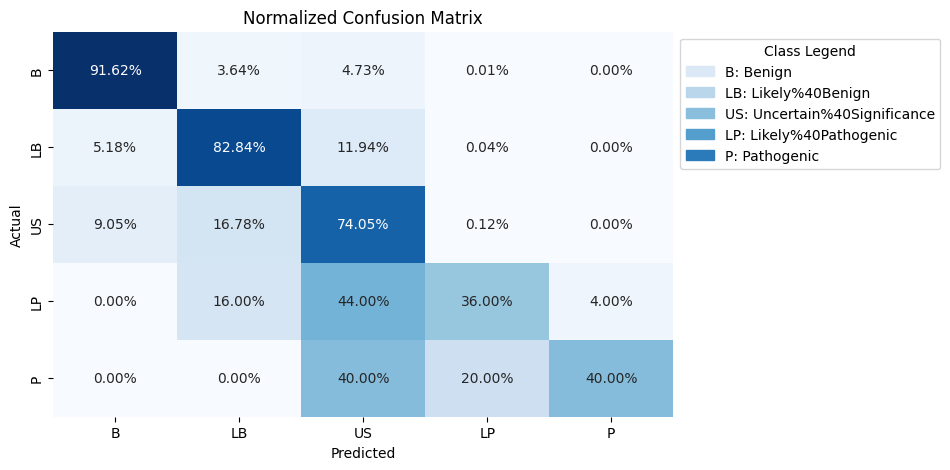

d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [20:13:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Classification report for XGBoost with dataset Encoded - OneHot Nans, Median and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     76922
           1       0.73      0.67      0.70      5151
           2       0.81      0.64      0.72      6781
           3       0.62      0.20      0.30        25
           4       0.33      0.10      0.15        10

    accuracy                           0.94     88889
   macro avg       0.69      0.52      0.57     88889
weighted avg       0.94      0.94      0.94     88889



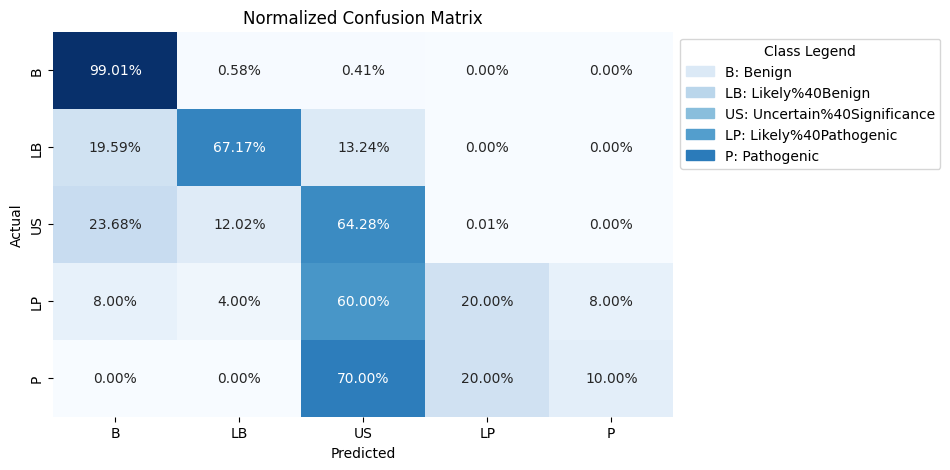

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9176
[LightGBM] [Info] Number of data points in the train set: 355555, number of used features: 154
[LightGBM] [Info] Start training from score -1.609036
[LightGBM] [Info] Start training from score -1.609045
[LightGBM] [Info] Start training from score -1.609021
[LightGBM] [Info] Start training from score -1.611054
[LightGBM] [Info] Start training from score -1.609035
Classification report for LightGBM with dataset Encoded - OneHot Nans, Median and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     76922
           1       0.51      0.83      0.63      5151
           2       0.54      0.72      0.62      6781
           3       0.47      0.32      0.38        25


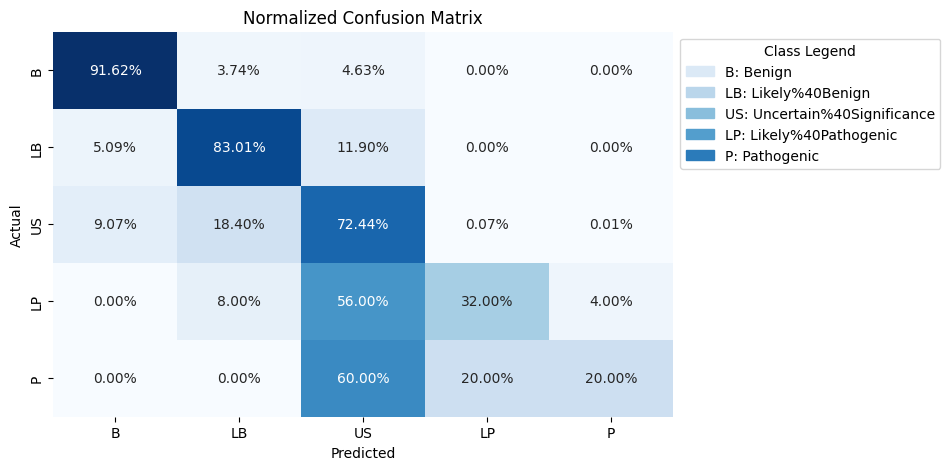

Classification report for Random Forest with dataset Encoded - OneHot Nans, Median and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     76922
           1       0.75      0.61      0.68      5151
           2       0.85      0.62      0.71      6781
           3       0.75      0.12      0.21        25
           4       0.00      0.00      0.00        10

    accuracy                           0.94     88889
   macro avg       0.66      0.47      0.51     88889
weighted avg       0.94      0.94      0.94     88889



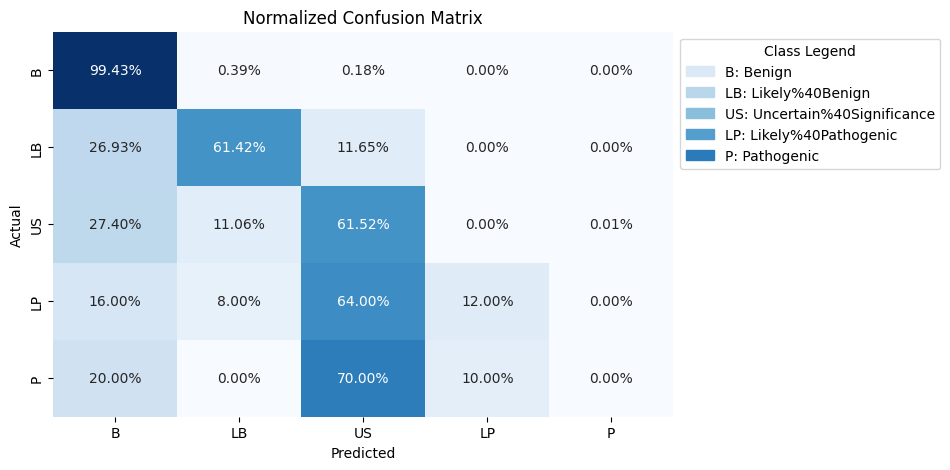

Classification report for AdaBoost with dataset Encoded - OneHot Nans, Median and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.60      0.74     76922
           1       0.09      0.68      0.16      5151
           2       0.56      0.22      0.32      6781
           3       0.04      0.76      0.08        25
           4       0.43      0.30      0.35        10

    accuracy                           0.57     88889
   macro avg       0.42      0.51      0.33     88889
weighted avg       0.88      0.57      0.67     88889



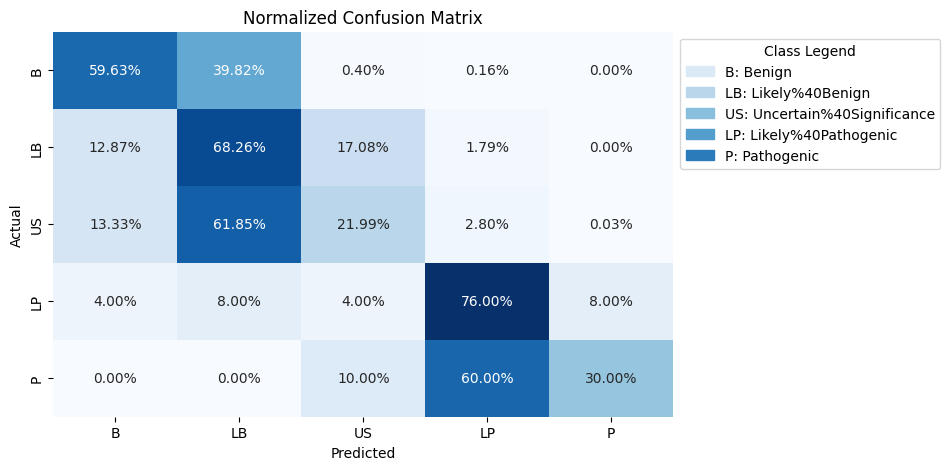

Classification report for Bagging with dataset Encoded - OneHot Nans, Median and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     76922
           1       0.69      0.66      0.68      5151
           2       0.80      0.63      0.70      6781
           3       0.50      0.16      0.24        25
           4       0.67      0.20      0.31        10

    accuracy                           0.94     88889
   macro avg       0.72      0.53      0.58     88889
weighted avg       0.94      0.94      0.94     88889



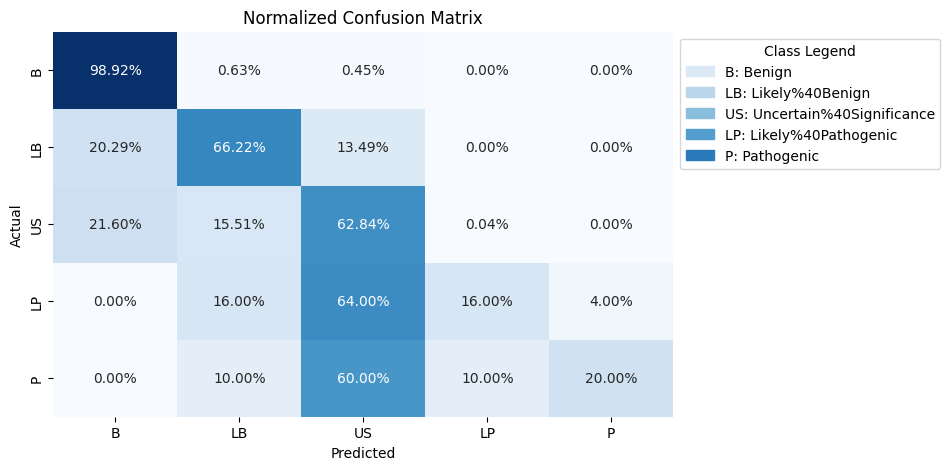

Classification report for Decision Tree with dataset Encoded - OneHot Nans, Median and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     76922
           1       0.58      0.58      0.58      5151
           2       0.62      0.64      0.63      6781
           3       0.30      0.24      0.27        25
           4       0.10      0.10      0.10        10

    accuracy                           0.92     88889
   macro avg       0.51      0.50      0.51     88889
weighted avg       0.92      0.92      0.92     88889



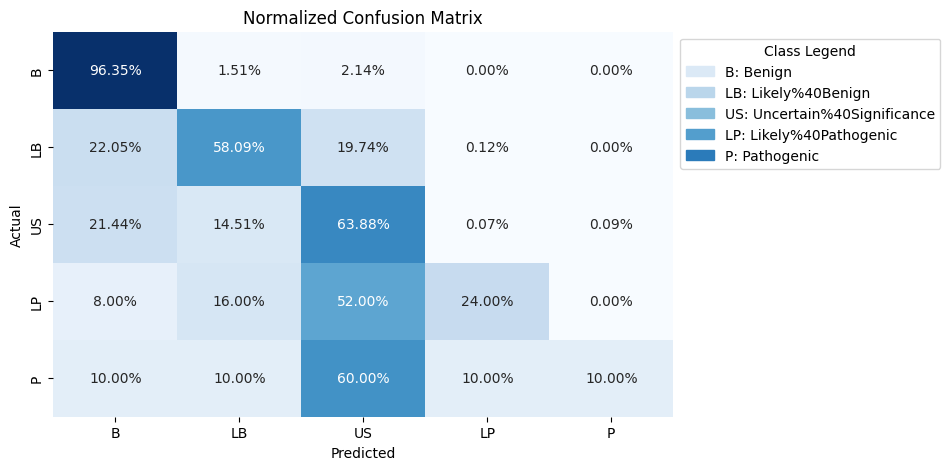

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression with dataset Encoded - OneHot Nans, Median and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.98      0.37      0.54     76922
           1       0.15      0.44      0.22      5151
           2       0.13      0.56      0.21      6781
           3       0.00      0.48      0.00        25
           4       0.00      0.70      0.00        10

    accuracy                           0.39     88889
   macro avg       0.25      0.51      0.20     88889
weighted avg       0.87      0.39      0.49     88889



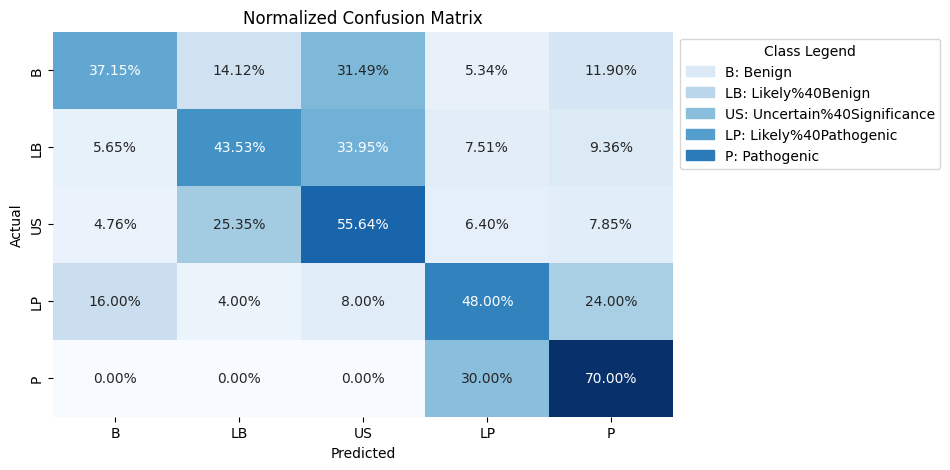

Classification report for CatBoost with dataset Encoded - Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     76922
           1       0.52      0.83      0.64      5151
           2       0.54      0.74      0.62      6781
           3       0.38      0.40      0.39        25
           4       0.38      0.30      0.33        10

    accuracy                           0.90     88889
   macro avg       0.56      0.64      0.59     88889
weighted avg       0.93      0.90      0.91     88889



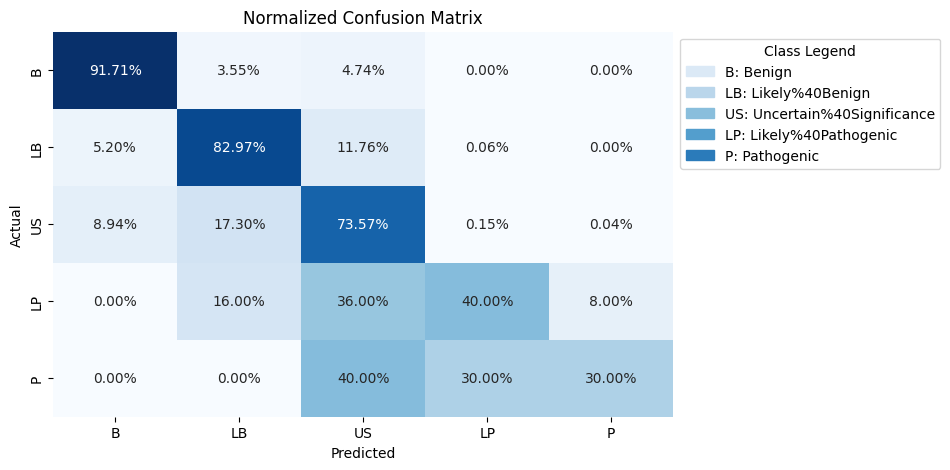

d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [20:38:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Classification report for XGBoost with dataset Encoded - Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     76922
           1       0.73      0.67      0.70      5151
           2       0.81      0.64      0.72      6781
           3       0.56      0.20      0.29        25
           4       0.33      0.10      0.15        10

    accuracy                           0.94     88889
   macro avg       0.68      0.52      0.57     88889
weighted avg       0.94      0.94      0.94     88889



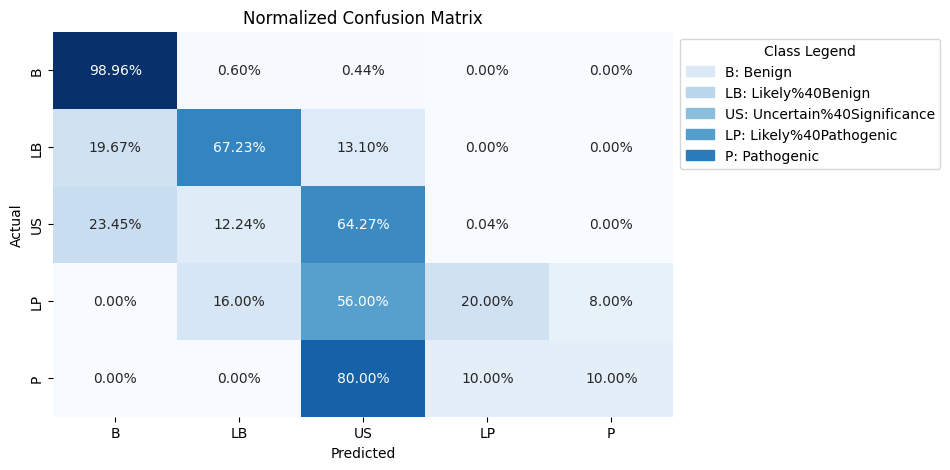

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9074
[LightGBM] [Info] Number of data points in the train set: 355555, number of used features: 103
[LightGBM] [Info] Start training from score -1.609036
[LightGBM] [Info] Start training from score -1.609045
[LightGBM] [Info] Start training from score -1.609021
[LightGBM] [Info] Start training from score -1.611054
[LightGBM] [Info] Start training from score -1.609035
Classification report for LightGBM with dataset Encoded - Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     76922
           1       0.51      0.83      0.63      5151
           2       0.54      0.72      0.62      6781
           3       0.39      0.28      0.33        25
      

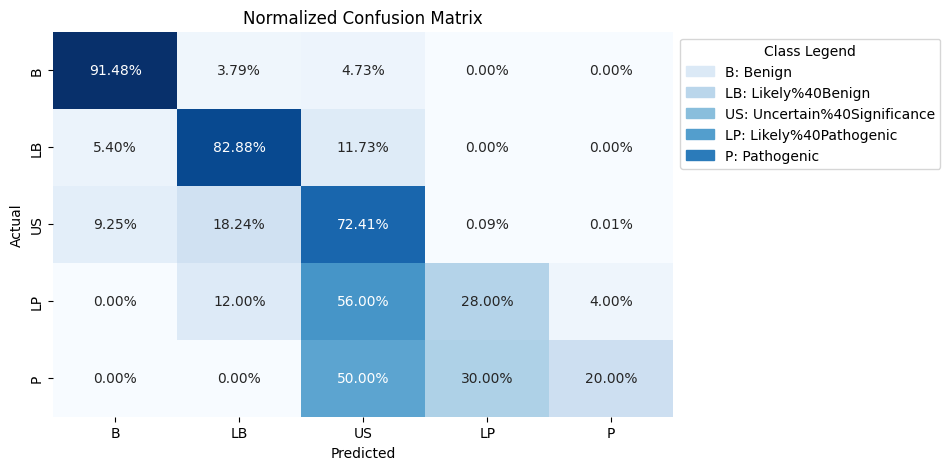

Classification report for Random Forest with dataset Encoded - Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     76922
           1       0.75      0.63      0.68      5151
           2       0.85      0.62      0.71      6781
           3       0.67      0.16      0.26        25
           4       0.50      0.10      0.17        10

    accuracy                           0.94     88889
   macro avg       0.74      0.50      0.56     88889
weighted avg       0.94      0.94      0.94     88889



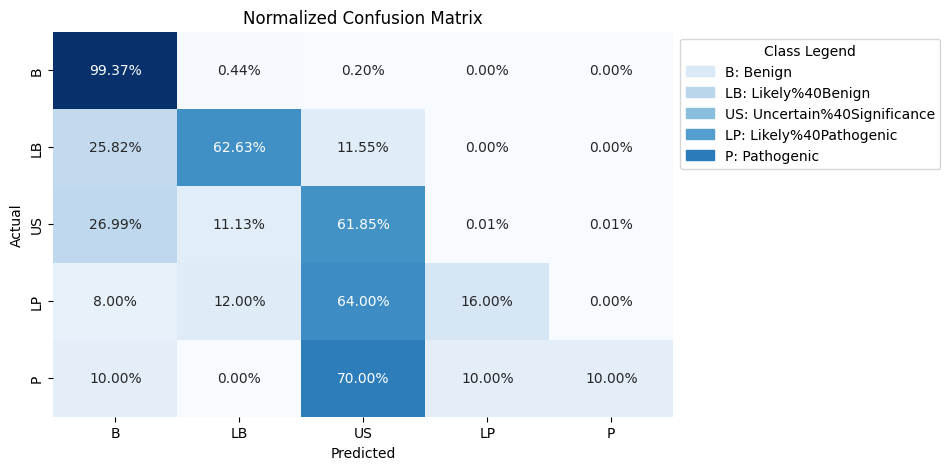

Classification report for AdaBoost with dataset Encoded - Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     76922
           1       0.14      0.41      0.21      5151
           2       0.59      0.25      0.35      6781
           3       0.04      0.80      0.08        25
           4       0.50      0.20      0.29        10

    accuracy                           0.78     88889
   macro avg       0.44      0.50      0.36     88889
weighted avg       0.86      0.78      0.81     88889



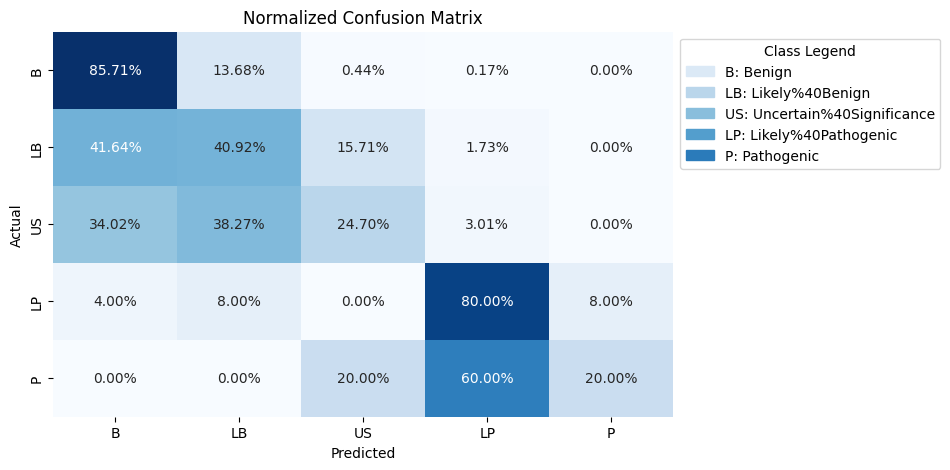

Classification report for Bagging with dataset Encoded - Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     76922
           1       0.69      0.66      0.67      5151
           2       0.80      0.63      0.71      6781
           3       0.42      0.20      0.27        25
           4       0.50      0.10      0.17        10

    accuracy                           0.94     88889
   macro avg       0.68      0.52      0.56     88889
weighted avg       0.94      0.94      0.94     88889



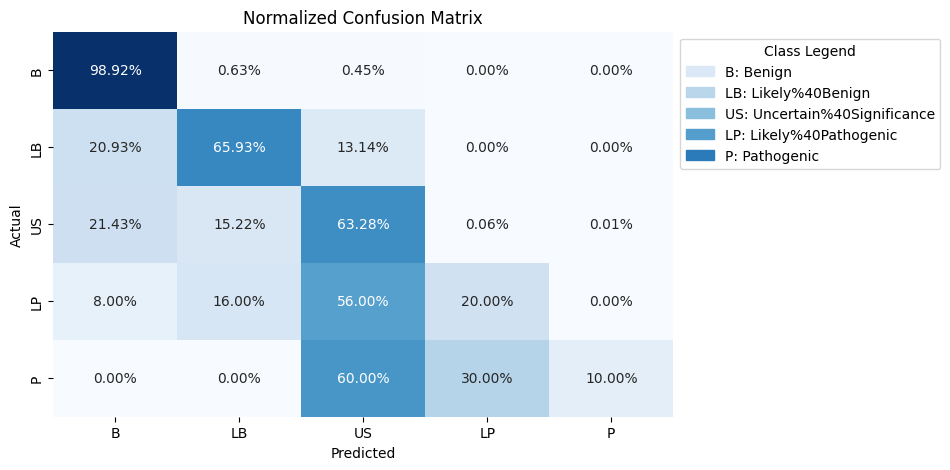

Classification report for Decision Tree with dataset Encoded - Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     76922
           1       0.59      0.58      0.58      5151
           2       0.62      0.64      0.63      6781
           3       0.22      0.20      0.21        25
           4       0.12      0.10      0.11        10

    accuracy                           0.92     88889
   macro avg       0.50      0.50      0.50     88889
weighted avg       0.92      0.92      0.92     88889



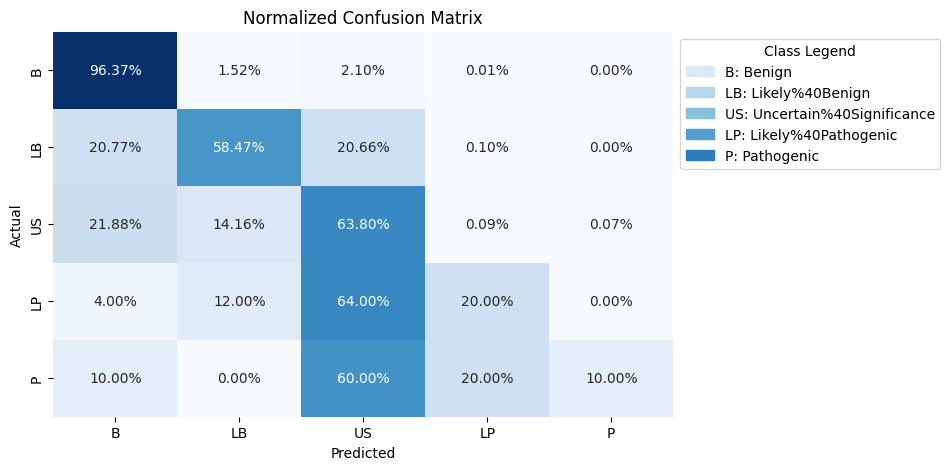

d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression with dataset Encoded - Outside Range and preprocessing Robust:
              precision    recall  f1-score   support

           0       0.98      0.63      0.76     76922
           1       0.17      0.59      0.27      5151
           2       0.19      0.45      0.27      6781
           3       0.00      0.32      0.01        25
           4       0.00      0.90      0.01        10

    accuracy                           0.61     88889
   macro avg       0.27      0.58      0.26     88889
weighted avg       0.87      0.61      0.70     88889



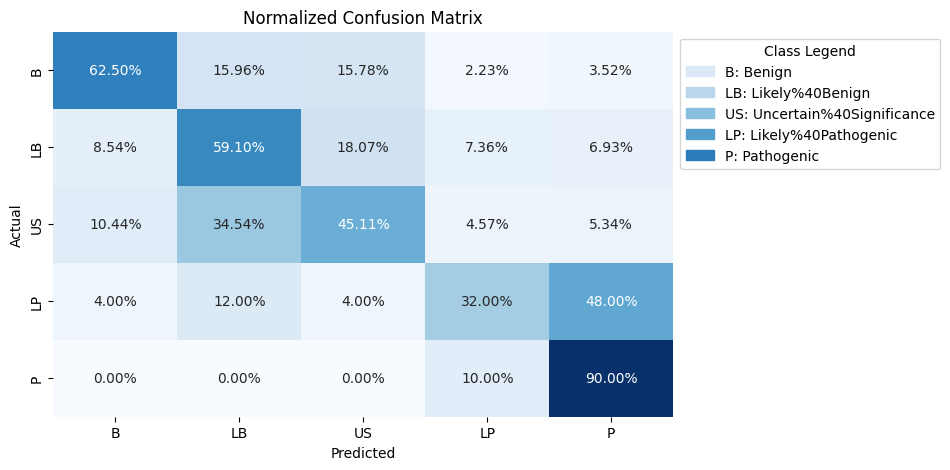

In [13]:
preprocessings = [
    ("None", None),
    ("MinMax", MinMaxScaler()),
    ("Robust", RobustScaler())
]

datasets = [
    ("Encoded - OneHot Nans, Outside Range", encoded_df1),
    ("Encoded - OneHot Nans, Median", encoded_df2),
    ("Encoded - Outside Range", encoded_df3)
]

for preprocessing_name, preprocessing_method in preprocessings:
    for dataset_name, dataset in datasets:
        X = dataset.drop(columns=['ACMG_class'])
        y = dataset['ACMG_class']

        if preprocessing_name != "None":
            X = pd.DataFrame(preprocessing_method.fit_transform(X), columns=X.columns)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        model_seed = 42

        class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)

        models = [
            ('CatBoost', CatBoostClassifier(class_weights=class_weights, verbose=False, random_state=model_seed)),
            ('XGBoost', XGBClassifier(scale_pos_weight=sum(y_train==0)/sum(y_train==1), random_state=model_seed)),
            ('LightGBM', LGBMClassifier(class_weight=dict(enumerate(class_weights)), random_state=model_seed)),
            ('Random Forest', RandomForestClassifier(class_weight=dict(enumerate(class_weights)), random_state=model_seed)),
            ('AdaBoost', AdaBoostClassifier(random_state=model_seed)),
            ('Bagging', BaggingClassifier(random_state=model_seed)),
            ('Decision Tree', DecisionTreeClassifier(class_weight=dict(enumerate(class_weights)), random_state=model_seed)),
            ('Logistic Regression', LogisticRegression(max_iter=1000, class_weight=dict(enumerate(class_weights)), random_state=model_seed)),
        ]

        for model_name, model in models:
            clf = model

            pipeline = Pipeline([
                ('classifier', clf)
            ])

            if model_name == 'AdaBoost':
                sample_weights = class_weights[np.searchsorted(np.unique(y_train), y_train)]
                pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weights)
            else:
                pipeline.fit(X_train, y_train)

            y_pred = pipeline.predict(X_test)
            report = classification_report(y_test, y_pred)
            print(f"Classification report for {model_name} with dataset {dataset_name} and preprocessing {preprocessing_name}:")
            print(report)

            get_confusion_matrix_plot(y_test, y_pred, inverted_mapping)


### Custom Weight Matrix

In [14]:
inverted_mapping

{0: 'Benign',
 1: 'Likely%40Benign',
 2: 'Uncertain%40Significance',
 3: 'Likely%40Pathogenic',
 4: 'Pathogenic'}

In [15]:
cost_matrix = np.array([
    [0, 1, 3, 5, 6], #B
    [1, 0, 3, 5, 6], #LB
    [5, 3, 0, 1, 2], #US
    [10, 7, 5, 0, 1], #LP
    [12, 10, 5, 1, 0]  #P
], dtype = np.float64)

In [16]:
def custom_loss(y_true, y_pred):
    loss = 0
    for i in range(len(y_true)):
        loss += cost_matrix[y_true[i]][y_pred[i]]
    return loss

In [17]:
class_weights = []
for i in range(5):
    count = dataset["ACMG_class"].value_counts().get(i, 0)
    class_weights.append(count)
class_weights = np.array(class_weights, dtype=np.float64)
class_weights -= np.sum(class_weights)
class_weights *= (-1)
class_weights /= np.max(class_weights)
weighted_cost_matrix = cost_matrix * class_weights[:, np.newaxis]
weighted_cost_matrix

array([[ 0.        ,  0.13464403,  0.4039321 ,  0.67322016,  0.80786419],
       [ 0.94215944,  0.        ,  2.82647831,  4.71079718,  5.65295661],
       [ 4.61906551,  2.77143931,  0.        ,  0.9238131 ,  1.84762621],
       [ 9.99833481,  6.99883437,  4.99916741,  0.        ,  0.99983348],
       [12.        , 10.        ,  5.        ,  1.        ,  0.        ]])